#Medición Prueba de Control
Archivo para medir las diferencias de accesos y lecturas en el grupo experimental frente al de control **(OJO, hay que añadir tb la parte de producción y tendencia).**

Diariamente se descargan los datos de la auditoria de los usuarios desde el lunes sábado 13 de Abril de 2024 a las 00:00 horas hasta el momento actual.

In [1]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.1 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt

Defino el grupo experimental como Gr1 y el de control como Gr2.

Hay que tener en cuenta que agentes_inicio son todos los agentes que había el viernes 12 de Abril, se hará un cruce con los agentes del grupo experimental para crear el Gr1.

##Archivos necesarios
Auditoria (descargar todos los días), 1.18 para ver las bajas (descargar todos los días), estructura comercial, grupo control, estandar grupo experimental, formacion grupo experimental, exp_ctrl que es auditoria meses previos grupo experimental (descargar todos los días para meses (o semanas) previos), el 1.12.1 producción por meses (descargar de vez en cuando) y el 1.26 mensual para ver el tipo de producción que se ha realizado (descargar diariamente el mes actual).

Subir todos al colab para ser ejecutados.

In [3]:
accesos_usuarios_df = pd.read_excel('/content/2.13_Auditoria_usuarios.xlsx')
agentes_inicio = pd.read_excel('/content/1.18_Estructura_Comercial.xlsx')
Gr2 = pd.read_excel('/content/1.18_Grupo_de_control.xlsx')
est_gr_exp = pd.read_excel('/content/estandar_gr_exp.xlsx')
for_gr_exp = pd.read_excel('/content/formacion_gr_exp.xlsx')
bajas = pd.read_excel('/content/1.18_Bajas.xlsx')
prod_fis_corr = pd.read_excel('/content/1.12.1_Produccion_Meses.xlsx')
prod_enero = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Enero.xlsx')
prod_febrero = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Febrero.xlsx')
prod_marzo = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Marzo.xlsx')
prod_abril = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Abril.xlsx')
prod_mayo = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Mayo.xlsx')
prod_junio = pd.read_excel('/content/1.26_Rappel_Produccion_Agentes_Junio.xlsx')

# Prueba grupo experimental como grupo de control_2
aud_gr1_2 = pd.read_excel('/content/Exp_Ctrl.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Definición de funciones de limpieza y normalización de los dataframes.

In [4]:
def cols_to_keep(df):
  cols = ['SUCURSAL', 'OFICINA', 'PV', 'CODIGO', 'COD. CALLIDUS/SOLNET', 'LDAP', 'NIF', 'NOMBRE', 'TIPOLOGIA', 'F.ALTA', 'E-MAIL', 'MAIL PERSONAL']
  df = df[cols]
  return df

def clean_df(df):
    # Convertir todas las columnas de tipo object a mayúsculas, excepto las especificadas
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(lambda x: unidecode(x.upper()) if isinstance(x, str) else x)

    # Ahora, aplicamos unidecode a los nombres de las columnas
    df.columns = [unidecode(col.upper()) for col in df.columns]
    return df

def date_delete(df):
    df['DIA'] = df['FECHA ESPANOLA'].dt.day
    df['MES'] = df['FECHA ESPANOLA'].dt.month

    # Elimino la columna fecha del servidor, ya que nos vamos a quedar solo con la fecha española
    del_columns = ['FECHA SERVIDOR']
    df.drop(columns=del_columns, inplace=True)
    # Elimino la columna unnamed si la hay
    if 'UNNAMED: 0' in df.columns:
      df.drop(columns='UNNAMED: 0', inplace=True)
    return df

def clean_production(df):
    columns = ['POSITIONNAME', 'FEC. ALTA', 'POL. FIS. 2024-01', 'POL. FIS. 2024-02', 'POL. FIS. 2024-03', 'POL. FIS. 2024-04', 'POL. FIS. 2024-05', 'POL. FIS. 2024-06', 'POL. CORR. 2024-01', 'POL. CORR. 2024-02', 'POL. CORR. 2024-03', 'POL. CORR. 2024-04', 'POL. CORR. 2024-05', 'POL. CORR. 2024-06']
    df = df[columns]
    df['PRIMER TRIM POL FIS'] = df['POL. FIS. 2024-01'] + df['POL. FIS. 2024-02'] + df['POL. FIS. 2024-03']
    df['SEGUNDO TRIM POL FIS'] = df['POL. FIS. 2024-04'] + df['POL. FIS. 2024-05'] + df['POL. FIS. 2024-06']

    df['POL. CORR. 2024-01'] = pd.to_numeric(df['POL. CORR. 2024-01'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-02'] = pd.to_numeric(df['POL. CORR. 2024-02'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-03'] = pd.to_numeric(df['POL. CORR. 2024-03'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-04'] = pd.to_numeric(df['POL. CORR. 2024-04'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-05'] = pd.to_numeric(df['POL. CORR. 2024-05'].astype(str).str.replace(',', '.'), errors='coerce')
    df['POL. CORR. 2024-06'] = pd.to_numeric(df['POL. CORR. 2024-06'].astype(str).str.replace(',', '.'), errors='coerce')

    df['PRIMER TRIM POL CORR'] = df['POL. CORR. 2024-01'] + df['POL. CORR. 2024-02'] + df['POL. CORR. 2024-03']
    df['SEGUNDO TRIM POL CORR'] = df['POL. CORR. 2024-04'] + df['POL. CORR. 2024-05'] + df['POL. CORR. 2024-06']
    return df

def cols_prod_month(df):
  cols = ['SUCURSAL', 'OFICINA', 'COD. AGENTE', 'NIF', 'POL. FIS. HOGAR', 'POL. FIS. RRTT', 'POL. FIS. RRPP', 'ASEG.', 'POL. CORREG.', 'POL. FISIC.', 'RAPPEL', 'IMP. MENSUAL XL', 'IMP. MENSUAL XXL', 'RAPPEL_TOTAL', 'COBRA_RAPPEL', 'COBRA_RAPPELXXL']
  # Sumar todos los rappeles en uno para poder visualizarlo luego
  df['RAPPEL_TOTAL'] = df['RAPPEL'] + df['IMP. MENSUAL XL'] + df['IMP. MENSUAL XXL']
  # Crear la columna 'COBRA_ALGO' en función de si 'RAPPEL' es distinto de 0
  df['COBRA_RAPPEL'] = np.where(df['RAPPEL'] != 0, 1, 0)
  df['COBRA_RAPPELXXL'] = np.where(df['IMP. MENSUAL XXL'] != 0, 1, 0)

  df = df[cols]
  return df

In [5]:
agentes_inicio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   RE                    20249 non-null  object        
 1   REGIONAL              20249 non-null  object        
 2   SU                    20249 non-null  object        
 3   SUCURSAL              20249 non-null  object        
 4   OFICINA               20249 non-null  object        
 5   PV                    20249 non-null  int64         
 6   CODIGO                20249 non-null  int64         
 7   COD. CALLIDUS/SOLNET  20249 non-null  object        
 8   LDAP                  20249 non-null  object        
 9   NIF                   20248 non-null  object        
 10  NOMBRE                20249 non-null  object        
 11  E-MAIL                13617 non-null  object        
 12  Mail Personal         8206 non-null   object        
 13  Tlfno. Fijo     

In [6]:
# Limpieza y normalización de los dataframes
accesos_usuarios_df = clean_df(accesos_usuarios_df)
accesos_usuarios_df = date_delete(accesos_usuarios_df)

aud_gr1_2 = clean_df(aud_gr1_2)
aud_gr1_2 = date_delete(aud_gr1_2)

agentes_inicio = clean_df(agentes_inicio)
agentes_inicio = cols_to_keep(agentes_inicio)

Gr2 = clean_df(Gr2)
Gr2 = cols_to_keep(Gr2)

for_gr_exp = clean_df(for_gr_exp)
est_gr_exp = clean_df(est_gr_exp)

bajas = clean_df(bajas)

prod_fis_corr = clean_df(prod_fis_corr)
prod_fis_corr = clean_production(prod_fis_corr)

prod_enero = clean_df(prod_enero)
prod_enero = cols_prod_month(prod_enero)
prod_febrero = clean_df(prod_febrero)
prod_febrero = cols_prod_month(prod_febrero)
prod_marzo = clean_df(prod_marzo)
prod_marzo = cols_prod_month(prod_marzo)
prod_abril = clean_df(prod_abril)
prod_abril = cols_prod_month(prod_abril)
prod_mayo = clean_df(prod_mayo)
prod_mayo = cols_prod_month(prod_mayo)
prod_junio = clean_df(prod_junio)
prod_junio = cols_prod_month(prod_junio)

<ipython-input-4-b2e9b2d2d307>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PRIMER TRIM POL FIS'] = df['POL. FIS. 2024-01'] + df['POL. FIS. 2024-02'] + df['POL. FIS. 2024-03']
<ipython-input-4-b2e9b2d2d307>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SEGUNDO TRIM POL FIS'] = df['POL. FIS. 2024-04'] + df['POL. FIS. 2024-05'] + df['POL. FIS. 2024-06']
<ipython-input-4-b2e9b2d2d307>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [7]:
# correos_ctrl = Gr2[['E-MAIL', 'MAIL PERSONAL']]

In [8]:
# Elimino a IRENE DELGADO JIMENEZ el outlier del Grupo de ctrl
Gr2 = Gr2[Gr2['NOMBRE'] != 'IRENE DELGADO JIMENEZ']
Gr2 = Gr2[Gr2['NOMBRE'] != 'ALICIA GOBIERNO ALONSO']

In [9]:
gr_exp = pd.concat([for_gr_exp, est_gr_exp], ignore_index=True)

In [10]:
Gr1_2 = agentes_inicio[agentes_inicio['COD. CALLIDUS/SOLNET'].isin(gr_exp['NAME'])]

In [11]:
Gr1 = agentes_inicio[agentes_inicio['COD. CALLIDUS/SOLNET'].isin(gr_exp['NAME'])]

In [13]:
# alcala = Gr1[Gr1['SUCURSAL'] == '0004 - ALCALA DE HENARES']

Número de agentes de cada tipo (formación y estándar) por grupo (experimental y control).

In [14]:
df_for_exp = Gr1[Gr1["TIPOLOGIA"].str.contains("FORMACION")]
df_est_exp = Gr1[Gr1["TIPOLOGIA"].str.contains("ESTANDAR")]

df_for_ctrl = Gr2[Gr2["TIPOLOGIA"].str.contains("FORMACION")]
df_est_ctrl = Gr2[Gr2["TIPOLOGIA"].str.contains("ESTANDAR")]

print(f'El número total de agentes del grupo experimental es {len(Gr1)}, {len(df_for_exp)} agentes en formación y {len(df_est_exp)} agentes estándar.\n')
print(f'En porcentaje es {round((100*len(df_for_exp))/len(Gr1), 2)} agentes en formación y {round((100*len(df_est_exp))/len(Gr1), 2)} agentes estándar.\n')
print(f'El número total de agentes del grupo de control es {len(Gr2)}, {len(df_for_ctrl)} agentes en formación y {len(df_est_ctrl)} agentes estándar.\n')
print(f'En porcentaje es {round((100*len(df_for_ctrl))/len(Gr2), 2)} agentes en formación y {round((100*len(df_est_ctrl))/len(Gr2), 2)} agentes estándar.\n')

El número total de agentes del grupo experimental es 79, 51 agentes en formación y 28 agentes estándar.

En porcentaje es 64.56 agentes en formación y 35.44 agentes estándar.

El número total de agentes del grupo de control es 83, 65 agentes en formación y 18 agentes estándar.

En porcentaje es 78.31 agentes en formación y 21.69 agentes estándar.



In [15]:
suc1 = Gr1['SUCURSAL'].nunique()
suc2 = Gr2['SUCURSAL'].nunique()
print(f'Número total de sucursales del grupo experimental {suc1}.')
print(f'Número total de sucursales del grupo de control {suc2}.')

Número total de sucursales del grupo experimental 11.
Número total de sucursales del grupo de control 12.


La columna 'LDAP' es el código que identifica al agente en los archivos Gr1 y Gr2, y 'USERID' en accesos_usuarios_df, los que hay que tener en cuenta al cruzar los dataframes.

Los mezclo para quedarme con todas las columnas y poder hablar de sucursales y otros conceptos.

In [16]:
accesos_gr_exp = pd.merge(accesos_usuarios_df, Gr1, how = 'inner', left_on = 'USERID', right_on = 'LDAP')
accesos_gr_ctrl = pd.merge(accesos_usuarios_df, Gr2, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

accesos_gr_ctrl1_2 = pd.merge(aud_gr1_2, Gr1_2, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

prueba = pd.merge(aud_gr1_2, Gr2, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

##Distintas formas de medición


###Diferencia por Tipos de evento

Vemas cuáles son las diferencias entre los diferentes tipos de evento (LOGIN, LOGOUT, VIEW y READ) entre el grupo de control y el experimental.

#####Experimental VS Control

In [17]:
dif_eventos_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO'], as_index=False).count()
dif_eventos_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO'], as_index=False).count()

dif_eventos_ctrl1_2 = accesos_gr_ctrl1_2.groupby(by=['TIPO EVENTO'], as_index=False).count()

**OJO: ¿cómo puedo cambiar la leyenda?**

<ipython-input-18-dca2a3a10973>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


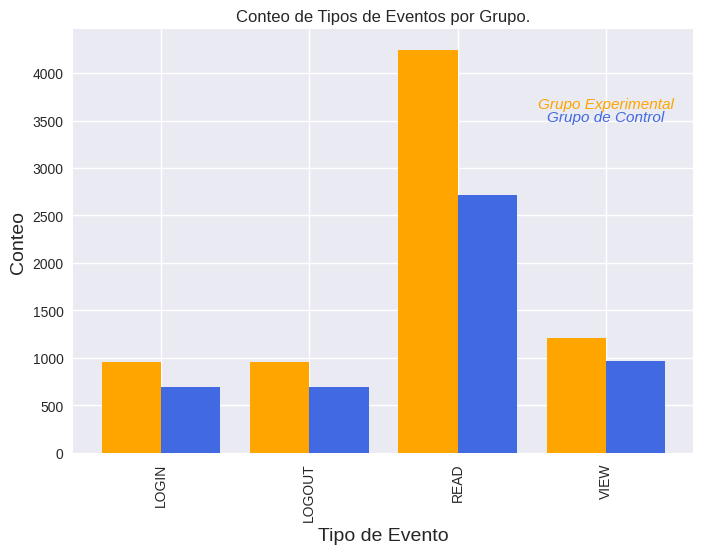

In [18]:
plt.style.use('seaborn')
ax = dif_eventos_exp['USERID'].plot(kind="bar", width=-0.4, rot=0, stacked=True, align='edge', color="orange")
dif_eventos_ctrl['USERID'].plot(ax=ax, width=0.4, kind="bar",align='edge', color="royalblue")
ax.set_xticklabels(dif_eventos_exp['TIPO EVENTO'])
ax.set_ylabel('Conteo', fontsize = 14)
ax.set_xlabel('Tipo de Evento', fontsize = 14)
# ax.legend(title='DataFrame')
ax.set_title('Conteo de Tipos de Eventos por Grupo.')
ax.text(3, 3540, "Grupo de Control",
       fontsize = 11,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "royalblue",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
ax.text(3, 3670, "Grupo Experimental",
       fontsize = 11,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "orange",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
plt.autoscale(enable=True, axis='x')
plt.show()

In [19]:
for i in range(len(dif_eventos_exp)):
  porcentaje = round((dif_eventos_ctrl['USERID'].iloc[i-1]*100)/dif_eventos_exp['USERID'].iloc[i-1],2)
  print('El evento', dif_eventos_exp['TIPO EVENTO'].iloc[i-1], 'del grupo de control supone un ', porcentaje, '% siendo el 100 % lo recogido en el grupo experimental.')
  print('Que se corresponde con', dif_eventos_ctrl['USERID'].iloc[i-1],'registros obtenidos del grupo de control y', dif_eventos_exp['USERID'].iloc[i-1], 'del grupo experimental.\n')

El evento VIEW del grupo de control supone un  80.43 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 970 registros obtenidos del grupo de control y 1206 del grupo experimental.

El evento LOGIN del grupo de control supone un  72.58 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 696 registros obtenidos del grupo de control y 959 del grupo experimental.

El evento LOGOUT del grupo de control supone un  72.64 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 693 registros obtenidos del grupo de control y 954 del grupo experimental.

El evento READ del grupo de control supone un  63.87 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 2712 registros obtenidos del grupo de control y 4246 del grupo experimental.



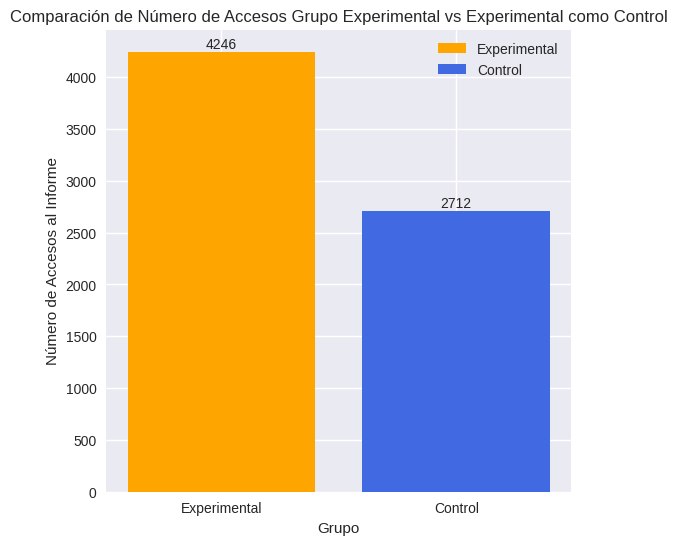

In [20]:
# Suponiendo que 'accesos_gr_ctrl' es tu DataFrame que ya contiene los datos divididos en grupos.
# Filtrar para incluir solo eventos 'READ'
read_eventos_exp = (accesos_gr_exp[accesos_gr_exp['TIPO EVENTO'] == 'READ'])['USERID'].count()
read_eventos_ctrl = (accesos_gr_ctrl[accesos_gr_ctrl['TIPO EVENTO'] == 'READ'])['USERID'].count()

eventos = {'Experimental': read_eventos_exp, 'Control': read_eventos_ctrl}
grupos = list(eventos.keys())
valores = list(eventos.values())

# Crear el gráfico
plt.figure(figsize=(6, 6))
barras = plt.bar(grupos, valores, color=['orange', 'royalblue'])

# Añadir los números de eventos encima de cada barra
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.xlabel('Grupo')
plt.ylabel('Número de Accesos al Informe')
plt.title('Comparación de Número de Accesos Grupo Experimental vs Experimental como Control')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

#####Grupo Experimental (1º Trim VS 2º Trim)

<ipython-input-21-6b318c255db5>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


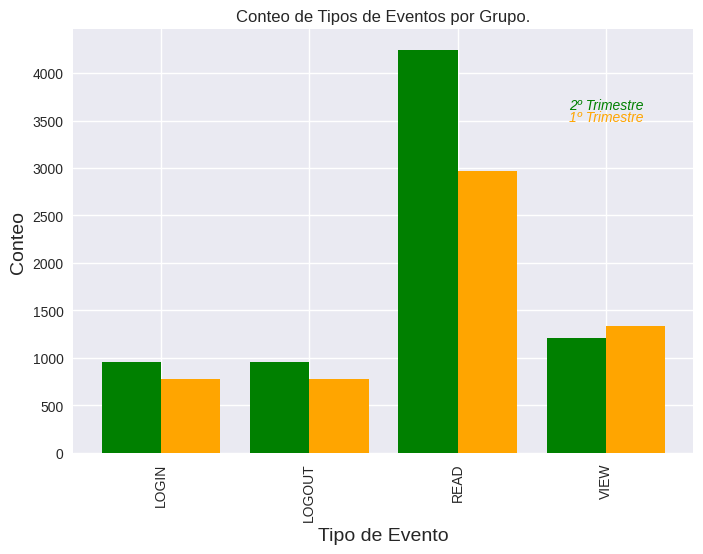

In [21]:
plt.style.use('seaborn')
ax = dif_eventos_exp['USERID'].plot(kind="bar", width=-0.4, rot=0, stacked=True, align='edge', color="green")
dif_eventos_ctrl1_2['USERID'].plot(ax=ax, width=0.4, kind="bar",align='edge', color="orange")
ax.set_xticklabels(dif_eventos_exp['TIPO EVENTO'])
ax.set_ylabel('Conteo', fontsize = 14)
ax.set_xlabel('Tipo de Evento', fontsize = 14)
# ax.legend(title='DataFrame')
ax.set_title('Conteo de Tipos de Eventos por Grupo.')
ax.text(3, 3540, "1º Trimestre",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "orange",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
ax.text(3, 3660, "2º Trimestre",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "green",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
plt.autoscale(enable=True, axis='x')
plt.show()

Vamos a contemplar que el grupo experimental es el 100% (la totalidad) para ver las diferencias porcentuales con el grupo de control.

Y sacamos en otra frase a qué número exacto corresponden estos porcentajes.

In [22]:
# Grupo exp como ctrl_2
for i in range(len(dif_eventos_exp)):
  porcentaje = round((dif_eventos_ctrl1_2['USERID'].iloc[i-1]*100)/dif_eventos_exp['USERID'].iloc[i-1],2)
  print('El evento', dif_eventos_exp['TIPO EVENTO'].iloc[i-1], 'del grupo experimental como grupo de control supone un ', porcentaje, '% siendo el 100 % lo recogido en el grupo experimental.')
  print('Que se corresponde con', dif_eventos_ctrl1_2['USERID'].iloc[i-1],'registros obtenidos del grupo como control y', dif_eventos_exp['USERID'].iloc[i-1], 'del grupo como experimental.\n')

El evento VIEW del grupo experimental como grupo de control supone un  110.61 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 1334 registros obtenidos del grupo como control y 1206 del grupo como experimental.

El evento LOGIN del grupo experimental como grupo de control supone un  81.54 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 782 registros obtenidos del grupo como control y 959 del grupo como experimental.

El evento LOGOUT del grupo experimental como grupo de control supone un  81.87 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 781 registros obtenidos del grupo como control y 954 del grupo como experimental.

El evento READ del grupo experimental como grupo de control supone un  69.85 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 2966 registros obtenidos del grupo como control y 4246 del grupo como experimental.



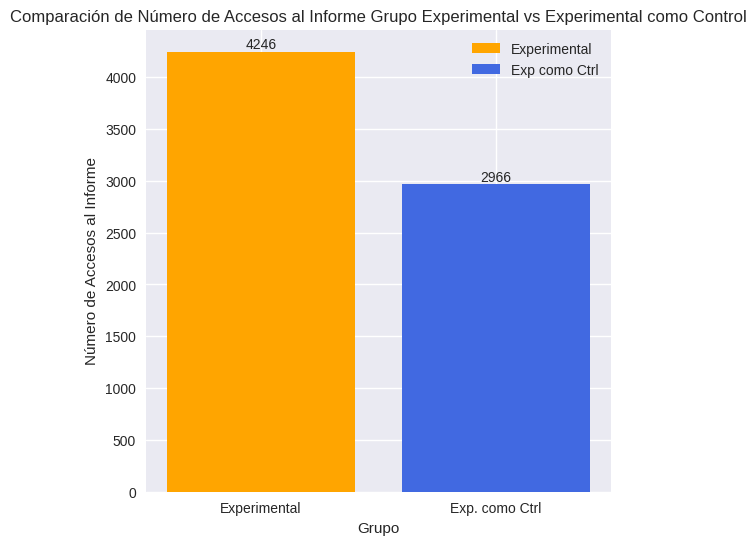

In [23]:
# Suponiendo que 'accesos_gr_ctrl' es tu DataFrame que ya contiene los datos divididos en grupos.
# Filtrar para incluir solo eventos 'READ'
read_eventos_exp = (accesos_gr_exp[accesos_gr_exp['TIPO EVENTO'] == 'READ'])['USERID'].count()
read_eventos_ctrl1_2 = (accesos_gr_ctrl1_2[accesos_gr_ctrl1_2['TIPO EVENTO'] == 'READ'])['USERID'].count()

eventos = {'Experimental': read_eventos_exp, 'Exp. como Ctrl': read_eventos_ctrl1_2}
grupos = list(eventos.keys())
valores = list(eventos.values())

# Crear el gráfico
plt.figure(figsize=(6, 6))
barras = plt.bar(grupos, valores, color=['orange', 'royalblue'])

# Añadir los números de eventos encima de cada barra
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.xlabel('Grupo')
plt.ylabel('Número de Accesos al Informe')
plt.title('Comparación de Número de Accesos al Informe Grupo Experimental vs Experimental como Control')
plt.legend([barras[0], barras[1]], ['Experimental', 'Exp como Ctrl'])
plt.show()

###Diferencias Tipo Evento - Sucursal
Medimos cuál es el impacto, número de veces que se producen, de cada tipo de evento en cada sucursal (por un lado del grupo experimental y por otro del grupo de control).

In [24]:
import plotly.express as px

dif_sucursales_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_sucursales_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

OJOOOOO, CAMBIAR LO DE VIEW, HAY QUE SACAR BIEN EL TIPO DE EVENTO Y LA SUCURSAL, EN FUNCIÓN DEL MÁXIMO CONSEGUIDO.

In [25]:
print('El evento con más registros es', max(dif_sucursales_exp['TIPO EVENTO']),'en la sucursal', max(dif_sucursales_exp['SUCURSAL']), 'con un total de', max(dif_sucursales_exp['USERID']))

El evento con más registros es VIEW en la sucursal 0512 - VENTAS con un total de 691


In [26]:
dif_suc_prueba = prueba.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_suc_prueba, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [27]:
dif_sucursales_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_sucursales_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

IGUAL QUE ARRIBA, ESTÁ MAAAAAAAAAAAL

In [28]:
print('El evento con más registros es', max(dif_sucursales_ctrl['TIPO EVENTO']),'en la sucursal', max(dif_sucursales_ctrl['SUCURSAL']), 'con un total de', max(dif_sucursales_ctrl['USERID']))

El evento con más registros es VIEW en la sucursal 0718 - VALDEMORO con un total de 548


In [29]:
# Grupo exp como ctrl
dif_sucursales_ctrl1_2 = accesos_gr_ctrl1_2.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(dif_sucursales_ctrl1_2, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

####Cambio sucursales por puntos de venta
Sacamos el mismo estudio para los puntos de venta (PV) en vez de las sucursales.

In [30]:
dif_PV_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'PV'], as_index=False).count()

fig = px.scatter(dif_PV_exp, y="TIPO EVENTO", x="PV", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

###Diferencia de accesos por tipología de agente
Medimos cuál es el impacto que tiene cada tipo de agente en los eventos, ¿están accediendo más los agentes en formación (16) o los estándar (37)?

In [31]:
dif_tipologia_prueba = prueba.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()

fig = px.scatter(dif_tipologia_prueba, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [32]:
dif_tipologia_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()

fig = px.scatter(dif_tipologia_exp, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [33]:
dif_tipologia_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()
fig = px.scatter(dif_tipologia_ctrl, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [34]:
# Grupo exp como ctrl
dif_tipologia_ctrl1_2 = accesos_gr_ctrl1_2.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()
fig = px.scatter(dif_tipologia_ctrl1_2, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

###Agentes en Formación usando los informes
En esta parte del código, vemos qué agentes (del grupo experimental) en formación están usando los informes por sucursal. Código para estar al tanto de cómo ha sido la formación en cascada.

In [35]:
df_for = Gr1[Gr1["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_exp = pd.merge(accesos_usuarios_df, df_for, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for_exp = accesos_for_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_for_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes en formación dentro del grupo experimental para saber si están entrando agentes de todas ellas. Observamos que hay 11, luego ya han accedido desde todas.

In [36]:
df_for['SUCURSAL'].unique()

array(['0004 - ALCALA DE HENARES', '0212 - MADRID-G.B.', '0215 - VAGUADA',
       '0222 - VILLALBA', '0233 - ALCOBENDAS', '0234 - COSLADA',
       '0242 - LAS ROSAS', '0278 - MADRID-HORTALEZA',
       '0332 - TORREJON DE ARDOZ', '0462 - LAS ROZAS', '0512 - VENTAS'],
      dtype=object)

####Para el grupo de control
Uso de informes para los agentes en formación del grupo de control. ¿Cuánto usan Callidus los agentes en formación sin informes nuevos relevantes?

In [37]:
df2_for = Gr2[Gr2["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_ctrl = pd.merge(accesos_usuarios_df, df2_for, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for_ctrl = accesos_for_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_for_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes en formación dentro del grupo de control para saber si están entrando agentes de todas ellas. Observamos que hay 12 y solo se ha accedido desde 9 **(cambiar diariamente si esto cambia)**.

In [38]:
df2_for['SUCURSAL'].unique()

array(['0018 - ARANJUEZ', '0214 - MOSTOLES', '0218 - FUENLABRADA',
       '0220 - LEGANES', '0221 - ALCORCON', '0223 - PARLA',
       '0255 - GETAFE', '0277 - MADRID-BUENAVISTA', '0312 - VALLECAS',
       '0412 - CARABANCHEL', '0442 - MADRID-CIUDAD DE LOS ANGELES',
       '0718 - VALDEMORO'], dtype=object)

In [39]:
# Grupo exp como ctrl
df1_2_for = Gr1_2[Gr1_2["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_ctrl1_2 = pd.merge(aud_gr1_2, df1_2_for, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for_ctrl1_2 = accesos_for_ctrl1_2.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_for_ctrl1_2, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

6 sucursales de 11 **(CAMBIAR SI SE COGEN MÁS MESE ATRÁS Y VARÍA)**.

In [40]:
df1_2_for['SUCURSAL'].unique()

array(['0004 - ALCALA DE HENARES', '0212 - MADRID-G.B.', '0215 - VAGUADA',
       '0222 - VILLALBA', '0233 - ALCOBENDAS', '0234 - COSLADA',
       '0242 - LAS ROSAS', '0278 - MADRID-HORTALEZA',
       '0332 - TORREJON DE ARDOZ', '0462 - LAS ROZAS', '0512 - VENTAS'],
      dtype=object)

###Agentes Estándar usando los informes
En esta parte del código, vemos qué agentes (del grupo experimental) de tipo estándar, están usando los informes por sucursal. Código para comparar con los de formación y ver si es mejor contar de primera mano la información o la formación en cascada y, medir qué tipología de agente encuentra más relevante los informes.

In [41]:
df_est_prueba = Gr2[Gr2["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_prueba = pd.merge(aud_gr1_2, df_est_prueba, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_prueba = accesos_est_prueba.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_prueba, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [42]:
df_est = Gr1[Gr1["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_exp = pd.merge(accesos_usuarios_df, df_est, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_exp = accesos_est_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes estándar dentro del grupo experimental para saber si están entrando agentes de todas ellas. Observamos que hay 10, ya han entrado todos.

In [43]:
df_est['SUCURSAL'].unique()

array(['0004 - ALCALA DE HENARES', '0212 - MADRID-G.B.', '0215 - VAGUADA',
       '0222 - VILLALBA', '0233 - ALCOBENDAS', '0234 - COSLADA',
       '0242 - LAS ROSAS', '0278 - MADRID-HORTALEZA',
       '0332 - TORREJON DE ARDOZ', '0462 - LAS ROZAS'], dtype=object)

Voy a sacar el número de agentes que hay en esta sucursal, para saber si es importante esta falta de accesos o no. Hay dos agentes en esta sucursal, no supone mucho impacto.

In [44]:
# vaguada_est = df_est[df_est['SUCURSAL'].str.contains('VAGUADA')]

# vaguada_est

####Para el grupo de control
Uso de informes para los agentes estándar del grupo de control. ¿Cuánto usan Callidus estos agentes sin informes nuevos relevantes? ¿Usan Callidus como herramienta de ayuda?

In [45]:
df2_est = Gr2[Gr2["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_ctrl = pd.merge(accesos_usuarios_df, df2_est, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_ctrl = accesos_est_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

Vemos en cuántas (y cuáles son) sucursales hay agentes estándar dentro del grupo de control para saber si están entrando agentes de todas ellas. Observamos que hay 11 y solo se ha accedido desde 9 sucursales **(cambiar si se modifica)**.

In [46]:
df2_est['SUCURSAL'].unique()

array(['0214 - MOSTOLES', '0218 - FUENLABRADA', '0220 - LEGANES',
       '0221 - ALCORCON', '0223 - PARLA', '0255 - GETAFE',
       '0277 - MADRID-BUENAVISTA', '0312 - VALLECAS',
       '0412 - CARABANCHEL', '0442 - MADRID-CIUDAD DE LOS ANGELES'],
      dtype=object)

In [47]:
# Grupo exp como ctrl
df1_2_est = Gr1_2[Gr1_2["TIPOLOGIA"].str.contains("ESTANDAR")]

accesos_est_ctrl1_2 = pd.merge(aud_gr1_2, df1_2_est, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_est_ctrl1_2 = accesos_est_ctrl1_2.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

fig = px.scatter(df_est_ctrl1_2, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

###Impacto por agente
¿Cuántos agentes del grupo experimental están haciendo uso de los informes? ¿Cuáles de ellos acceden a Callidus? ¿Es un número alto?

Primero para los agentes en formación del grupo experimental.

In [48]:
agentes_est_prueba = prueba.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_prueba, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.update_layout(
    width=2100,  # Ancho de la figura
    height=500  # Altura de la figura
)
fig.show()

In [49]:
agentes_for_exp = accesos_for_exp.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_for_exp, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.update_layout(
    width=2000,  # Ancho de la figura
    height=500  # Altura de la figura
)
fig.show()

In [50]:
# # CODIGO PARA ENCONTRAR AGENTES CONCRETOS
# agente = Gr2[Gr2["NOMBRE"].str.contains("ALICIA")]
# agente

In [51]:
agentes_est_exp = accesos_est_exp.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_exp, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.update_layout(
    width=1800,  # Ancho de la figura
    height=500  # Altura de la figura
)
fig.show()

Agentes por sucursal, formación y estándar juntos.

In [52]:
agentes_for_exp = accesos_for_exp.groupby(by=['NOMBRE USUARIO', 'SUCURSAL'], as_index=False).count()
agentes_est_exp = accesos_est_exp.groupby(by=['NOMBRE USUARIO', 'SUCURSAL'], as_index=False).count()
agentes_for_ctrl = accesos_for_ctrl.groupby(by=['NOMBRE USUARIO', 'SUCURSAL'], as_index=False).count()
agentes_est_ctrl = accesos_est_ctrl.groupby(by=['NOMBRE USUARIO', 'SUCURSAL'], as_index=False).count()

import plotly.graph_objects as go

fig = go.Figure()

# Añadir la primera traza para los datos del establecimiento
fig.add_trace(go.Scatter(
    x=agentes_est_exp['SUCURSAL'],
    y=agentes_est_exp['USERID'],
    mode='markers',  # Modo de puntos
    marker=dict(size=8, color='royalblue'),  # Controlar el tamaño y color de los puntos
    name='ESTÁNDAR EXP'  # Nombre de la leyenda
))

# Añadir la segunda traza para los datos foráneos
fig.add_trace(go.Scatter(
    x=agentes_for_exp['SUCURSAL'],
    y=agentes_for_exp['USERID'],
    mode='markers',
    marker=dict(size=8, color='orange'),  # Otro color
    name='FORMACIÓN EXP'
))

# Añadir la segunda traza para los datos foráneos
fig.add_trace(go.Scatter(
    x=agentes_for_ctrl['SUCURSAL'],
    y=agentes_for_ctrl['USERID'],
    mode='markers',
    marker=dict(size=8, color='orange', symbol='x'),  # Otro color
    name='FORMACIÓN CTRL'
))

# Añadir la segunda traza para los datos foráneos
fig.add_trace(go.Scatter(
    x=agentes_est_ctrl['SUCURSAL'],
    y=agentes_est_ctrl['USERID'],
    mode='markers',
    marker=dict(size=8, color='royalblue', symbol='x'),  # Otro color
    name='ESTÁNDAR CTRL'
))

# Actualizar el layout para añadir título y mejorar la presentación
fig.update_layout(
    title='Accesos Grupo Experimental por Usuario y Sucursal',
    xaxis_title='Sucursal',
    yaxis_title='Número de Accesos',
    legend_title='Tipo de Usuario',
    width=1700,  # Ancho de la figura
    height=1100  # Altura de la figura
)

# Mostrar el gráfico
fig.show()

Cuántos agentes están usando los informes, por tipología y en su totalidad.

Totalidad de agentes en el grupo experimental y según la tipología.

In [53]:
print('Hay', agentes_for_exp['NOMBRE USUARIO'].nunique(), 'agentes en formación del grupo experimental usando los informes y', agentes_est_exp['NOMBRE USUARIO'].nunique(), 'agentes estándar, es decir, un total de', agentes_for_exp['NOMBRE USUARIO'].nunique() + agentes_est_exp['NOMBRE USUARIO'].nunique(), 'agentes.')
print('Hay', df_for['NOMBRE'].nunique(), 'agentes en formación y', df_est['NOMBRE'].nunique(), 'agentes estándar en el grupo experimental, es decir, un total de', df_for['NOMBRE'].nunique() + df_est['NOMBRE'].nunique(), 'agentes.')

Hay 30 agentes en formación del grupo experimental usando los informes y 23 agentes estándar, es decir, un total de 53 agentes.
Hay 51 agentes en formación y 28 agentes estándar en el grupo experimental, es decir, un total de 79 agentes.


Medimos porcentualmente qué representan estos datos.

In [54]:
dif_for_exp = round((100*agentes_for_exp['NOMBRE USUARIO'].nunique())/df_for['NOMBRE'].nunique(),2)

dif_est_exp = round((100*agentes_est_exp['NOMBRE USUARIO'].nunique())/df_est['NOMBRE'].nunique(),2)

total_usando = agentes_for_exp['NOMBRE USUARIO'].nunique() + agentes_est_exp['NOMBRE USUARIO'].nunique()
total_exp = (df_for['NOMBRE'].nunique() + df_est['NOMBRE'].nunique())

dif_total_exp = round((100*total_usando)/total_exp,2)

print('Hay', dif_for_exp, '% de agentes en formación y', dif_est_exp, '% agentes estándar usando los informes, es decir, un total de', dif_total_exp, '% de agentes.')

Hay 58.82 % de agentes en formación y 82.14 % agentes estándar usando los informes, es decir, un total de 67.09 % de agentes.


####Para el grupo de control

In [55]:
agentes_for_ctrl = accesos_for_ctrl.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_for_ctrl, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.update_layout(
    width=1800,  # Ancho de la figura
    height=500  # Altura de la figura
)
fig.show()

In [56]:
agentes_est_ctrl = accesos_est_ctrl.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_ctrl, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.update_layout(
    width=1500,  # Ancho de la figura
    height=500  # Altura de la figura
)
fig.show()

In [57]:
agente = Gr2[Gr2["NOMBRE"].str.contains("IRENE")]
agente

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA,E-MAIL,MAIL PERSONAL


In [58]:
print('Hay', agentes_for_ctrl['NOMBRE USUARIO'].nunique(), 'agentes en formación usando Callidus del grupo de control y', agentes_est_ctrl['NOMBRE USUARIO'].nunique(), 'agentes estándar, es decir, un total de', agentes_for_ctrl['NOMBRE USUARIO'].nunique() + agentes_est_ctrl['NOMBRE USUARIO'].nunique(), 'agentes.')
print('Hay', df2_for['NOMBRE'].nunique(), 'agentes en formación y', df2_est['NOMBRE'].nunique(), 'agentes estándar en el grupo de control, es decir, un total de', df2_for['NOMBRE'].nunique() + df2_est['NOMBRE'].nunique(), 'agentes.')

Hay 31 agentes en formación usando Callidus del grupo de control y 15 agentes estándar, es decir, un total de 46 agentes.
Hay 65 agentes en formación y 18 agentes estándar en el grupo de control, es decir, un total de 83 agentes.


Medimos los porcentajes.

In [59]:
dif_for_ctrl = round((100*agentes_for_ctrl['NOMBRE USUARIO'].nunique())/df2_for['NOMBRE'].nunique(),2)

dif_est_ctrl = round((100*agentes_est_ctrl['NOMBRE USUARIO'].nunique())/df2_est['NOMBRE'].nunique(),2)

total_usando_ctrl = agentes_for_ctrl['NOMBRE USUARIO'].nunique() + agentes_est_ctrl['NOMBRE USUARIO'].nunique()
total_ctrl = (df2_for['NOMBRE'].nunique() + df2_est['NOMBRE'].nunique())

dif_total_ctrl = round((100*total_usando_ctrl)/total_ctrl,2)

print('Hay', dif_for_ctrl, '% de agentes en formación y', dif_est_ctrl, '% agentes estándar usando Callidus del grupo de control, es decir, un total de', dif_total_ctrl, '% de agentes.')

Hay 47.69 % de agentes en formación y 83.33 % agentes estándar usando Callidus del grupo de control, es decir, un total de 55.42 % de agentes.


In [60]:
# Grupo exp como ctrl
agentes_for_ctrl1_2 = accesos_for_ctrl1_2.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_for_ctrl1_2, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.update_layout(
    width=1500,  # Ancho de la figura
    height=500  # Altura de la figura
)
fig.show()

In [61]:
# Grupo exp como ctrl
agentes_est_ctrl1_2 = accesos_est_ctrl1_2.groupby(by=['NOMBRE USUARIO'], as_index=False).count()

fig = px.scatter(agentes_est_ctrl1_2, y="USERID", x="NOMBRE USUARIO")
fig.update_traces(marker_size=8)
fig.update_layout(
    width=1500,  # Ancho de la figura
    height=500  # Altura de la figura
)
fig.show()

In [62]:
print('Hay', agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique(), 'agentes en formación usando Callidus del grupo experimental como grupo de control y', agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique(), 'agentes estándar, es decir, un total de', agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique() + agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique(), 'agentes.')
print('Hay', df1_2_for['NOMBRE'].nunique(), 'agentes en formación y', df1_2_est['NOMBRE'].nunique(), 'agentes estándar en el grupo experimental como grupo de control, es decir, un total de', df1_2_for['NOMBRE'].nunique() + df1_2_est['NOMBRE'].nunique(), 'agentes.')

Hay 32 agentes en formación usando Callidus del grupo experimental como grupo de control y 27 agentes estándar, es decir, un total de 59 agentes.
Hay 51 agentes en formación y 28 agentes estándar en el grupo experimental como grupo de control, es decir, un total de 79 agentes.


In [63]:
dif_for_ctrl1_2 = round((100*agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique())/df1_2_for['NOMBRE'].nunique(),2)

dif_est_ctrl1_2 = round((100*agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique())/df1_2_est['NOMBRE'].nunique(),2)

total_usando_ctrl1_2 = agentes_for_ctrl1_2['NOMBRE USUARIO'].nunique() + agentes_est_ctrl1_2['NOMBRE USUARIO'].nunique()
total_ctrl1_2 = (df1_2_for['NOMBRE'].nunique() + df1_2_est['NOMBRE'].nunique())

dif_total_ctrl1_2 = round((100*total_usando_ctrl1_2)/total_ctrl1_2,2)

print('Hay', dif_for_ctrl1_2, '% de agentes en formación y', dif_est_ctrl1_2, '% agentes estándar usando Callidus del grupo experimental como control, es decir, un total de', dif_total_ctrl1_2, '% de agentes.')

Hay 62.75 % de agentes en formación y 96.43 % agentes estándar usando Callidus del grupo experimental como control, es decir, un total de 74.68 % de agentes.


###Medimos las Bajas
Vamos a ver los agentes de ambos grupos que se han dado de baja hasta el momento, a partir del 1.18 la parte de agentes inactivos que será subida diariamente.

####Bajas de los agentes del grupo experimental

In [64]:
bajas_exp = Gr1[Gr1['NOMBRE'].isin(bajas['NOMBRE'].unique())]

Gr1_bajas_exp = bajas[bajas['NOMBRE'].isin(Gr1['NOMBRE'].unique())]

bajas_exp

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA,E-MAIL,MAIL PERSONAL
1184,0004 - ALCALA DE HENARES,0004 - ALCALA DE HENARES,4,2444,09249523G0000,09249523G0000,09249523G,HUGO VALLE PEREZ,16 - AGENTE EN FORMACION,2023-10-05,HUGOVALLE200571@GMAIL.COM,NaN
1185,0004 - ALCALA DE HENARES,0004 - ALCALA DE HENARES,4,2445,49226591J0000,49226591J0000,49226591J,MARIA GARCIA ROSA,16 - AGENTE EN FORMACION,2023-12-05,MARIAGARCIAROSA14@GMAIL.COM,NaN
1186,0004 - ALCALA DE HENARES,0004 - ALCALA DE HENARES,4,2446,09026229V0000,09026229V0000,09026229V,MARIA RUTH MARTIN HIDALGO,16 - AGENTE EN FORMACION,2023-12-07,M.MARTINRUTH@GMAIL.COM,NaN
1187,0004 - ALCALA DE HENARES,0004 - ALCALA DE HENARES,4,2447,05424453H0000,05424453H0000,05424453H,BEATRIZ FERNANDEZ TENA,16 - AGENTE EN FORMACION,2024-01-15,BEATRIZFT.45@GMAIL.COM,NaN
1188,0004 - ALCALA DE HENARES,0004 - ALCALA DE HENARES,4,2448,Y8838814C0000,Y8838814C0000,Y8838814C,YANNERIS FERNANDEZ RODRIGUEZ,16 - AGENTE EN FORMACION,2024-01-16,YANNERIS.FERNANDEZ@GMAIL.COM,NaN
1597,0212 - MADRID-G.B.,0212 - MADRID-G.B.,212,9747,60142919N0000,60142919N0000,60142919N,YHORUSKA GIONNELLY CASTRO LOVERA,16 - AGENTE EN FORMACION,2023-09-19,CASTROYHORUSKAGL@GMAIL.COM,NaN
1653,0215 - VAGUADA,0215 - VAGUADA,215,9280,09092425L0000,09092425L0000,09092425L,JACOBO DIAZ MAZO,16 - AGENTE EN FORMACION,2023-10-19,JDIAZMAZO@GMAIL.COM,NaN
1730,0222 - VILLALBA,0222 - VILLALBA,222,9456,Z0570388Q0000,Z0570388Q0000,Z0570388Q,PAULA ANDREA ALVAREZ VASQUEZ,16 - AGENTE EN FORMACION,2023-12-05,PAO7801@GMAIL.COM,NaN
1824,0233 - ALCOBENDAS,0475 - TRES CANTOS,475,5679,06590490R0000,06590490R0000,06590490R,ROBERTO PUYAL GARCIA,16 - AGENTE EN FORMACION,2024-03-14,RPUYALGARCIA@GMAIL.COM,NaN
1896,0234 - COSLADA,0427 - ARGANDA DEL REY,427,6362,Y7722758Q0000,Y7722758Q0000,Y7722758Q,OLGA ELISA CHAVARRI,16 - AGENTE EN FORMACION,2024-03-19,OLGAEC.TALLER@GMAIL.COM,NaN


#####Porcentaje Bajas
A qué porcentaje corresponde el número de bajas, contando con que el total es el número inicial de agentes que había en el grupo experimental.

In [65]:
agentes_actuales_exp = Gr1.shape[0] - bajas_exp.shape[0]
print('El número total de agentes inicial en el grupo era de', Gr1.shape[0], 'agentes y se han dado de baja', bajas_exp.shape[0], 'por lo que quedan', agentes_actuales_exp, 'agentes.')
print('Esto se corresponde a un', round((bajas_exp.shape[0]*100)/Gr1.shape[0], 2), '% de bajas, quedando un', round((agentes_actuales_exp*100)/Gr1.shape[0], 2),'% del 100 % inicial.')

El número total de agentes inicial en el grupo era de 79 agentes y se han dado de baja 13 por lo que quedan 66 agentes.
Esto se corresponde a un 16.46 % de bajas, quedando un 83.54 % del 100 % inicial.


In [66]:
Gr1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 1180 to 2290
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUCURSAL              79 non-null     object        
 1   OFICINA               79 non-null     object        
 2   PV                    79 non-null     int64         
 3   CODIGO                79 non-null     int64         
 4   COD. CALLIDUS/SOLNET  79 non-null     object        
 5   LDAP                  79 non-null     object        
 6   NIF                   79 non-null     object        
 7   NOMBRE                79 non-null     object        
 8   TIPOLOGIA             79 non-null     object        
 9   F.ALTA                79 non-null     datetime64[ns]
 10  E-MAIL                79 non-null     object        
 11  MAIL PERSONAL         10 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 8.0+ KB


In [67]:
# Correos para mandar el cuestionario de satisfacción a los agentes del grupo experimental
agentes_exclusivos_de_Gr1 = Gr1[~Gr1['LDAP'].isin(bajas_exp['LDAP'])]

correos_exp = agentes_exclusivos_de_Gr1[['E-MAIL', 'MAIL PERSONAL']]
columnas = ['E-MAIL', 'MAIL PERSONAL']

for columna in columnas:
    correos_exp[columna] = correos_exp[columna].str.lower()
correos_exp.to_excel('correos_grupo_experimental.xlsx', index=False, engine='openpyxl')

<ipython-input-67-b22365429bcf>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



####Bajas de los agentes del grupo de control

In [68]:
bajas_ctrl = Gr2[Gr2['NOMBRE'].isin(bajas['NOMBRE'].unique())]

Gr2_bajas_ctrl = bajas[bajas['NOMBRE'].isin(Gr2['NOMBRE'].unique())]

bajas_ctrl

,SUCURSAL,OFICINA,PV,CODIGO,COD. CALLIDUS/SOLNET,LDAP,NIF,NOMBRE,TIPOLOGIA,F.ALTA,E-MAIL,MAIL PERSONAL
5,0214 - MOSTOLES,0214 - MOSTOLES,214,9699,47285226D0000,47285226D0000,47285226D,PABLO GARCIA DE LA INFANTA CARPIO,16 - AGENTE EN FORMACION,2023-09-12,PABLOG.CLOSER@GMAIL.COM,NaN
6,0214 - MOSTOLES,0214 - MOSTOLES,214,9705,47475187J0000,47475187J0000,47475187J,KEVIN TRYCHAN AGUILAR,16 - AGENTE EN FORMACION,2024-03-18,KENDRATRYCHAN@GMAIL.COM,NaN
7,0214 - MOSTOLES,0214 - MOSTOLES,214,9707,20261366E0000,20261366E0000,20261366E,JULIO PINEIRO TOME,16 - AGENTE EN FORMACION,2024-04-10,ELPINE13RM@GMAIL.COM,NaN
10,0218 - FUENLABRADA,0218 - FUENLABRADA,218,9007,02331742W0000,02331742W0000,02331742W,MARIA ARACELI JIMENEZ JIMENEZ,16 - AGENTE EN FORMACION,2024-03-18,MAJ3110@GMAIL.COM,NaN
16,0218 - FUENLABRADA,0218 - FUENLABRADA,218,9992,Y6640879B0000,Y6640879B0000,Y6640879B,DANIELA YANILETH CAICEDO RODIRUGEZ,16 - AGENTE EN FORMACION,2023-07-31,DANIELACAICEDO25@GMAIL.COM,NaN
18,0220 - LEGANES,0220 - LEGANES,220,9000,14077527D0000,14077527D0000,14077527D,YRIS DEL CARMEN GAMBOA GONZALEZ,16 - AGENTE EN FORMACION,2024-03-18,YRISGAMBOA@GMAIL.COM,NaN
27,0221 - ALCORCON,0221 - ALCORCON,221,9738,51538791T0000,51538791T0000,51538791T,LAURA NOUR SANCHEZ BOTELLA,16 - AGENTE EN FORMACION,2024-02-15,LAURASZ0320@GMAIL.COM,NaN
30,0221 - ALCORCON,0221 - ALCORCON,221,9741,70825956D0000,70825956D0000,70825956D,BEATRIZ CISNEROS MATE,16 - AGENTE EN FORMACION,2024-04-03,BEAPODA@GMAIL.COM,NaN
31,0221 - ALCORCON,0221 - ALCORCON,221,9742,Z1329883M0000,Z1329883M0000,Z1329883M,GENESIS STEFANIA DEMERA NAVARRO,16 - AGENTE EN FORMACION,2024-04-10,STEFIDEMERANA@GMAIL.COM,NaN
35,0223 - PARLA,0223 - PARLA,223,9736,52184188V0000,52184188V0000,52184188V,ANA MARIA SANTOS GARGALLO,16 - AGENTE EN FORMACION,2023-12-13,AMARIASAN69@GMAIL.COM,NaN


#####Porcentaje Bajas
A qué porcentaje corresponde el número de bajas, contando con que el total es el número inicial de agentes que había en el grupo de control.

In [69]:
agentes_actuales_ctrl = Gr2.shape[0] - bajas_ctrl.shape[0]
print('El número total de agentes inicial en el grupo era de', Gr2.shape[0], 'agentes y se han dado de baja', bajas_ctrl.shape[0], 'por lo que quedan', agentes_actuales_ctrl, 'agentes.')
print('Esto se corresponde a un', round((bajas_ctrl.shape[0]*100)/Gr2.shape[0], 2), '% de bajas, quedando un', round((agentes_actuales_ctrl*100)/Gr2.shape[0], 2),'% del 100 % inicial.')

El número total de agentes inicial en el grupo era de 83 agentes y se han dado de baja 21 por lo que quedan 62 agentes.
Esto se corresponde a un 25.3 % de bajas, quedando un 74.7 % del 100 % inicial.


In [70]:
len(bajas_ctrl)

21

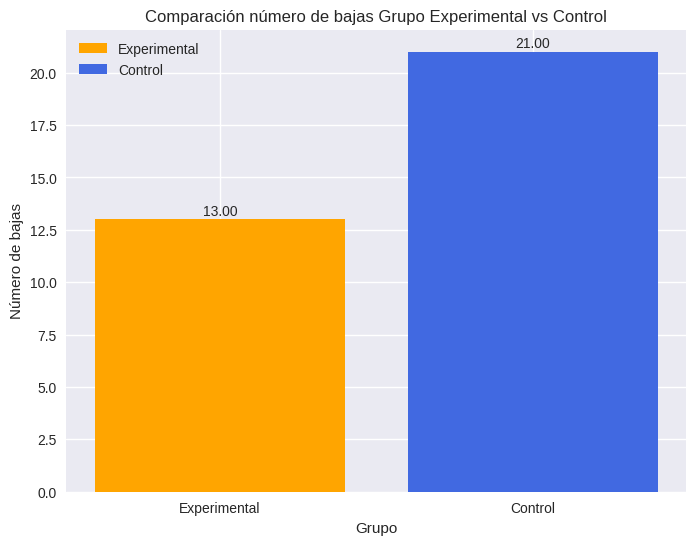

In [71]:
# Suponiendo que 'accesos_gr_ctrl' es tu DataFrame que ya contiene los datos divididos en grupos.
# Filtrar para incluir solo eventos 'READ'
num_bajas_exp = len(bajas_exp)
num_bajas_ctrl = len(bajas_ctrl)

eventos = {'Experimental': num_bajas_exp, 'Control': num_bajas_ctrl}
grupos = list(eventos.keys())
valores = list(eventos.values())

# Crear el gráfico
plt.figure(figsize=(8, 6))
barras = plt.bar(grupos, valores, color=['orange', 'royalblue'])

# Añadir los números de eventos encima de cada barra
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Grupo')
plt.ylabel('Número de bajas')
plt.title('Comparación número de bajas Grupo Experimental vs Control')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

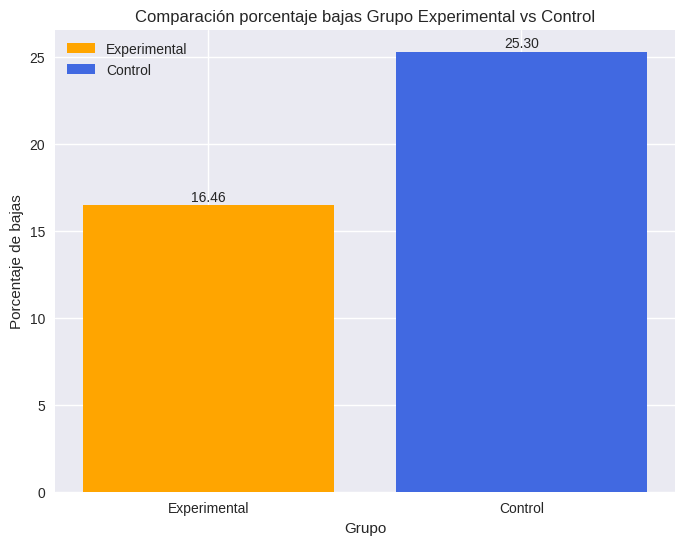

In [72]:
# Suponiendo que 'accesos_gr_ctrl' es tu DataFrame que ya contiene los datos divididos en grupos.
# Filtrar para incluir solo eventos 'READ'
por_bajas_exp = round((bajas_exp.shape[0]*100)/Gr1.shape[0], 2)
por_bajas_ctrl = round((bajas_ctrl.shape[0]*100)/Gr2.shape[0], 2)

eventos = {'Experimental': por_bajas_exp, 'Control': por_bajas_ctrl}
grupos = list(eventos.keys())
valores = list(eventos.values())

# Crear el gráfico
plt.figure(figsize=(8, 6))
barras = plt.bar(grupos, valores, color=['orange', 'royalblue'])

# Añadir los números de eventos encima de cada barra
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom')

plt.xlabel('Grupo')
plt.ylabel('Porcentaje de bajas')
plt.title('Comparación porcentaje bajas Grupo Experimental vs Control')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

###Medición de la Producción


####Pólizas Físicas y Corregidas
Comenzamos a medir las pólizas (tanto físicas como corregidas) de los agentes del grupo experimental, el de control y la producción del grupo experimental en los meses del primer trimestre.

#####Grupo Experimental (1º Trim VS 2º Trim)

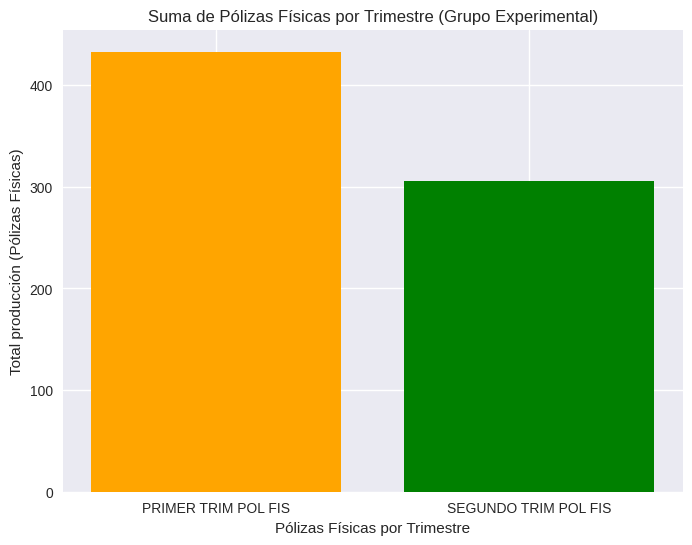

In [73]:
prod_fis_corr_exp = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(Gr1['LDAP'].unique())]

suma_fis_trim1 = prod_fis_corr_exp['PRIMER TRIM POL FIS'].sum()
suma_fis_trim2 = prod_fis_corr_exp['SEGUNDO TRIM POL FIS'].sum()

# Preparar datos para el gráfico
sumas_fis = [suma_fis_trim1, suma_fis_trim2]
columnas_fis = ['PRIMER TRIM POL FIS', 'SEGUNDO TRIM POL FIS']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis, sumas_fis, color=['orange', 'green'])
plt.xlabel('Pólizas Físicas por Trimestre')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Trimestre (Grupo Experimental)')
plt.show()

In [74]:
print('En el primer trimestre el grupo experimental hizo', suma_fis_trim1,'pólizas físicas, mientras que en el segundo', suma_fis_trim2,'.')
print('En el primer trimestre el grupo experimental hizo un 100 % pólizas físicas, mientras que en el segundo', round((100*suma_fis_trim2)/suma_fis_trim1,2),'%.')

En el primer trimestre el grupo experimental hizo 433 pólizas físicas, mientras que en el segundo 306 .
En el primer trimestre el grupo experimental hizo un 100 % pólizas físicas, mientras que en el segundo 70.67 %.


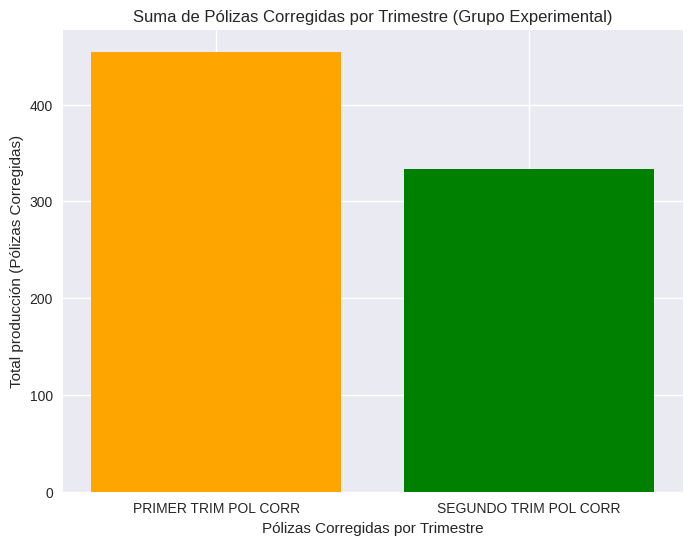

In [75]:
suma_corr_trim1 = prod_fis_corr_exp['PRIMER TRIM POL CORR'].sum()
suma_corr_trim2 = prod_fis_corr_exp['SEGUNDO TRIM POL CORR'].sum()

# Preparar datos para el gráfico
sumas_corr = [suma_corr_trim1, suma_corr_trim2]
columnas_corr = ['PRIMER TRIM POL CORR', 'SEGUNDO TRIM POL CORR']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_corr, sumas_corr, color=['orange', 'green'])
plt.xlabel('Pólizas Corregidas por Trimestre')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Trimestre (Grupo Experimental)')
plt.show()

In [76]:
print('En el primer trimestre el grupo experimental hizo', round(suma_corr_trim1),'pólizas corregidas, mientras que en el segundo', round(suma_corr_trim2,2),'.')
print('En el primer trimestre el grupo experimental hizo un 100 % pólizas corregidas, mientras que en el segundo', round((100*suma_corr_trim2)/suma_corr_trim1,2),'%.')

En el primer trimestre el grupo experimental hizo 455 pólizas corregidas, mientras que en el segundo 333.64 .
En el primer trimestre el grupo experimental hizo un 100 % pólizas corregidas, mientras que en el segundo 73.4 %.


#####Grupo de Control (1º Trim VS 2º Trim)

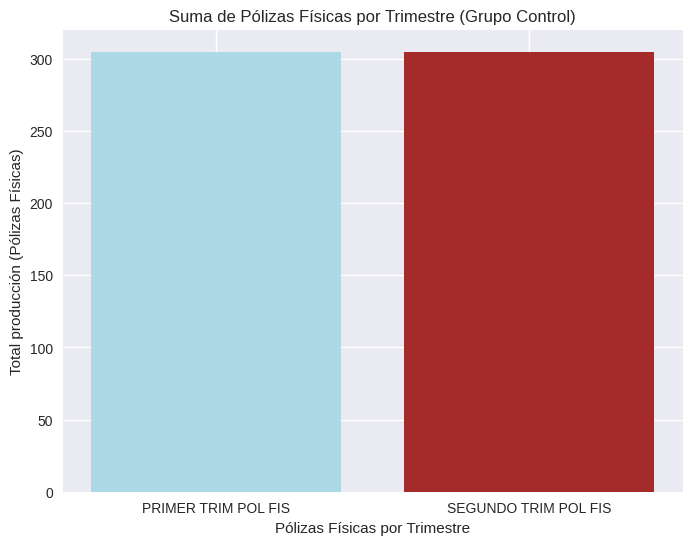

In [77]:
prod_fis_corr_ctrl = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(Gr2['LDAP'].unique())]

suma_fis_trim1_ctrl = prod_fis_corr_ctrl['PRIMER TRIM POL FIS'].sum()
suma_fis_trim2_ctrl = prod_fis_corr_ctrl['SEGUNDO TRIM POL FIS'].sum()

# Preparar datos para el gráfico
sumas_fis_ctrl = [suma_fis_trim1_ctrl, suma_fis_trim2_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis, sumas_fis_ctrl, color=['lightblue', 'brown'])
plt.xlabel('Pólizas Físicas por Trimestre')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Trimestre (Grupo Control)')
plt.show()

Comparamos los valores y contemplando que las del primer trimestre corresponden al 100% sacamos los porcentajes.

In [78]:
print('En el primer trimestre el grupo de control hizo', suma_fis_trim1_ctrl,'pólizas físicas, mientras que en el segundo', suma_fis_trim2_ctrl,'.')
print('En el primer trimestre el grupo de control hizo un 100 % pólizas físicas, mientras que en el segundo', round((100*suma_fis_trim2_ctrl)/suma_fis_trim1_ctrl,2),'%.')

En el primer trimestre el grupo de control hizo 305 pólizas físicas, mientras que en el segundo 305 .
En el primer trimestre el grupo de control hizo un 100 % pólizas físicas, mientras que en el segundo 100.0 %.


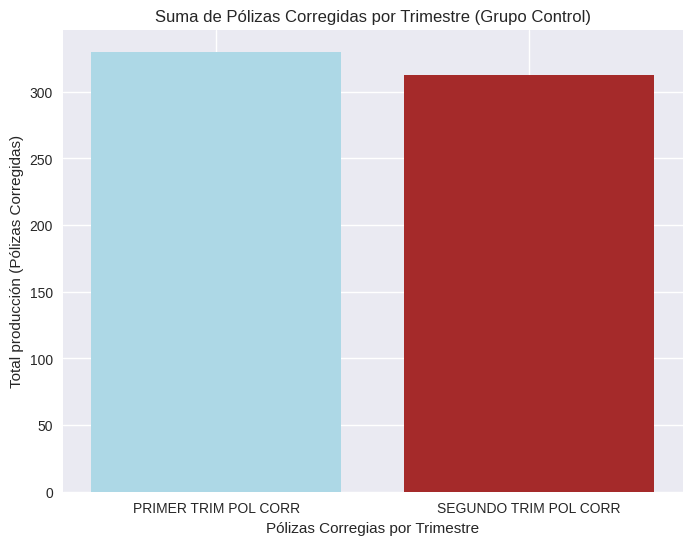

In [79]:
suma_corr_trim1_ctrl = prod_fis_corr_ctrl['PRIMER TRIM POL CORR'].sum()
suma_corr_trim2_ctrl = prod_fis_corr_ctrl['SEGUNDO TRIM POL CORR'].sum()

# Preparar datos para el gráfico
sumas_corr_ctrl = [suma_corr_trim1_ctrl, suma_corr_trim2_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_corr, sumas_corr_ctrl, color=['lightblue', 'brown'])
plt.xlabel('Pólizas Corregias por Trimestre')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Trimestre (Grupo Control)')
plt.show()

In [80]:
print('En el primer trimestre el grupo de control hizo', round(suma_corr_trim1_ctrl,2),'pólizas corregidas, mientras que en el segundo', round(suma_corr_trim2_ctrl,2),'.')
print('En el primer trimestre el grupo de control hizo un 100 % pólizas corregidas, mientras que en el segundo', round((100*suma_corr_trim2_ctrl)/suma_corr_trim1_ctrl,2),'%.')

En el primer trimestre el grupo de control hizo 330.09 pólizas corregidas, mientras que en el segundo 312.58 .
En el primer trimestre el grupo de control hizo un 100 % pólizas corregidas, mientras que en el segundo 94.7 %.


#####Segundo Trimestre (Experimental VS Control)

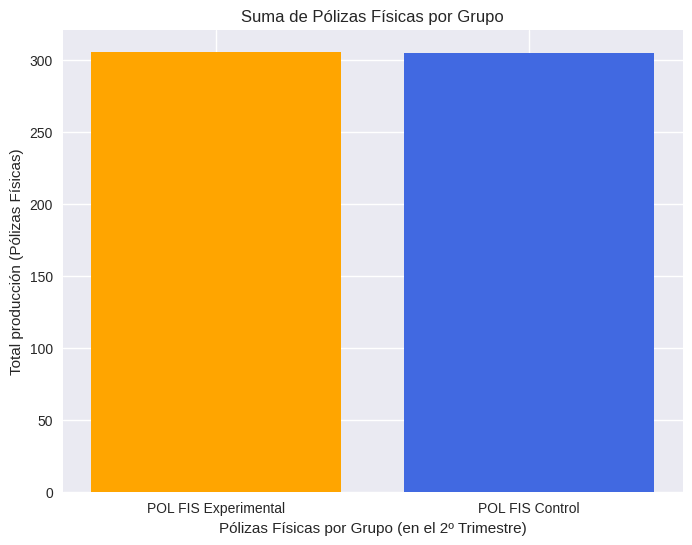

In [81]:
# Preparar datos para el gráfico
sumas_fis_comparativa = [suma_fis_trim2, suma_fis_trim2_ctrl]
columnas_fis_comparativa = ['POL FIS Experimental', 'POL FIS Control']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_fis_comparativa, sumas_fis_comparativa, color=['orange', 'royalblue'])
plt.xlabel('Pólizas Físicas por Grupo (en el 2º Trimestre)')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Grupo')
plt.show()

In [82]:
print('En el segundo trimestre el grupo de control hizo', round(suma_fis_trim2_ctrl,2),'pólizas físicas, mientras que el experimental', round(suma_fis_trim2,2),'.')
print('El grupo de control hizo un 100 % pólizas físicas, mientras que el experimental', round((100*suma_fis_trim2)/suma_fis_trim2_ctrl,2),'%.')

En el segundo trimestre el grupo de control hizo 305 pólizas físicas, mientras que el experimental 306 .
El grupo de control hizo un 100 % pólizas físicas, mientras que el experimental 100.33 %.


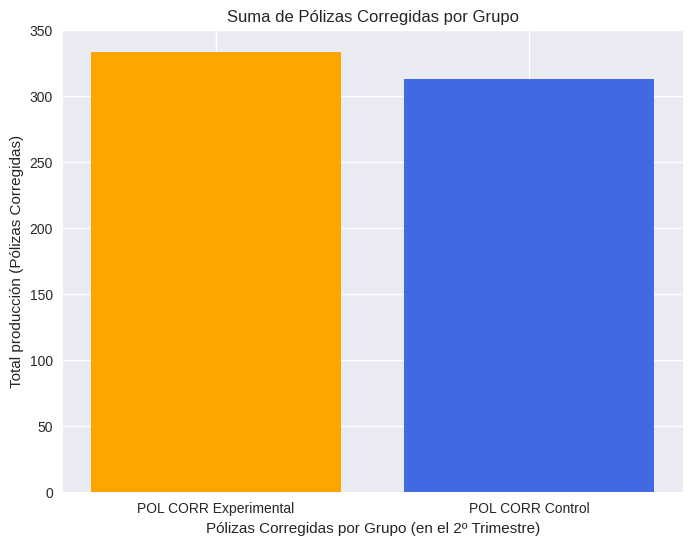

In [83]:
# Preparar datos para el gráfico
sumas_corr_comparativa = [suma_corr_trim2, suma_corr_trim2_ctrl]
columnas_corr_comparativa = ['POL CORR Experimental', 'POL CORR Control']

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(columnas_corr_comparativa, sumas_corr_comparativa, color=['orange', 'royalblue'])
plt.xlabel('Pólizas Corregidas por Grupo (en el 2º Trimestre)')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Grupo')
plt.show()

In [84]:
print('En el segundo trimestre el grupo de control hizo', round(suma_corr_trim2_ctrl,2),'pólizas corregidas, mientras que el experimental', round(suma_corr_trim2,2),'.')
print('El grupo de control hizo un 100 % pólizas corregidas, mientras que el experimental', round((100*suma_corr_trim2)/suma_corr_trim2_ctrl,2),'%.')

En el segundo trimestre el grupo de control hizo 312.58 pólizas corregidas, mientras que el experimental 333.64 .
El grupo de control hizo un 100 % pólizas corregidas, mientras que el experimental 106.74 %.


####Pólizas Físicas y Corregidas - Media mensual
Se procede a realizar el estudio de manera mensual con las medias, teniendo en cuenta los agentes que hay en el mes (teniendo en cuenta los agentes que no estuvieran dados de alta enb el 1er trimestre y las bajas que se vayan produciendo).

In [85]:
enero_bajas_exp = Gr1_bajas_exp[Gr1_bajas_exp['F.BAJA'] <= pd.to_datetime('2024-01-26')]
febrero_bajas_exp = Gr1_bajas_exp[Gr1_bajas_exp['F.BAJA'] <= pd.to_datetime('2024-02-26')]
marzo_bajas_exp = Gr1_bajas_exp[Gr1_bajas_exp['F.BAJA'] <= pd.to_datetime('2024-03-22')]
abril_bajas_exp = Gr1_bajas_exp[Gr1_bajas_exp['F.BAJA'] <= pd.to_datetime('2024-04-25')]
mayo_bajas_exp = Gr1_bajas_exp[Gr1_bajas_exp['F.BAJA'] <= pd.to_datetime('2024-05-27')]
junio_bajas_exp = Gr1_bajas_exp[Gr1_bajas_exp['F.BAJA'] <= pd.to_datetime('2024-06-25')]

enero_bajas_ctrl = Gr2_bajas_ctrl[Gr2_bajas_ctrl['F.BAJA'] <= pd.to_datetime('2024-01-26')]
febrero_bajas_ctrl = Gr2_bajas_ctrl[Gr2_bajas_ctrl['F.BAJA'] <= pd.to_datetime('2024-02-26')]
marzo_bajas_ctrl = Gr2_bajas_ctrl[Gr2_bajas_ctrl['F.BAJA'] <= pd.to_datetime('2024-03-22')]
abril_bajas_ctrl = Gr2_bajas_ctrl[Gr2_bajas_ctrl['F.BAJA'] <= pd.to_datetime('2024-04-25')]
mayo_bajas_ctrl = Gr2_bajas_ctrl[Gr2_bajas_ctrl['F.BAJA'] <= pd.to_datetime('2024-05-27')]
junio_bajas_ctrl = Gr2_bajas_ctrl[Gr2_bajas_ctrl['F.BAJA'] <= pd.to_datetime('2024-06-25')]

cod_bajas_enero_exp = enero_bajas_exp['COD.CALL/SOLNET'].tolist()
cod_bajas_febrero_exp = febrero_bajas_exp['COD.CALL/SOLNET'].tolist()
cod_bajas_marzo_exp = marzo_bajas_exp['COD.CALL/SOLNET'].tolist()
cod_bajas_abril_exp = abril_bajas_exp['COD.CALL/SOLNET'].tolist()
cod_bajas_mayo_exp = mayo_bajas_exp['COD.CALL/SOLNET'].tolist()
cod_bajas_junio_exp = junio_bajas_exp['COD.CALL/SOLNET'].tolist()

cod_bajas_enero_ctrl = enero_bajas_ctrl['COD.CALL/SOLNET'].tolist()
cod_bajas_febrero_ctrl = febrero_bajas_ctrl['COD.CALL/SOLNET'].tolist()
cod_bajas_marzo_ctrl = marzo_bajas_ctrl['COD.CALL/SOLNET'].tolist()
cod_bajas_abril_ctrl = abril_bajas_ctrl['COD.CALL/SOLNET'].tolist()
cod_bajas_mayo_ctrl = mayo_bajas_ctrl['COD.CALL/SOLNET'].tolist()
cod_bajas_junio_ctrl = junio_bajas_ctrl['COD.CALL/SOLNET'].tolist()

enero_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-01-31')) & (~Gr1['LDAP'].isin(cod_bajas_enero_exp))]
febrero_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-02-28')) & (~Gr1['LDAP'].isin(cod_bajas_febrero_exp))]
marzo_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-03-31')) & (~Gr1['LDAP'].isin(cod_bajas_marzo_exp))]
abril_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-04-30')) & (~Gr1['LDAP'].isin(cod_bajas_abril_exp))]
mayo_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-05-31')) & (~Gr1['LDAP'].isin(cod_bajas_mayo_exp))]
junio_exp = Gr1[(Gr1['F.ALTA'] <= pd.to_datetime('2024-06-30')) & (~Gr1['LDAP'].isin(cod_bajas_junio_exp))]

enero_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-01-31')) & (~Gr2['LDAP'].isin(cod_bajas_enero_ctrl))]
febrero_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-02-28')) & (~Gr2['LDAP'].isin(cod_bajas_febrero_ctrl))]
marzo_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-03-31')) & (~Gr2['LDAP'].isin(cod_bajas_marzo_ctrl))]
abril_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-04-30')) & (~Gr2['LDAP'].isin(cod_bajas_abril_ctrl))]
mayo_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-05-31')) & (~Gr2['LDAP'].isin(cod_bajas_mayo_ctrl))]
junio_ctrl = Gr2[(Gr2['F.ALTA'] <= pd.to_datetime('2024-06-30')) & (~Gr2['LDAP'].isin(cod_bajas_junio_ctrl))]

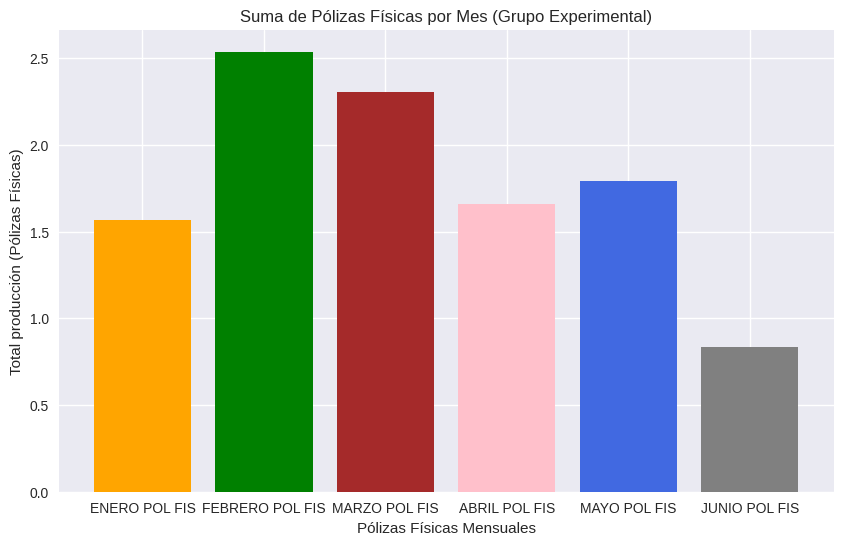

In [86]:
enero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(enero_exp['LDAP'].unique())]
febrero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(febrero_exp['LDAP'].unique())]
marzo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(marzo_exp['LDAP'].unique())]
abril = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(abril_exp['LDAP'].unique())]
mayo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(mayo_exp['LDAP'].unique())]
junio = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(junio_exp['LDAP'].unique())]

media_fis_enero_exp = enero['POL. FIS. 2024-01'].sum()/enero_exp.shape[0]
media_fis_febrero_exp = febrero['POL. FIS. 2024-02'].sum()/febrero_exp.shape[0]
media_fis_marzo_exp = marzo['POL. FIS. 2024-03'].sum()/marzo_exp.shape[0]
media_fis_abril_exp = abril['POL. FIS. 2024-04'].sum()/abril_exp.shape[0]
media_fis_mayo_exp = mayo['POL. FIS. 2024-05'].sum()/mayo_exp.shape[0]
media_fis_junio_exp = junio['POL. FIS. 2024-06'].sum()/junio_exp.shape[0]

# # Preparar datos para el gráfico
medias_fis_exp = [media_fis_enero_exp, media_fis_febrero_exp, media_fis_marzo_exp, media_fis_abril_exp, media_fis_mayo_exp, media_fis_junio_exp]
columnas_fis = ['ENERO POL FIS', 'FEBRERO POL FIS', 'MARZO POL FIS', 'ABRIL POL FIS', 'MAYO POL FIS', 'JUNIO POL FIS']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(columnas_fis, medias_fis_exp, color=['orange', 'green', 'brown', 'pink', 'royalblue', 'grey'])
plt.xlabel('Pólizas Físicas Mensuales')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Mes (Grupo Experimental)')
plt.show()

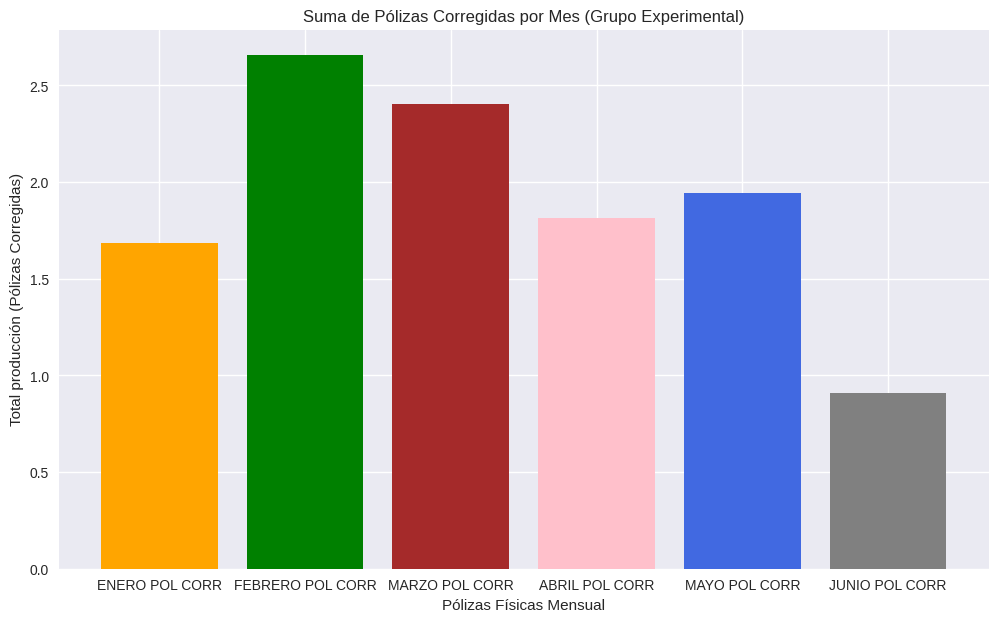

In [87]:
media_corr_enero_exp = enero['POL. CORR. 2024-01'].sum()/enero_exp.shape[0]
media_corr_febrero_exp = febrero['POL. CORR. 2024-02'].sum()/febrero_exp.shape[0]
media_corr_marzo_exp = marzo['POL. CORR. 2024-03'].sum()/marzo_exp.shape[0]
media_corr_abril_exp = abril['POL. CORR. 2024-04'].sum()/abril_exp.shape[0]
media_corr_mayo_exp = mayo['POL. CORR. 2024-05'].sum()/mayo_exp.shape[0]
media_corr_junio_exp = junio['POL. CORR. 2024-06'].sum()/junio_exp.shape[0]

# # Preparar datos para el gráfico
medias_corr_exp = [media_corr_enero_exp, media_corr_febrero_exp, media_corr_marzo_exp, media_corr_abril_exp, media_corr_mayo_exp, media_corr_junio_exp]
columnas_corr = ['ENERO POL CORR', 'FEBRERO POL CORR', 'MARZO POL CORR', 'ABRIL POL CORR', 'MAYO POL CORR', 'JUNIO POL CORR']

# Crear el gráfico de barras
plt.figure(figsize=(12, 7))
plt.bar(columnas_corr, medias_corr_exp, color=['orange', 'green', 'brown', 'pink', 'royalblue', 'grey'])
plt.xlabel('Pólizas Físicas Mensual')
plt.ylabel('Total producción (Pólizas Corregidas)')
plt.title('Suma de Pólizas Corregidas por Mes (Grupo Experimental)')
plt.show()

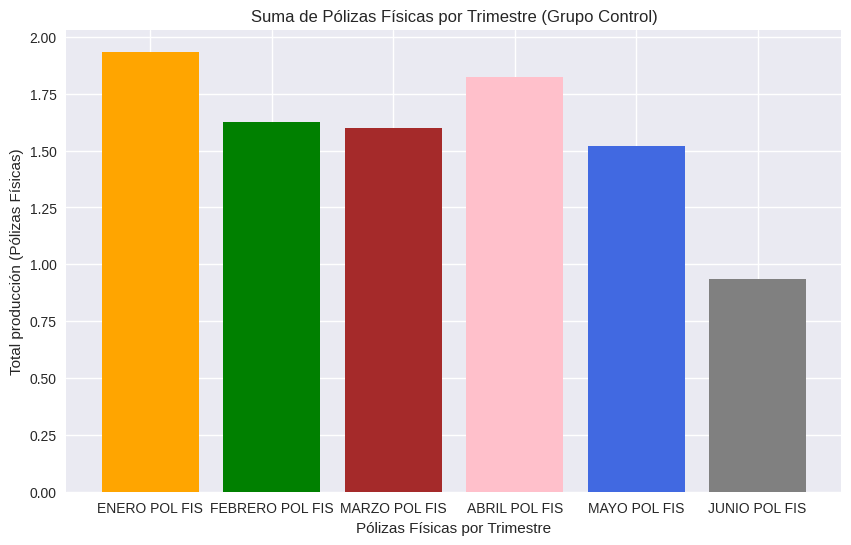

In [88]:
enero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(enero_ctrl['LDAP'].unique())]
febrero = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(febrero_ctrl['LDAP'].unique())]
marzo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(marzo_ctrl['LDAP'].unique())]
abril = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(abril_ctrl['LDAP'].unique())]
mayo = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(mayo_ctrl['LDAP'].unique())]
junio = prod_fis_corr[prod_fis_corr['POSITIONNAME'].isin(junio_ctrl['LDAP'].unique())]

media_fis_enero_ctrl = enero['POL. FIS. 2024-01'].sum()/enero_ctrl.shape[0]
media_fis_febrero_ctrl = febrero['POL. FIS. 2024-02'].sum()/febrero_ctrl.shape[0]
media_fis_marzo_ctrl = marzo['POL. FIS. 2024-03'].sum()/marzo_ctrl.shape[0]
media_fis_abril_ctrl = abril['POL. FIS. 2024-04'].sum()/abril_ctrl.shape[0]
media_fis_mayo_ctrl = mayo['POL. FIS. 2024-05'].sum()/mayo_ctrl.shape[0]
media_fis_junio_ctrl = junio['POL. FIS. 2024-06'].sum()/junio_ctrl.shape[0]

# # Preparar datos para el gráfico
medias_fis_ctrl = [media_fis_enero_ctrl, media_fis_febrero_ctrl, media_fis_marzo_ctrl, media_fis_abril_ctrl, media_fis_mayo_ctrl, media_fis_junio_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(columnas_fis, medias_fis_ctrl, color=['orange', 'green', 'brown', 'pink', 'royalblue', 'grey'])
plt.xlabel('Pólizas Físicas por Trimestre')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Trimestre (Grupo Control)')
plt.show()

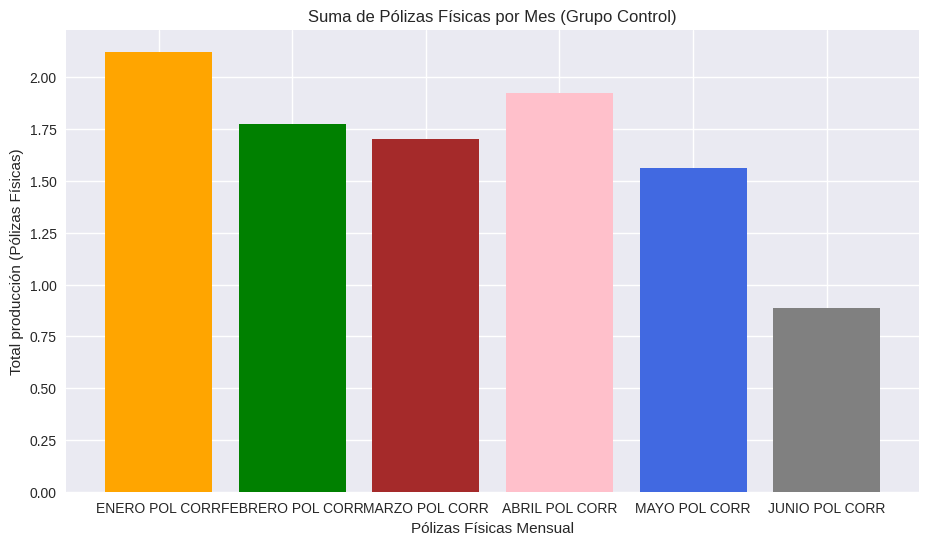

In [89]:
media_corr_enero_ctrl = enero['POL. CORR. 2024-01'].sum()/enero_ctrl.shape[0]
media_corr_febrero_ctrl = febrero['POL. CORR. 2024-02'].sum()/febrero_ctrl.shape[0]
media_corr_marzo_ctrl = marzo['POL. CORR. 2024-03'].sum()/marzo_ctrl.shape[0]
media_corr_abril_ctrl = abril['POL. CORR. 2024-04'].sum()/abril_ctrl.shape[0]
media_corr_mayo_ctrl = mayo['POL. CORR. 2024-05'].sum()/mayo_ctrl.shape[0]
media_corr_junio_ctrl = junio['POL. CORR. 2024-06'].sum()/junio_ctrl.shape[0]

# # Preparar datos para el gráfico
medias_corr_ctrl = [media_corr_enero_ctrl, media_corr_febrero_ctrl, media_corr_marzo_ctrl, media_corr_abril_ctrl, media_corr_mayo_ctrl, media_corr_junio_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(11, 6))
plt.bar(columnas_corr, medias_corr_ctrl, color=['orange', 'green', 'brown', 'pink', 'royalblue', 'grey'])
plt.xlabel('Pólizas Físicas Mensual')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Suma de Pólizas Físicas por Mes (Grupo Control)')
plt.show()

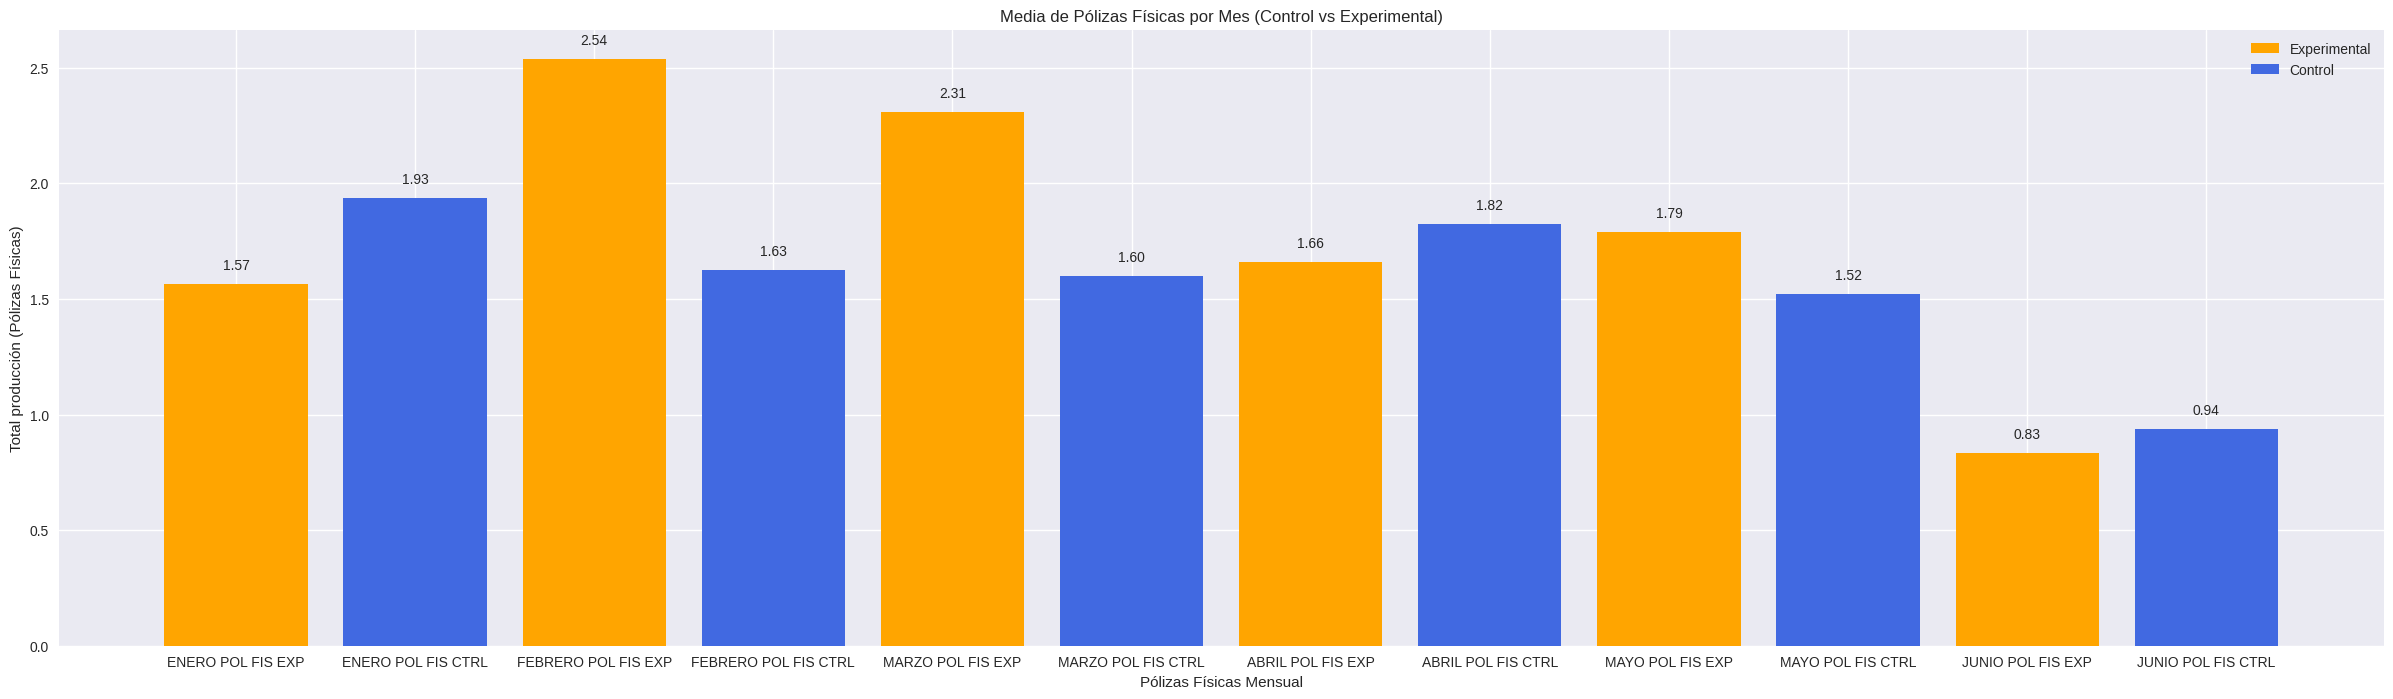

In [90]:
medias_fis = [media_fis_enero_exp, media_fis_enero_ctrl, media_fis_febrero_exp, media_fis_febrero_ctrl, media_fis_marzo_exp, media_fis_marzo_ctrl, media_fis_abril_exp, media_fis_abril_ctrl, media_fis_mayo_exp, media_fis_mayo_ctrl, media_fis_junio_exp, media_fis_junio_ctrl]
columnas_fis_total = ['ENERO POL FIS EXP', 'ENERO POL FIS CTRL', 'FEBRERO POL FIS EXP','FEBRERO POL FIS CTRL', 'MARZO POL FIS EXP', 'MARZO POL FIS CTRL', 'ABRIL POL FIS EXP', 'ABRIL POL FIS CTRL', 'MAYO POL FIS EXP', 'MAYO POL FIS CTRL', 'JUNIO POL FIS EXP', 'JUNIO POL FIS CTRL']

# Crear el gráfico de barras
plt.figure(figsize=(30, 8))
barras = plt.bar(columnas_fis_total, medias_fis, color=['orange', 'royalblue'])

# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, medias_fis):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Pólizas Físicas Mensual')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Media de Pólizas Físicas por Mes (Control vs Experimental)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

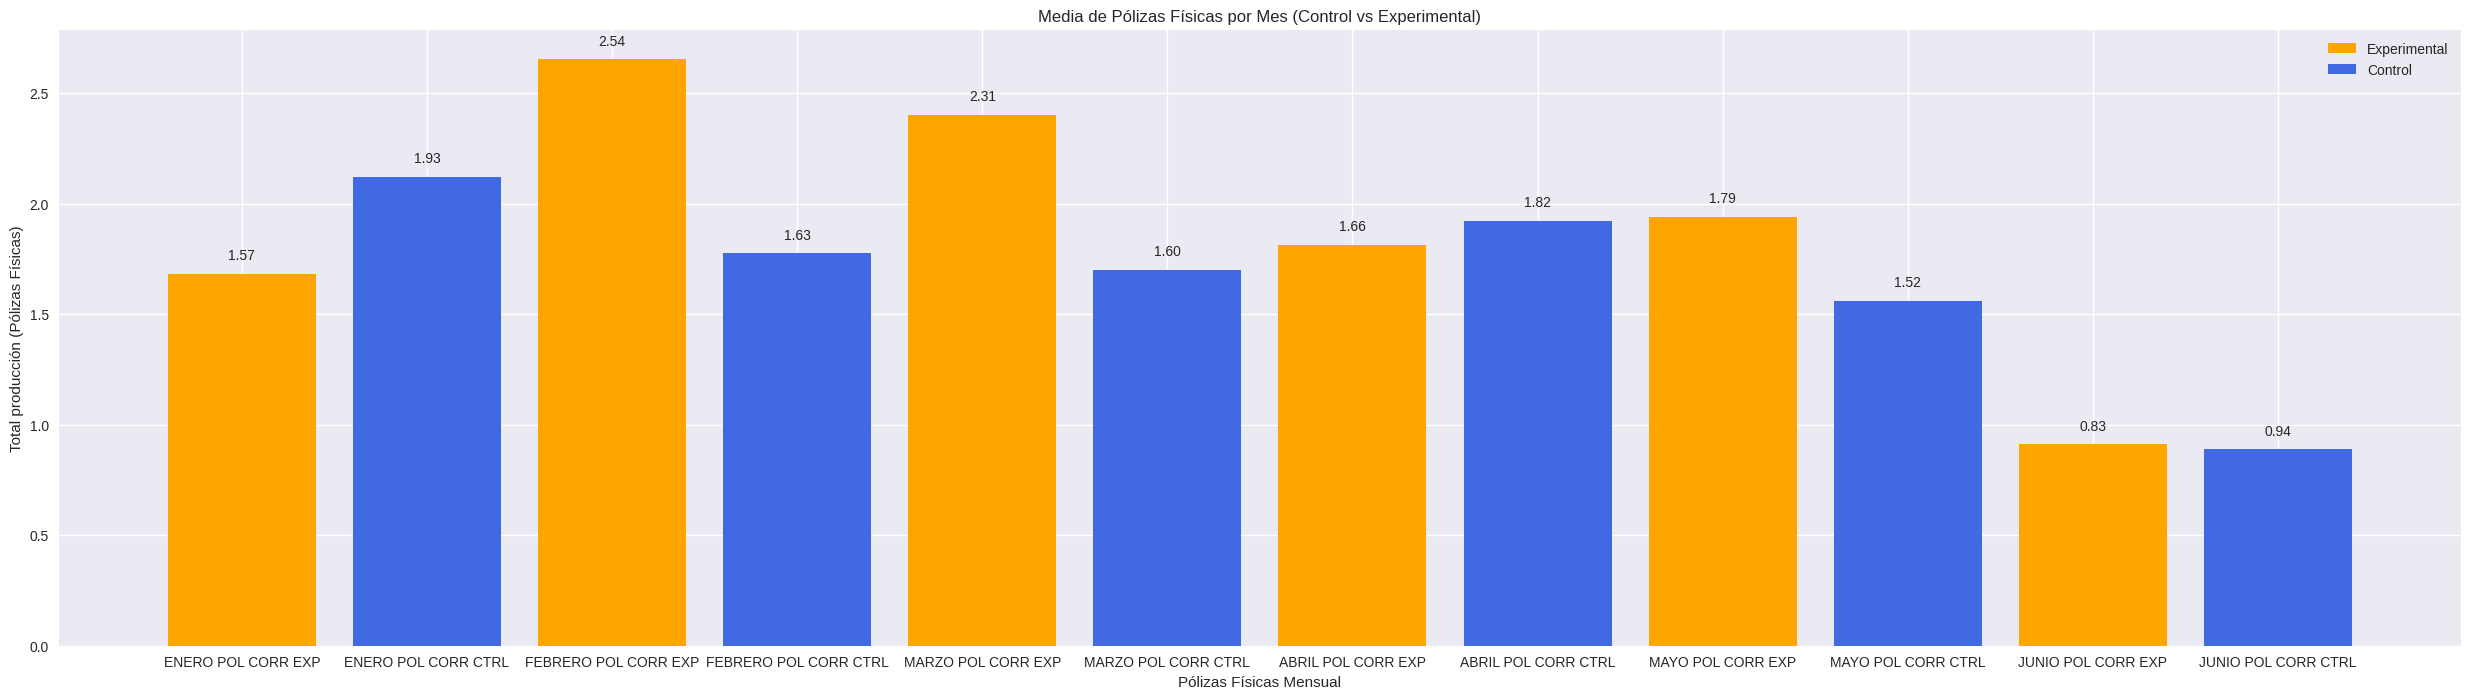

In [91]:
medias_corr = [media_corr_enero_exp, media_corr_enero_ctrl, media_corr_febrero_exp, media_corr_febrero_ctrl, media_corr_marzo_exp, media_corr_marzo_ctrl, media_corr_abril_exp, media_corr_abril_ctrl, media_corr_mayo_exp, media_corr_mayo_ctrl, media_corr_junio_exp, media_corr_junio_ctrl]
columnas_corr_total = ['ENERO POL CORR EXP', 'ENERO POL CORR CTRL', 'FEBRERO POL CORR EXP','FEBRERO POL CORR CTRL', 'MARZO POL CORR EXP', 'MARZO POL CORR CTRL', 'ABRIL POL CORR EXP', 'ABRIL POL CORR CTRL', 'MAYO POL CORR EXP', 'MAYO POL CORR CTRL', 'JUNIO POL CORR EXP', 'JUNIO POL CORR CTRL']

# Crear el gráfico de barras
plt.figure(figsize=(31, 8))
barras = plt.bar(columnas_corr_total, medias_corr, color=['orange', 'royalblue'])

# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, medias_fis):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Pólizas Físicas Mensual')
plt.ylabel('Total producción (Pólizas Físicas)')
plt.title('Media de Pólizas Físicas por Mes (Control vs Experimental)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

####Tipo de Producción
Vemos si la venta se encamina hacia donde la compañía busca.

In [92]:
enero_prod_esp_exp = pd.merge(prod_enero, enero_exp, on='NIF', how='inner')
febrero_prod_esp_exp = pd.merge(prod_febrero, febrero_exp, on='NIF', how='inner')
marzo_prod_esp_exp = pd.merge(prod_marzo, marzo_exp, on='NIF', how='inner')
abril_prod_esp_exp = pd.merge(prod_abril, abril_exp, on='NIF', how='inner')
mayo_prod_esp_exp = pd.merge(prod_mayo, mayo_exp, on='NIF', how='inner')
junio_prod_esp_exp = pd.merge(prod_junio, junio_exp, on='NIF', how='inner')

media_hogar_enero_exp = enero_prod_esp_exp['POL. FIS. HOGAR'].sum()/enero_prod_esp_exp.shape[0]
media_rrtt_enero_exp = enero_prod_esp_exp['POL. FIS. RRTT'].sum()/enero_prod_esp_exp.shape[0]
media_rrpp_enero_exp = enero_prod_esp_exp['POL. FIS. RRPP'].sum()/enero_prod_esp_exp.shape[0]
media_aseg_enero_exp = enero_prod_esp_exp['ASEG.'].sum()/enero_prod_esp_exp.shape[0]

media_hogar_febrero_exp = febrero_prod_esp_exp['POL. FIS. HOGAR'].sum()/febrero_prod_esp_exp.shape[0]
media_rrtt_febrero_exp = febrero_prod_esp_exp['POL. FIS. RRTT'].sum()/febrero_prod_esp_exp.shape[0]
media_rrpp_febrero_exp = febrero_prod_esp_exp['POL. FIS. RRPP'].sum()/febrero_prod_esp_exp.shape[0]
media_aseg_febrero_exp = febrero_prod_esp_exp['ASEG.'].sum()/febrero_prod_esp_exp.shape[0]

media_hogar_marzo_exp = marzo_prod_esp_exp['POL. FIS. HOGAR'].sum()/marzo_prod_esp_exp.shape[0]
media_rrtt_marzo_exp = marzo_prod_esp_exp['POL. FIS. RRTT'].sum()/marzo_prod_esp_exp.shape[0]
media_rrpp_marzo_exp = marzo_prod_esp_exp['POL. FIS. RRPP'].sum()/marzo_prod_esp_exp.shape[0]
media_aseg_marzo_exp = marzo_prod_esp_exp['ASEG.'].sum()/marzo_prod_esp_exp.shape[0]

media_hogar_abril_exp = abril_prod_esp_exp['POL. FIS. HOGAR'].sum()/abril_prod_esp_exp.shape[0]
media_rrtt_abril_exp = abril_prod_esp_exp['POL. FIS. RRTT'].sum()/abril_prod_esp_exp.shape[0]
media_rrpp_abril_exp = abril_prod_esp_exp['POL. FIS. RRPP'].sum()/abril_prod_esp_exp.shape[0]
media_aseg_abril_exp = abril_prod_esp_exp['ASEG.'].sum()/abril_prod_esp_exp.shape[0]

media_hogar_mayo_exp = mayo_prod_esp_exp['POL. FIS. HOGAR'].sum()/mayo_prod_esp_exp.shape[0]
media_rrtt_mayo_exp = mayo_prod_esp_exp['POL. FIS. RRTT'].sum()/mayo_prod_esp_exp.shape[0]
media_rrpp_mayo_exp = mayo_prod_esp_exp['POL. FIS. RRPP'].sum()/mayo_prod_esp_exp.shape[0]
media_aseg_mayo_exp = mayo_prod_esp_exp['ASEG.'].sum()/mayo_prod_esp_exp.shape[0]

media_hogar_junio_exp = junio_prod_esp_exp['POL. FIS. HOGAR'].sum()/junio_prod_esp_exp.shape[0]
media_rrtt_junio_exp = junio_prod_esp_exp['POL. FIS. RRTT'].sum()/junio_prod_esp_exp.shape[0]
media_rrpp_junio_exp = junio_prod_esp_exp['POL. FIS. RRPP'].sum()/junio_prod_esp_exp.shape[0]
media_aseg_junio_exp = junio_prod_esp_exp['ASEG.'].sum()/junio_prod_esp_exp.shape[0]

In [93]:
enero_prod_esp_ctrl = pd.merge(prod_enero, enero_ctrl, on='NIF', how='inner')
febrero_prod_esp_ctrl = pd.merge(prod_febrero, febrero_ctrl, on='NIF', how='inner')
marzo_prod_esp_ctrl = pd.merge(prod_marzo, marzo_ctrl, on='NIF', how='inner')
abril_prod_esp_ctrl = pd.merge(prod_abril, abril_ctrl, on='NIF', how='inner')
mayo_prod_esp_ctrl = pd.merge(prod_mayo, mayo_ctrl, on='NIF', how='inner')
junio_prod_esp_ctrl = pd.merge(prod_junio, junio_ctrl, on='NIF', how='inner')

media_hogar_enero_ctrl = enero_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/enero_prod_esp_ctrl.shape[0]
media_rrtt_enero_ctrl = enero_prod_esp_ctrl['POL. FIS. RRTT'].sum()/enero_prod_esp_ctrl.shape[0]
media_rrpp_enero_ctrl = enero_prod_esp_ctrl['POL. FIS. RRPP'].sum()/enero_prod_esp_ctrl.shape[0]
media_aseg_enero_ctrl = enero_prod_esp_ctrl['ASEG.'].sum()/enero_prod_esp_ctrl.shape[0]

media_hogar_febrero_ctrl = febrero_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/febrero_prod_esp_ctrl.shape[0]
media_rrtt_febrero_ctrl = febrero_prod_esp_ctrl['POL. FIS. RRTT'].sum()/febrero_prod_esp_ctrl.shape[0]
media_rrpp_febrero_ctrl = febrero_prod_esp_ctrl['POL. FIS. RRPP'].sum()/febrero_prod_esp_ctrl.shape[0]
media_aseg_febrero_ctrl = febrero_prod_esp_ctrl['ASEG.'].sum()/febrero_prod_esp_ctrl.shape[0]

media_hogar_marzo_ctrl = marzo_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/marzo_prod_esp_ctrl.shape[0]
media_rrtt_marzo_ctrl = marzo_prod_esp_ctrl['POL. FIS. RRTT'].sum()/marzo_prod_esp_ctrl.shape[0]
media_rrpp_marzo_ctrl = marzo_prod_esp_ctrl['POL. FIS. RRPP'].sum()/marzo_prod_esp_ctrl.shape[0]
media_aseg_marzo_ctrl = marzo_prod_esp_ctrl['ASEG.'].sum()/marzo_prod_esp_ctrl.shape[0]

media_hogar_abril_ctrl = abril_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/abril_prod_esp_ctrl.shape[0]
media_rrtt_abril_ctrl = abril_prod_esp_ctrl['POL. FIS. RRTT'].sum()/abril_prod_esp_ctrl.shape[0]
media_rrpp_abril_ctrl = abril_prod_esp_ctrl['POL. FIS. RRPP'].sum()/abril_prod_esp_ctrl.shape[0]
media_aseg_abril_ctrl = abril_prod_esp_ctrl['ASEG.'].sum()/abril_prod_esp_ctrl.shape[0]

media_hogar_mayo_ctrl = mayo_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/mayo_prod_esp_ctrl.shape[0]
media_rrtt_mayo_ctrl = mayo_prod_esp_ctrl['POL. FIS. RRTT'].sum()/mayo_prod_esp_ctrl.shape[0]
media_rrpp_mayo_ctrl = mayo_prod_esp_ctrl['POL. FIS. RRPP'].sum()/mayo_prod_esp_ctrl.shape[0]
media_aseg_mayo_ctrl = mayo_prod_esp_ctrl['ASEG.'].sum()/mayo_prod_esp_ctrl.shape[0]

media_hogar_junio_ctrl = junio_prod_esp_ctrl['POL. FIS. HOGAR'].sum()/junio_prod_esp_ctrl.shape[0]
media_rrtt_junio_ctrl = junio_prod_esp_ctrl['POL. FIS. RRTT'].sum()/junio_prod_esp_ctrl.shape[0]
media_rrpp_junio_ctrl = junio_prod_esp_ctrl['POL. FIS. RRPP'].sum()/junio_prod_esp_ctrl.shape[0]
media_aseg_junio_ctrl = junio_prod_esp_ctrl['ASEG.'].sum()/junio_prod_esp_ctrl.shape[0]

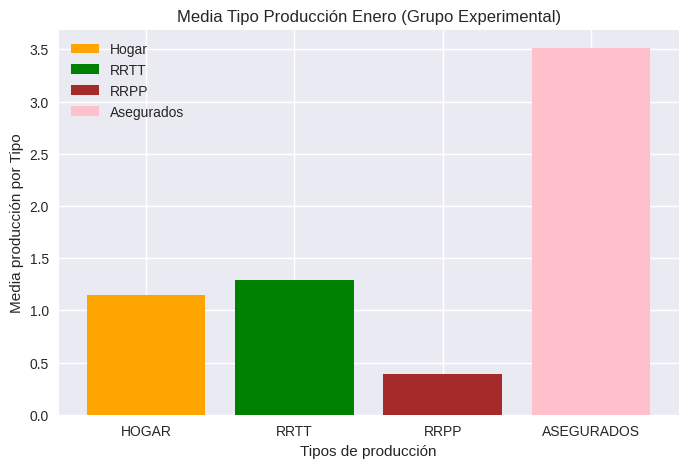

In [94]:
# Preparar datos para el gráfico
medias_enero = [media_hogar_enero_exp, media_rrtt_enero_exp, media_rrpp_enero_exp, media_aseg_enero_exp]
columnas_tipo_prod = ['HOGAR', 'RRTT', 'RRPP', 'ASEGURADOS']

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(columnas_tipo_prod, medias_enero, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Tipo Producción Enero (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
plt.show()

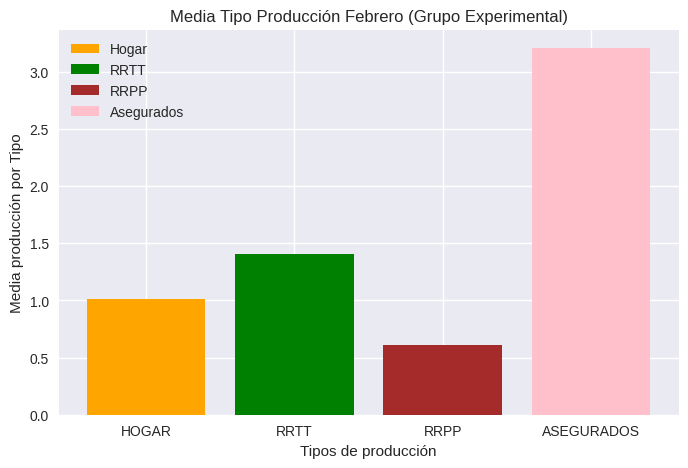

In [95]:
# Preparar datos para el gráfico
medias_febrero = [media_hogar_febrero_exp, media_rrtt_febrero_exp, media_rrpp_febrero_exp, media_aseg_febrero_exp]

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(columnas_tipo_prod, medias_febrero, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Tipo Producción Febrero (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
plt.show()

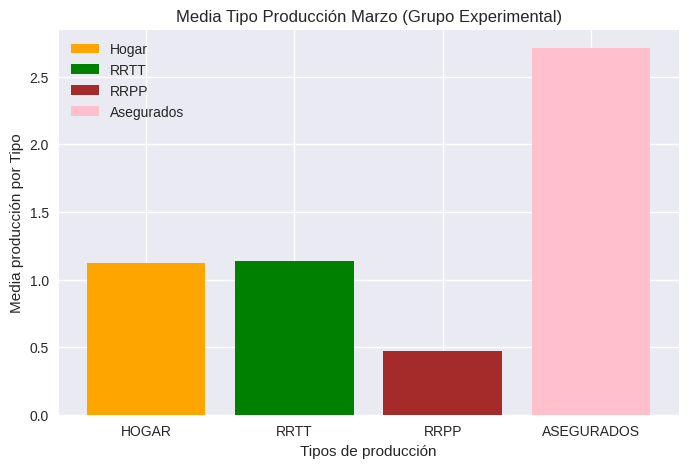

In [96]:
# Preparar datos para el gráfico
medias_marzo = [media_hogar_marzo_exp, media_rrtt_marzo_exp, media_rrpp_marzo_exp, media_aseg_marzo_exp]

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(columnas_tipo_prod, medias_marzo, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Tipo Producción Marzo (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
plt.show()

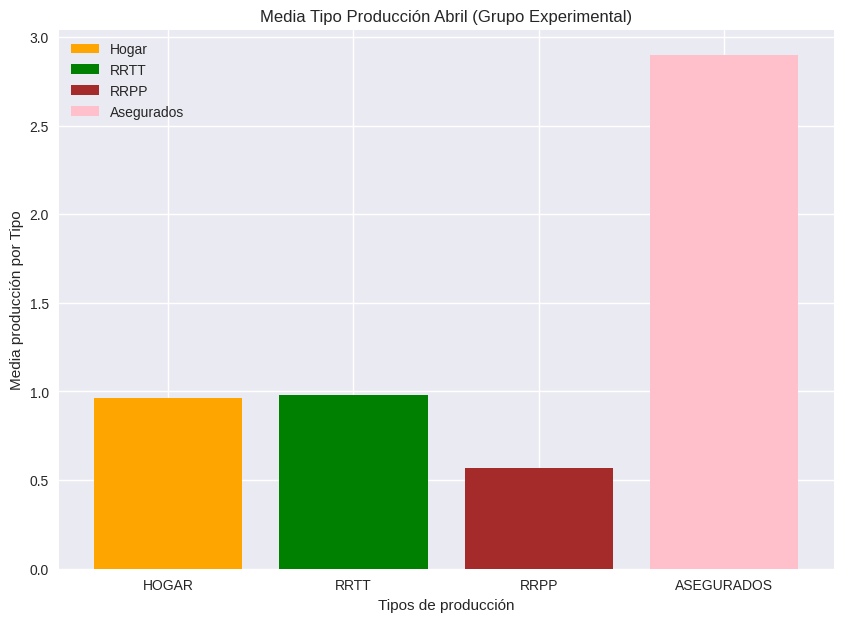

In [97]:
# Preparar datos para el gráfico
medias_abril = [media_hogar_abril_exp, media_rrtt_abril_exp, media_rrpp_abril_exp, media_aseg_abril_exp]

# Crear el gráfico de barras
plt.figure(figsize=(10, 7))
bars = plt.bar(columnas_tipo_prod, medias_abril, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Tipo Producción Abril (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
plt.show()

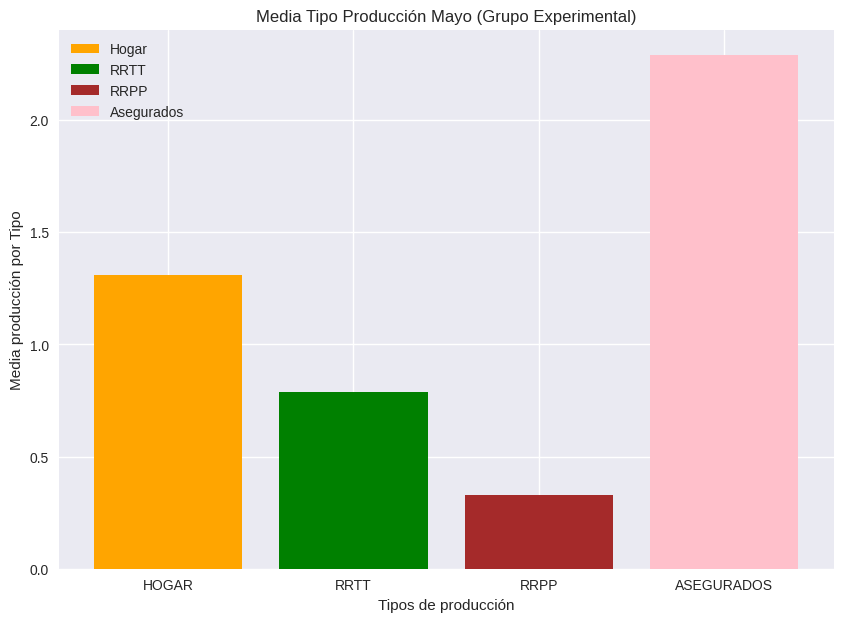

In [98]:
# Preparar datos para el gráfico
medias_mayo = [media_hogar_mayo_exp, media_rrtt_mayo_exp, media_rrpp_mayo_exp, media_aseg_mayo_exp]

# Crear el gráfico de barras
plt.figure(figsize=(10, 7))
bars = plt.bar(columnas_tipo_prod, medias_mayo, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Tipo Producción Mayo (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
plt.show()

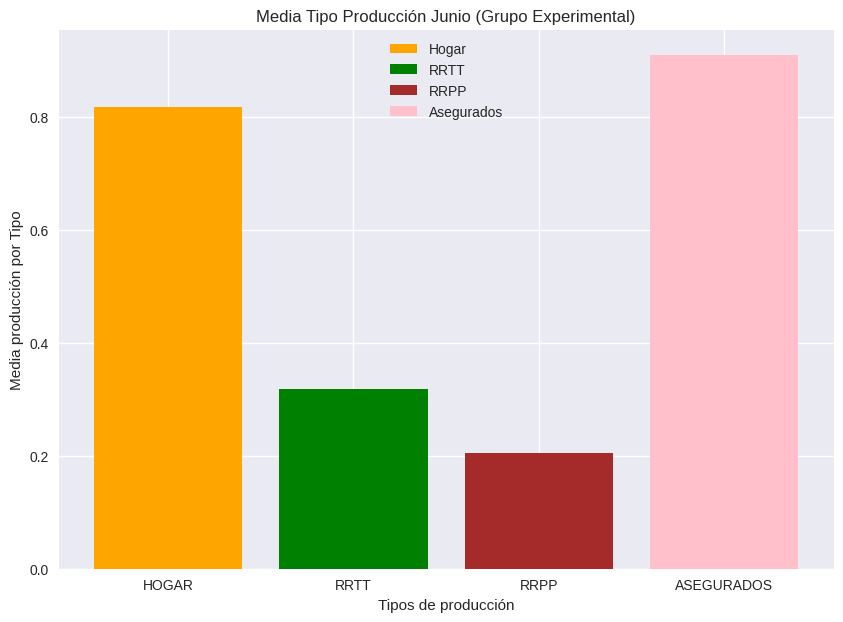

In [99]:
# Preparar datos para el gráfico
medias_junio = [media_hogar_junio_exp, media_rrtt_junio_exp, media_rrpp_junio_exp, media_aseg_junio_exp]

# Crear el gráfico de barras
plt.figure(figsize=(10, 7))
bars = plt.bar(columnas_tipo_prod, medias_junio, color=['orange', 'green', 'brown', 'pink'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Tipo Producción Junio (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3]], ['Hogar', 'RRTT', 'RRPP', 'Asegurados'])
plt.show()

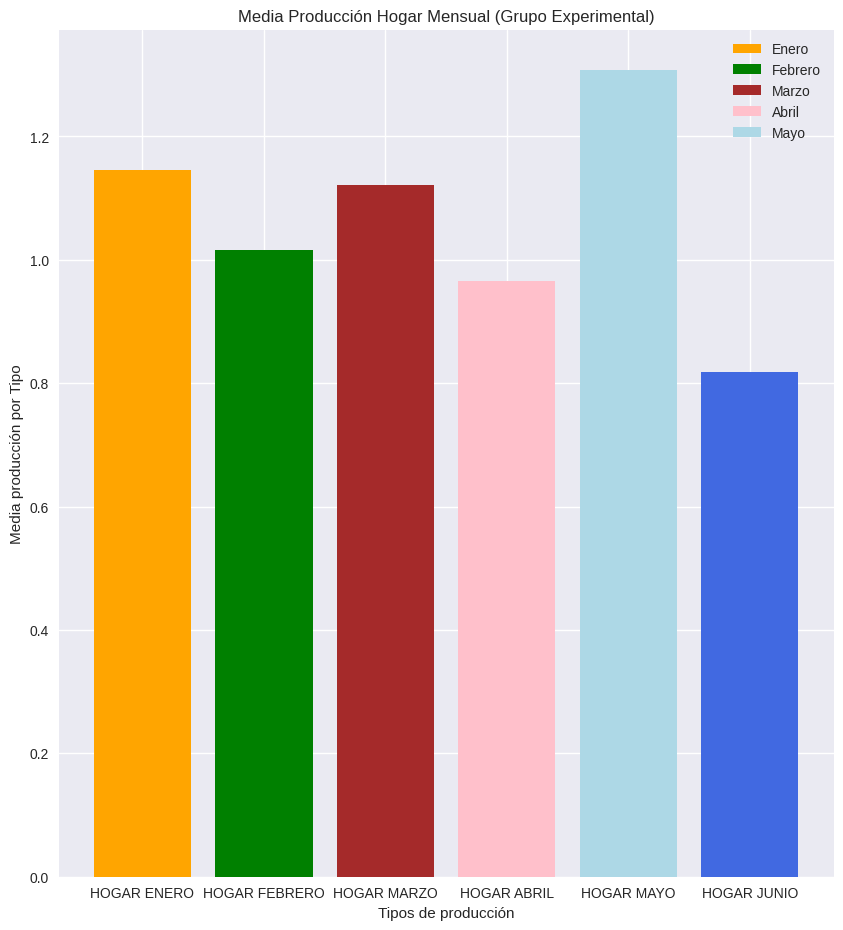

In [100]:
# Preparar datos para el gráfico
medias_hogar_exp = [media_hogar_enero_exp, media_hogar_febrero_exp, media_hogar_marzo_exp, media_hogar_abril_exp, media_hogar_mayo_exp, media_hogar_junio_exp]
columnas_hogar = ['HOGAR ENERO', 'HOGAR FEBRERO', 'HOGAR MARZO', 'HOGAR ABRIL', 'HOGAR MAYO', 'HOGAR JUNIO']

# Crear el gráfico de barras
plt.figure(figsize=(10, 11))
bars = plt.bar(columnas_hogar, medias_hogar_exp, color=['orange', 'green', 'brown', 'pink', 'lightblue', 'royalblue'])
plt.xlabel('Tipos de producción')
plt.ylabel('Media producción por Tipo')
plt.title('Media Producción Hogar Mensual (Grupo Experimental)')
plt.legend([bars[0], bars[1], bars[2], bars[3], bars[4]], ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio'])
plt.show()

#####Grupo Control VS Experimental

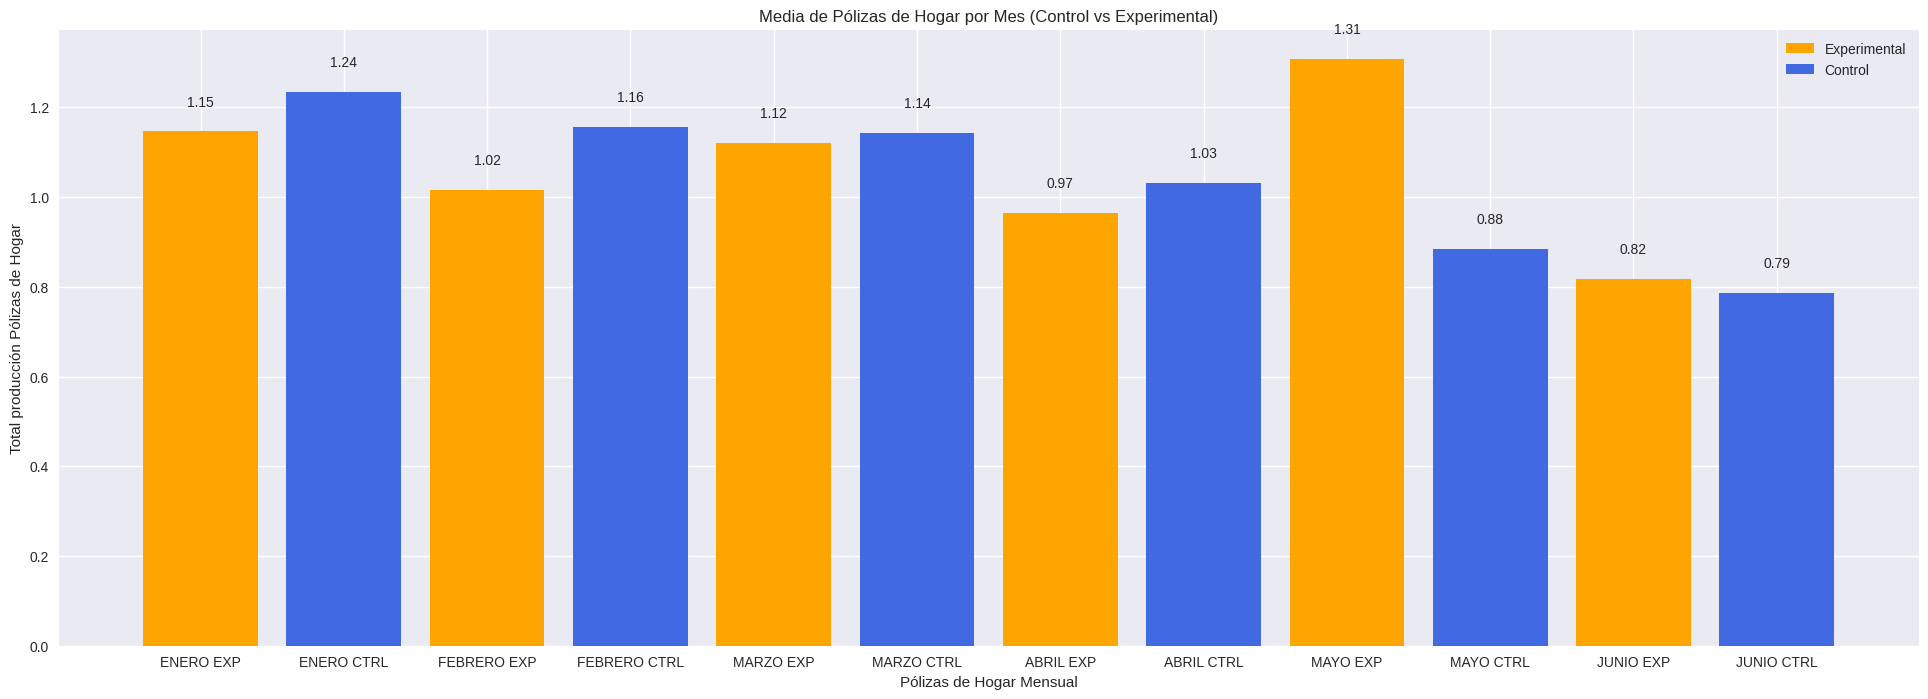

In [101]:
# Preparar datos para el gráfico
medias_hogar = [media_hogar_enero_exp, media_hogar_enero_ctrl, media_hogar_febrero_exp, media_hogar_febrero_ctrl, media_hogar_marzo_exp, media_hogar_marzo_ctrl, media_hogar_abril_exp, media_hogar_abril_ctrl, media_hogar_mayo_exp, media_hogar_mayo_ctrl, media_hogar_junio_exp, media_hogar_junio_ctrl]
columnas_meses = ['ENERO EXP', 'ENERO CTRL', 'FEBRERO EXP', 'FEBRERO CTRL', 'MARZO EXP', 'MARZO CTRL', 'ABRIL EXP', 'ABRIL CTRL', 'MAYO EXP', 'MAYO CTRL', 'JUNIO EXP', 'JUNIO CTRL']

# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, medias_hogar, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, medias_hogar):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Pólizas de Hogar Mensual')
plt.ylabel('Total producción Pólizas de Hogar')
plt.title('Media de Pólizas de Hogar por Mes (Control vs Experimental)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

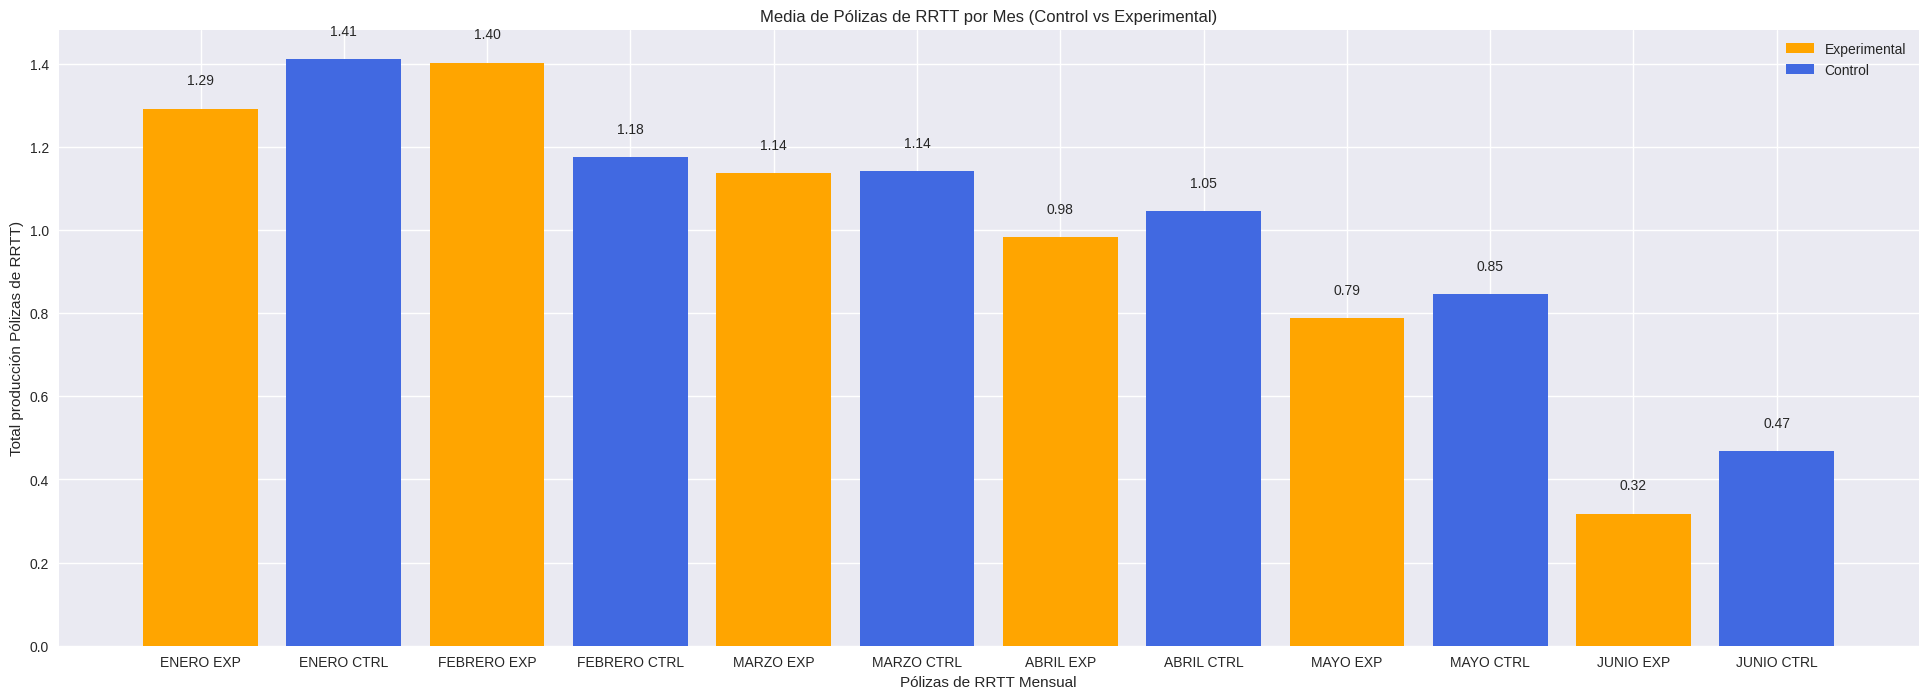

In [102]:
# Preparar datos para el gráfico
medias_rrtt = [media_rrtt_enero_exp, media_rrtt_enero_ctrl, media_rrtt_febrero_exp, media_rrtt_febrero_ctrl, media_rrtt_marzo_exp, media_rrtt_marzo_ctrl, media_rrtt_abril_exp, media_rrtt_abril_ctrl, media_rrtt_mayo_exp, media_rrtt_mayo_ctrl, media_rrtt_junio_exp, media_rrtt_junio_ctrl]


# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, medias_rrtt, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, medias_rrtt):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Pólizas de RRTT Mensual')
plt.ylabel('Total producción Pólizas de RRTT)')
plt.title('Media de Pólizas de RRTT por Mes (Control vs Experimental)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

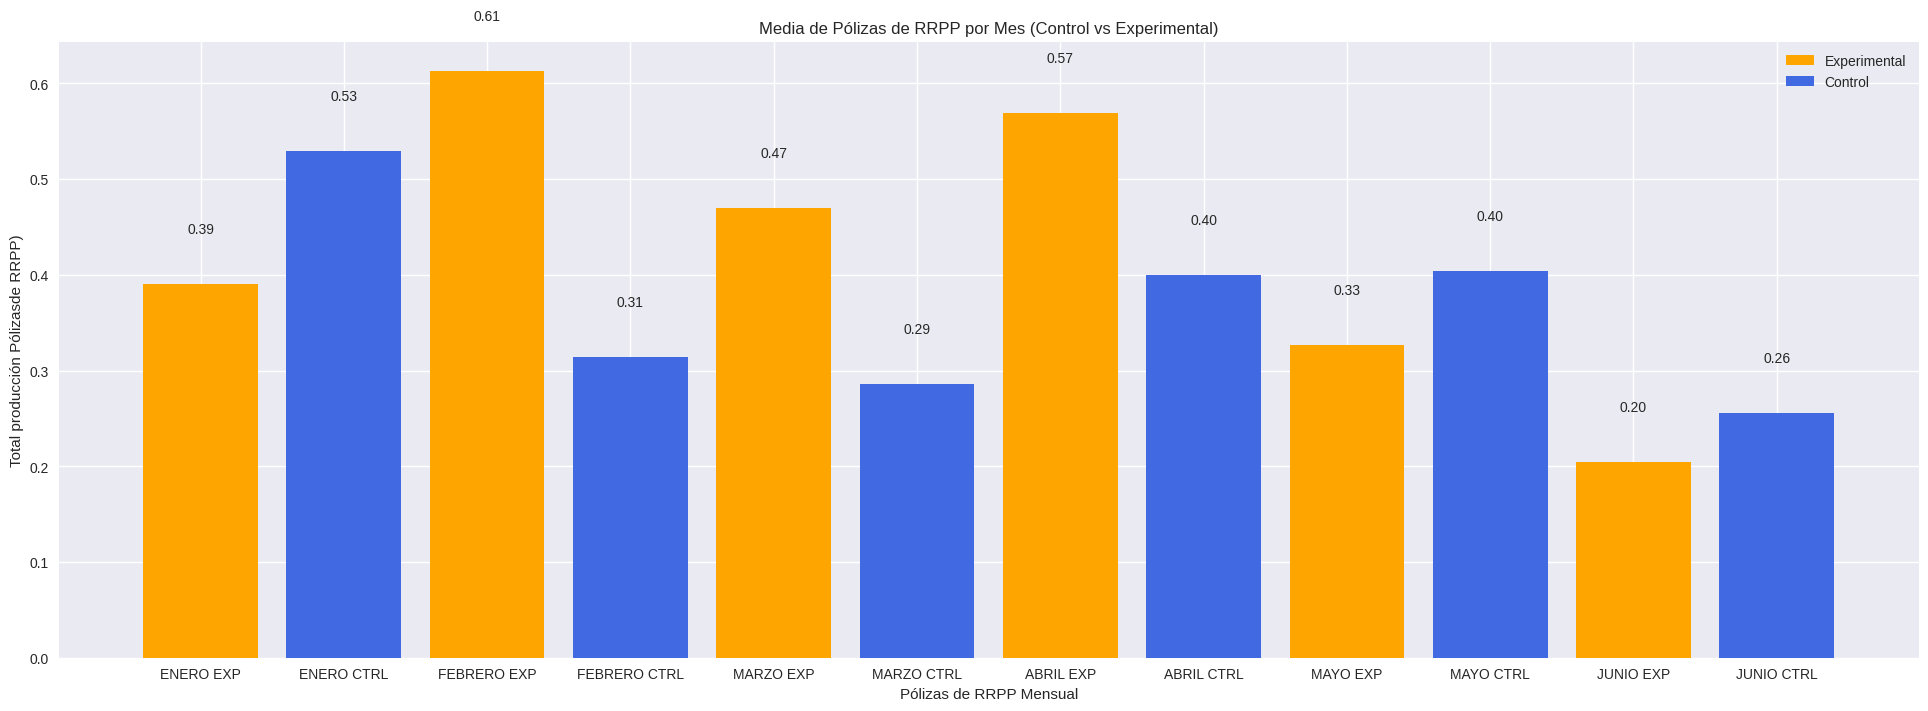

In [103]:
# Preparar datos para el gráfico
medias_rrpp = [media_rrpp_enero_exp, media_rrpp_enero_ctrl, media_rrpp_febrero_exp, media_rrpp_febrero_ctrl, media_rrpp_marzo_exp, media_rrpp_marzo_ctrl, media_rrpp_abril_exp, media_rrpp_abril_ctrl, media_rrpp_mayo_exp, media_rrpp_mayo_ctrl, media_rrpp_junio_exp, media_rrpp_junio_ctrl]


# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, medias_rrpp, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, medias_rrpp):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Pólizas de RRPP Mensual')
plt.ylabel('Total producción Pólizasde RRPP)')
plt.title('Media de Pólizas de RRPP por Mes (Control vs Experimental)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

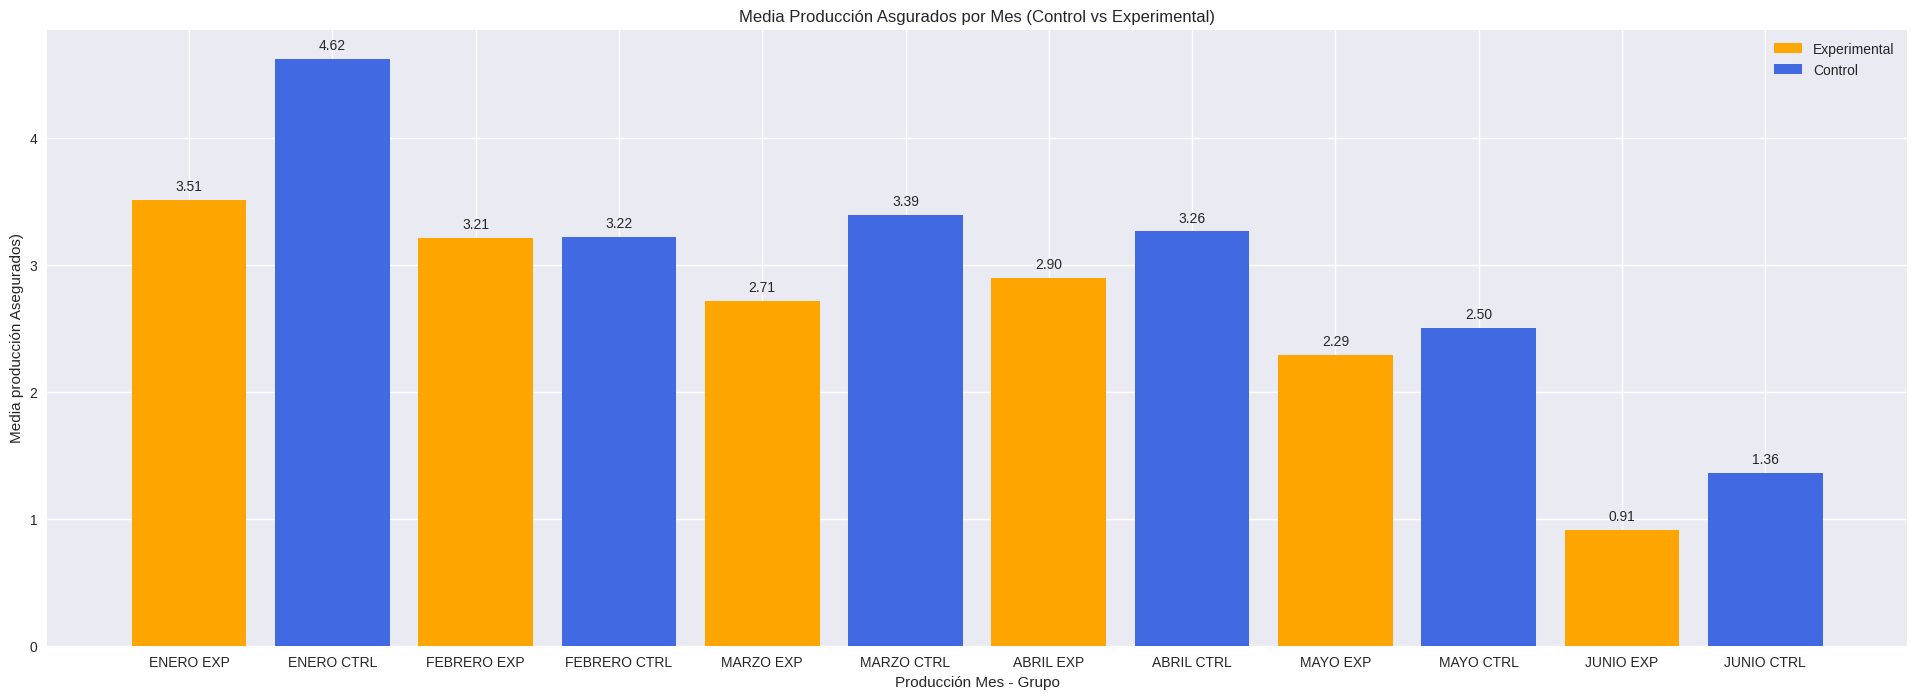

In [104]:
# Preparar datos para el gráfico
medias_aseg = [media_aseg_enero_exp, media_aseg_enero_ctrl, media_aseg_febrero_exp, media_aseg_febrero_ctrl, media_aseg_marzo_exp, media_aseg_marzo_ctrl, media_aseg_abril_exp, media_aseg_abril_ctrl, media_aseg_mayo_exp, media_aseg_mayo_ctrl, media_aseg_junio_exp, media_aseg_junio_ctrl]


# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, medias_aseg, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, medias_aseg):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Producción Mes - Grupo')
plt.ylabel('Media producción Asegurados)')
plt.title('Media Producción Asgurados por Mes (Control vs Experimental)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

##RAPPEL TOTAL MEDIO

In [105]:
media_rappel_total_enero_exp = enero_prod_esp_exp['RAPPEL_TOTAL'].sum()/enero_prod_esp_exp.shape[0]
media_rappel_total_febrero_exp = febrero_prod_esp_exp['RAPPEL_TOTAL'].sum()/febrero_prod_esp_exp.shape[0]
media_rappel_total_marzo_exp = marzo_prod_esp_exp['RAPPEL_TOTAL'].sum()/marzo_prod_esp_exp.shape[0]
media_rappel_total_abril_exp = abril_prod_esp_exp['RAPPEL_TOTAL'].sum()/abril_prod_esp_exp.shape[0]
media_rappel_total_mayo_exp = mayo_prod_esp_exp['RAPPEL_TOTAL'].sum()/mayo_prod_esp_exp.shape[0]
media_rappel_total_junio_exp = junio_prod_esp_exp['RAPPEL_TOTAL'].sum()/junio_prod_esp_exp.shape[0]

media_rappel_total_enero_ctrl = enero_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/enero_prod_esp_ctrl.shape[0]
media_rappel_total_febrero_ctrl = febrero_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/febrero_prod_esp_ctrl.shape[0]
media_rappel_total_marzo_ctrl = marzo_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/marzo_prod_esp_ctrl.shape[0]
media_rappel_total_abril_ctrl = abril_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/abril_prod_esp_ctrl.shape[0]
media_rappel_total_mayo_ctrl = mayo_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/mayo_prod_esp_ctrl.shape[0]
media_rappel_total_junio_ctrl = junio_prod_esp_ctrl['RAPPEL_TOTAL'].sum()/junio_prod_esp_ctrl.shape[0]

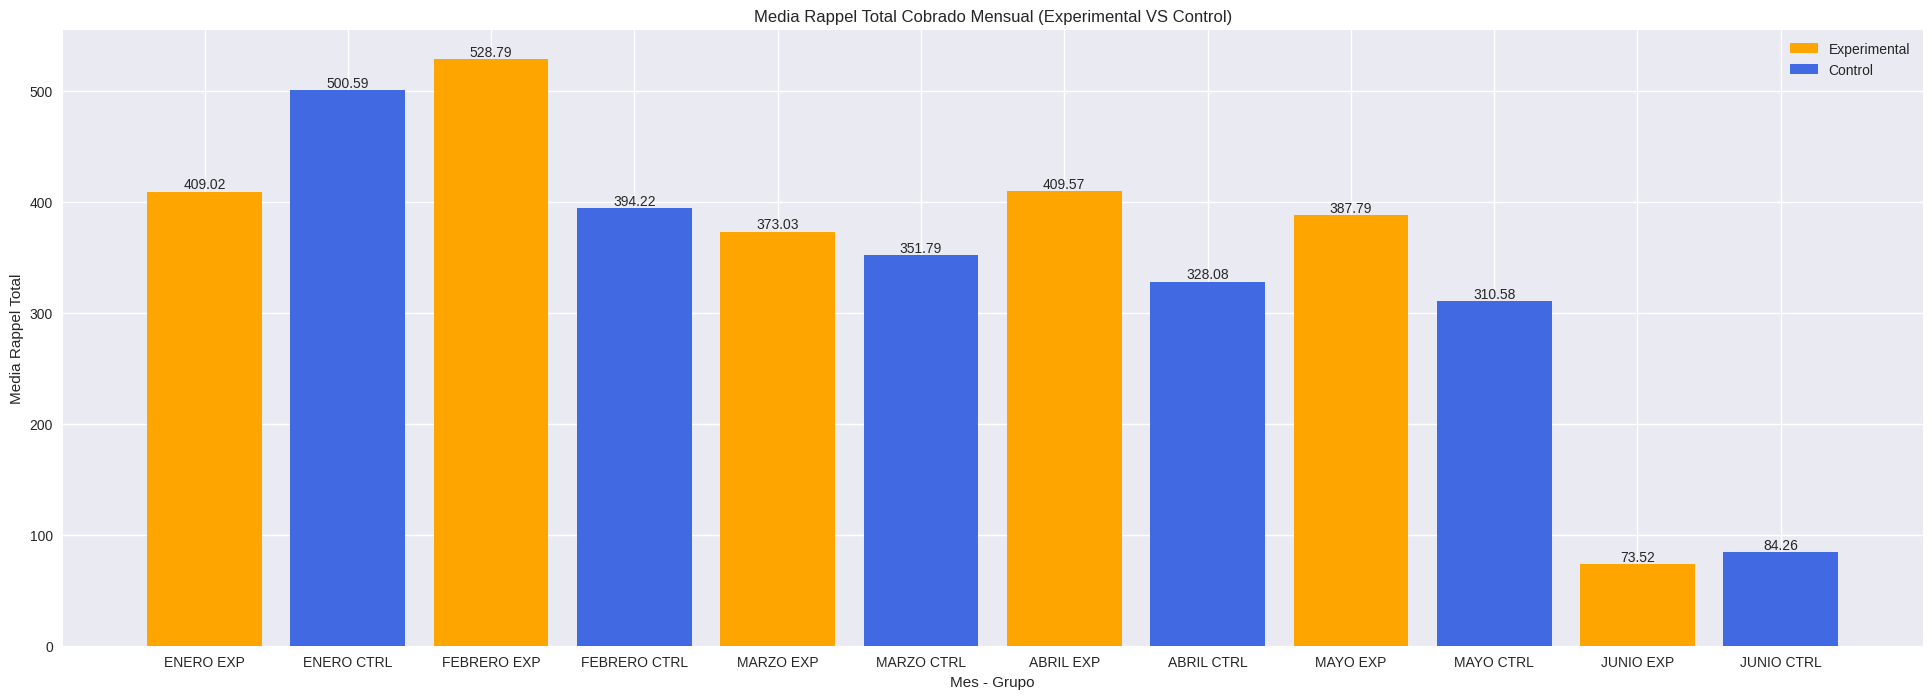

In [106]:
# Preparar datos para el gráfico
medias_rappel_total = [media_rappel_total_enero_exp, media_rappel_total_enero_ctrl, media_rappel_total_febrero_exp, media_rappel_total_febrero_ctrl, media_rappel_total_marzo_exp, media_rappel_total_marzo_ctrl, media_rappel_total_abril_exp, media_rappel_total_abril_ctrl, media_rappel_total_mayo_exp, media_rappel_total_mayo_ctrl, media_rappel_total_junio_exp, media_rappel_total_junio_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, medias_rappel_total, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, medias_rappel_total):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Mes - Grupo')
plt.ylabel('Media Rappel Total')
plt.title('Media Rappel Total Cobrado Mensual (Experimental VS Control)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

##RAPPEL COBRADO PORCENTUAL


####Grupo Experimental

In [107]:
porcentaje_rappel_cobrado_enero_exp = (enero_prod_esp_exp['COBRA_RAPPEL'].sum()/enero_prod_esp_exp.shape[0])*100
porcentaje_rappel_cobrado_febrero_exp = (febrero_prod_esp_exp['COBRA_RAPPEL'].sum()/febrero_prod_esp_exp.shape[0])*100
porcentaje_rappel_cobrado_marzo_exp = (marzo_prod_esp_exp['COBRA_RAPPEL'].sum()/marzo_prod_esp_exp.shape[0])*100
porcentaje_rappel_cobrado_abril_exp = (abril_prod_esp_exp['COBRA_RAPPEL'].sum()/abril_prod_esp_exp.shape[0])*100
porcentaje_rappel_cobrado_mayo_exp = (mayo_prod_esp_exp['COBRA_RAPPEL'].sum()/mayo_prod_esp_exp.shape[0])*100
porcentaje_rappel_cobrado_junio_exp = (junio_prod_esp_exp['COBRA_RAPPEL'].sum()/junio_prod_esp_exp.shape[0])*100

porcentaje_rappel_cobrado_enero_ctrl = (enero_prod_esp_ctrl['COBRA_RAPPEL'].sum()/enero_prod_esp_ctrl.shape[0])*100
porcentaje_rappel_cobrado_febrero_ctrl = (febrero_prod_esp_ctrl['COBRA_RAPPEL'].sum()/febrero_prod_esp_ctrl.shape[0])*100
porcentaje_rappel_cobrado_marzo_ctrl = (marzo_prod_esp_ctrl['COBRA_RAPPEL'].sum()/marzo_prod_esp_ctrl.shape[0])*100
porcentaje_rappel_cobrado_abril_ctrl = (abril_prod_esp_ctrl['COBRA_RAPPEL'].sum()/abril_prod_esp_ctrl.shape[0])*100
porcentaje_rappel_cobrado_mayo_ctrl = (mayo_prod_esp_ctrl['COBRA_RAPPEL'].sum()/mayo_prod_esp_ctrl.shape[0])*100
porcentaje_rappel_cobrado_junio_ctrl = (junio_prod_esp_ctrl['COBRA_RAPPEL'].sum()/junio_prod_esp_ctrl.shape[0])*100

Hay que tener en cuenta que el porcentaje de los agentes que cobra es teniendo en cuenta solo los que hay de alta en la compañía.

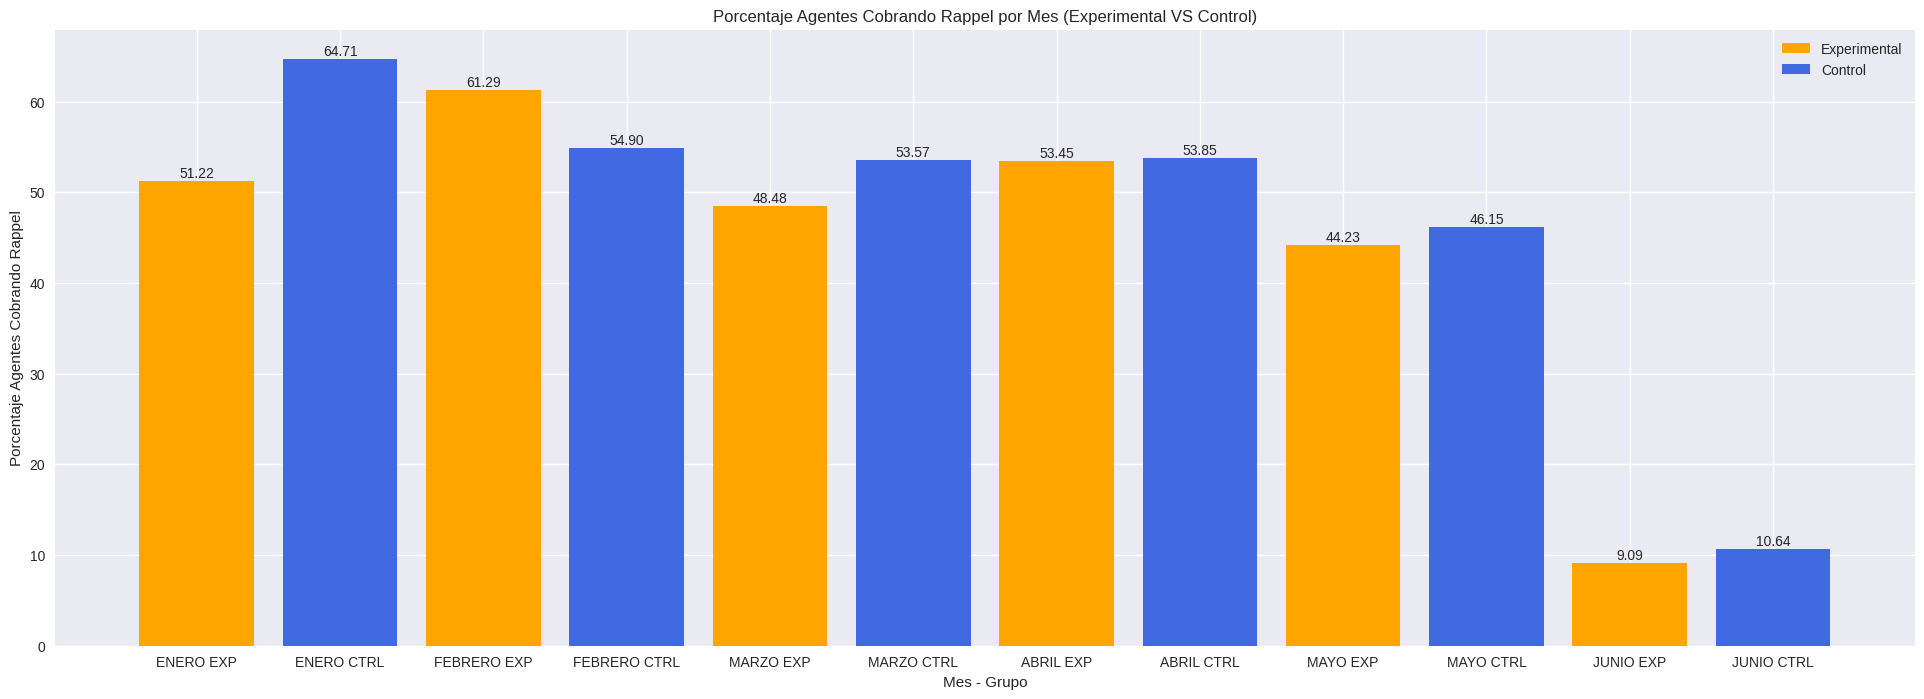

In [108]:
# Preparar datos para el gráfico
porcentaje_rappel_cobrado = [porcentaje_rappel_cobrado_enero_exp, porcentaje_rappel_cobrado_enero_ctrl, porcentaje_rappel_cobrado_febrero_exp, porcentaje_rappel_cobrado_febrero_ctrl, porcentaje_rappel_cobrado_marzo_exp, porcentaje_rappel_cobrado_marzo_ctrl, porcentaje_rappel_cobrado_abril_exp, porcentaje_rappel_cobrado_abril_ctrl, porcentaje_rappel_cobrado_mayo_exp, porcentaje_rappel_cobrado_mayo_ctrl, porcentaje_rappel_cobrado_junio_exp, porcentaje_rappel_cobrado_junio_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, porcentaje_rappel_cobrado, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, porcentaje_rappel_cobrado):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Mes - Grupo')
plt.ylabel('Porcentaje Agentes Cobrando Rappel')
plt.title('Porcentaje Agentes Cobrando Rappel por Mes (Experimental VS Control)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

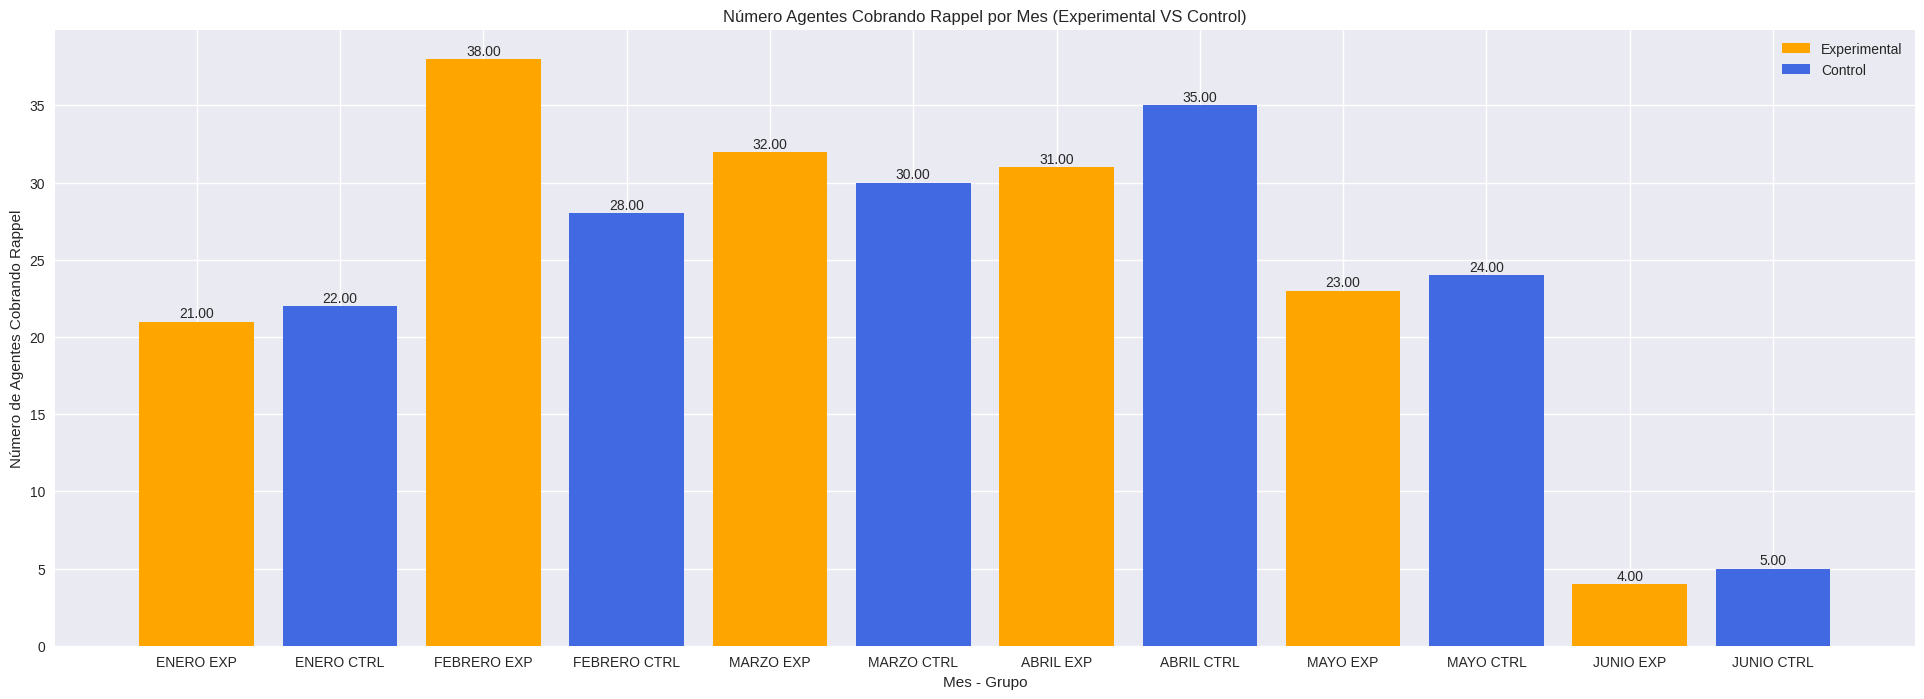

In [109]:
rappel_cobrado_enero_exp = enero_prod_esp_exp['COBRA_RAPPEL'].sum()
rappel_cobrado_febrero_exp = febrero_prod_esp_exp['COBRA_RAPPEL'].sum()
rappel_cobrado_marzo_exp = marzo_prod_esp_exp['COBRA_RAPPEL'].sum()
rappel_cobrado_abril_exp = abril_prod_esp_exp['COBRA_RAPPEL'].sum()
rappel_cobrado_mayo_exp = mayo_prod_esp_exp['COBRA_RAPPEL'].sum()
rappel_cobrado_junio_exp = junio_prod_esp_exp['COBRA_RAPPEL'].sum()

rappel_cobrado_enero_ctrl = enero_prod_esp_ctrl['COBRA_RAPPEL'].sum()
rappel_cobrado_febrero_ctrl = febrero_prod_esp_ctrl['COBRA_RAPPEL'].sum()
rappel_cobrado_marzo_ctrl = marzo_prod_esp_ctrl['COBRA_RAPPEL'].sum()
rappel_cobrado_abril_ctrl = abril_prod_esp_ctrl['COBRA_RAPPEL'].sum()
rappel_cobrado_mayo_ctrl = mayo_prod_esp_ctrl['COBRA_RAPPEL'].sum()
rappel_cobrado_junio_ctrl = junio_prod_esp_ctrl['COBRA_RAPPEL'].sum()

# Preparar datos para el gráfico
rappel_cobrado = [rappel_cobrado_enero_exp, rappel_cobrado_enero_ctrl, rappel_cobrado_febrero_exp, rappel_cobrado_febrero_ctrl, rappel_cobrado_marzo_exp, rappel_cobrado_marzo_ctrl, rappel_cobrado_abril_exp, rappel_cobrado_abril_ctrl, rappel_cobrado_mayo_exp, rappel_cobrado_mayo_ctrl, rappel_cobrado_junio_exp, rappel_cobrado_junio_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, rappel_cobrado, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, rappel_cobrado):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Mes - Grupo')
plt.ylabel('Número de Agentes Cobrando Rappel')
plt.title('Número Agentes Cobrando Rappel por Mes (Experimental VS Control)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

Teniendo en cuenta la totalidad del grupo.

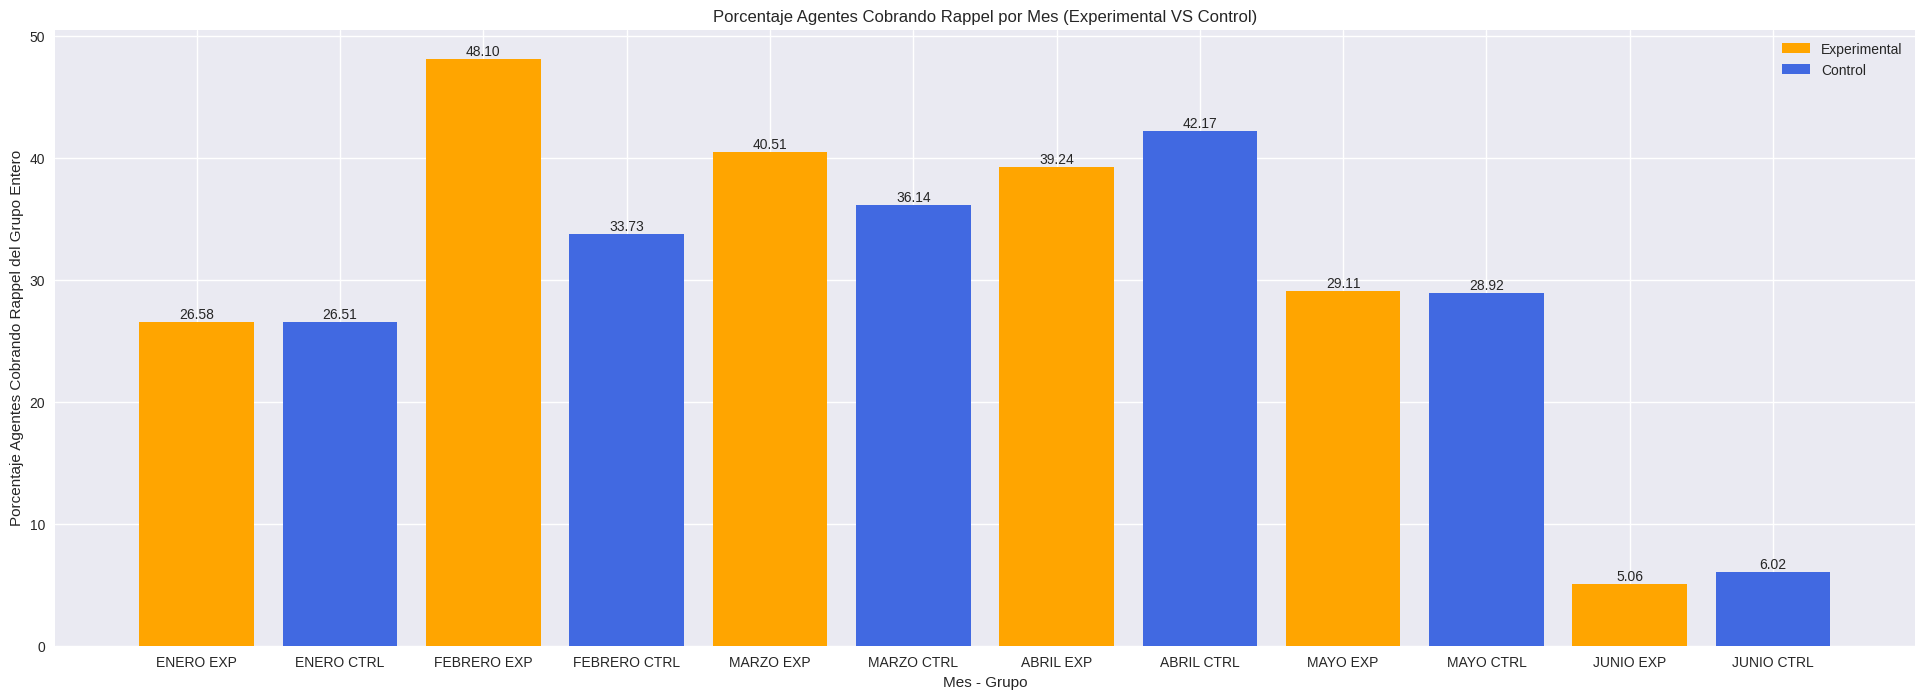

In [110]:
porcentaje_rappel_cobrado_enero_exp = (enero_prod_esp_exp['COBRA_RAPPEL'].sum()/Gr1.shape[0])*100
porcentaje_rappel_cobrado_febrero_exp = (febrero_prod_esp_exp['COBRA_RAPPEL'].sum()/Gr1.shape[0])*100
porcentaje_rappel_cobrado_marzo_exp = (marzo_prod_esp_exp['COBRA_RAPPEL'].sum()/Gr1.shape[0])*100
porcentaje_rappel_cobrado_abril_exp = (abril_prod_esp_exp['COBRA_RAPPEL'].sum()/Gr1.shape[0])*100
porcentaje_rappel_cobrado_mayo_exp = (mayo_prod_esp_exp['COBRA_RAPPEL'].sum()/Gr1.shape[0])*100
porcentaje_rappel_cobrado_junio_exp = (junio_prod_esp_exp['COBRA_RAPPEL'].sum()/Gr1.shape[0])*100

porcentaje_rappel_cobrado_enero_ctrl = (enero_prod_esp_ctrl['COBRA_RAPPEL'].sum()/Gr2.shape[0])*100
porcentaje_rappel_cobrado_febrero_ctrl = (febrero_prod_esp_ctrl['COBRA_RAPPEL'].sum()/Gr2.shape[0])*100
porcentaje_rappel_cobrado_marzo_ctrl = (marzo_prod_esp_ctrl['COBRA_RAPPEL'].sum()/Gr2.shape[0])*100
porcentaje_rappel_cobrado_abril_ctrl = (abril_prod_esp_ctrl['COBRA_RAPPEL'].sum()/Gr2.shape[0])*100
porcentaje_rappel_cobrado_mayo_ctrl = (mayo_prod_esp_ctrl['COBRA_RAPPEL'].sum()/Gr2.shape[0])*100
porcentaje_rappel_cobrado_junio_ctrl = (junio_prod_esp_ctrl['COBRA_RAPPEL'].sum()/Gr2.shape[0])*100


# Preparar datos para el gráfico
porcentaje_rappel_cobrado = [porcentaje_rappel_cobrado_enero_exp, porcentaje_rappel_cobrado_enero_ctrl, porcentaje_rappel_cobrado_febrero_exp, porcentaje_rappel_cobrado_febrero_ctrl, porcentaje_rappel_cobrado_marzo_exp, porcentaje_rappel_cobrado_marzo_ctrl, porcentaje_rappel_cobrado_abril_exp, porcentaje_rappel_cobrado_abril_ctrl, porcentaje_rappel_cobrado_mayo_exp, porcentaje_rappel_cobrado_mayo_ctrl, porcentaje_rappel_cobrado_junio_exp, porcentaje_rappel_cobrado_junio_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, porcentaje_rappel_cobrado, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, porcentaje_rappel_cobrado):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Mes - Grupo')
plt.ylabel('Porcentaje Agentes Cobrando Rappel del Grupo Entero')
plt.title('Porcentaje Agentes Cobrando Rappel por Mes (Experimental VS Control)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

####Solo agentes estándar para el XXL

In [111]:
enero_prod_esp_exp_est = enero_prod_esp_exp[enero_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]
febrero_prod_esp_exp_est = febrero_prod_esp_exp[febrero_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]
marzo_prod_esp_exp_est = marzo_prod_esp_exp[marzo_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]
abril_prod_esp_exp_est = abril_prod_esp_exp[abril_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]
mayo_prod_esp_exp_est = mayo_prod_esp_exp[mayo_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]
junio_prod_esp_exp_est = junio_prod_esp_exp[junio_prod_esp_exp["TIPOLOGIA"].str.contains("ESTANDAR")]

enero_prod_esp_ctrl_est = enero_prod_esp_ctrl[enero_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]
febrero_prod_esp_ctrl_est = febrero_prod_esp_ctrl[febrero_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]
marzo_prod_esp_ctrl_est = marzo_prod_esp_ctrl[marzo_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]
abril_prod_esp_ctrl_est = abril_prod_esp_ctrl[abril_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]
mayo_prod_esp_ctrl_est = mayo_prod_esp_ctrl[mayo_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]
junio_prod_esp_ctrl_est = junio_prod_esp_ctrl[junio_prod_esp_ctrl["TIPOLOGIA"].str.contains("ESTANDAR")]

enero_prod_esp_exp_for = enero_prod_esp_exp[enero_prod_esp_exp["TIPOLOGIA"].str.contains("FOR")]
febrero_prod_esp_exp_for = febrero_prod_esp_exp[febrero_prod_esp_exp["TIPOLOGIA"].str.contains("FOR")]
marzo_prod_esp_exp_for = marzo_prod_esp_exp[marzo_prod_esp_exp["TIPOLOGIA"].str.contains("FOR")]
abril_prod_esp_exp_for = abril_prod_esp_exp[abril_prod_esp_exp["TIPOLOGIA"].str.contains("FOR")]
mayo_prod_esp_exp_for = mayo_prod_esp_exp[mayo_prod_esp_exp["TIPOLOGIA"].str.contains("FOR")]
junio_prod_esp_exp_for = junio_prod_esp_exp[junio_prod_esp_exp["TIPOLOGIA"].str.contains("FOR")]

enero_prod_esp_ctrl_for = enero_prod_esp_ctrl[enero_prod_esp_ctrl["TIPOLOGIA"].str.contains("FOR")]
febrero_prod_esp_ctrl_for = febrero_prod_esp_ctrl[febrero_prod_esp_ctrl["TIPOLOGIA"].str.contains("FOR")]
marzo_prod_esp_ctrl_for = marzo_prod_esp_ctrl[marzo_prod_esp_ctrl["TIPOLOGIA"].str.contains("FOR")]
abril_prod_esp_ctrl_for = abril_prod_esp_ctrl[abril_prod_esp_ctrl["TIPOLOGIA"].str.contains("FOR")]
mayo_prod_esp_ctrl_for = mayo_prod_esp_ctrl[mayo_prod_esp_ctrl["TIPOLOGIA"].str.contains("FOR")]
junio_prod_esp_ctrl_for = junio_prod_esp_ctrl[junio_prod_esp_ctrl["TIPOLOGIA"].str.contains("FOR")]

In [112]:
porcentaje_rappelxxl_cobrado_enero_exp = (enero_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/enero_prod_esp_exp_est.shape[0])*100
porcentaje_rappelxxl_cobrado_febrero_exp = (febrero_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/febrero_prod_esp_exp_est.shape[0])*100
porcentaje_rappelxxl_cobrado_marzo_exp = (marzo_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/marzo_prod_esp_exp_est.shape[0])*100
porcentaje_rappelxxl_cobrado_abril_exp = (abril_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/abril_prod_esp_exp_est.shape[0])*100
porcentaje_rappelxxl_cobrado_mayo_exp = (mayo_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/mayo_prod_esp_exp_est.shape[0])*100
porcentaje_rappelxxl_cobrado_junio_exp = (junio_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/junio_prod_esp_exp_est.shape[0])*100

porcentaje_rappelxxl_cobrado_enero_ctrl = (enero_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/enero_prod_esp_ctrl.shape[0])*100
porcentaje_rappelxxl_cobrado_febrero_ctrl = (febrero_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/febrero_prod_esp_ctrl.shape[0])*100
porcentaje_rappelxxl_cobrado_marzo_ctrl = (marzo_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/marzo_prod_esp_ctrl.shape[0])*100
porcentaje_rappelxxl_cobrado_abril_ctrl = (abril_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/abril_prod_esp_ctrl.shape[0])*100
porcentaje_rappelxxl_cobrado_mayo_ctrl = (mayo_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/mayo_prod_esp_ctrl.shape[0])*100
porcentaje_rappelxxl_cobrado_junio_ctrl = (junio_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/junio_prod_esp_ctrl.shape[0])*100

Hay que tener en cuenta que esto es solo con los agentes que están dados de alta actualmente en la compañía.

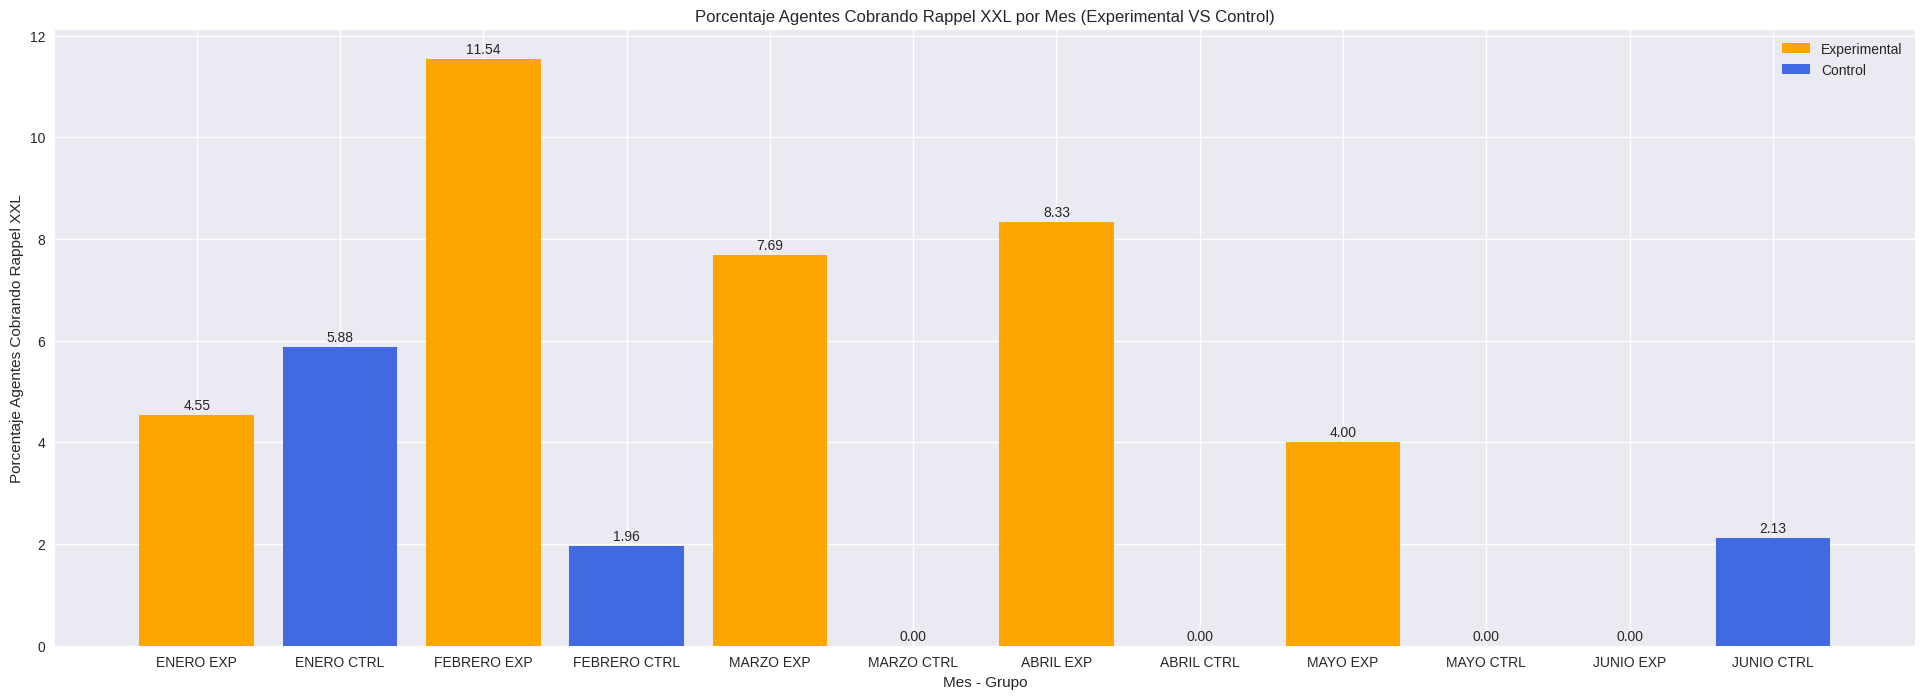

In [113]:
# Preparar datos para el gráfico
porcentaje_rappelxxl_cobrado = [porcentaje_rappelxxl_cobrado_enero_exp, porcentaje_rappelxxl_cobrado_enero_ctrl, porcentaje_rappelxxl_cobrado_febrero_exp, porcentaje_rappelxxl_cobrado_febrero_ctrl, porcentaje_rappelxxl_cobrado_marzo_exp, porcentaje_rappelxxl_cobrado_marzo_ctrl, porcentaje_rappelxxl_cobrado_abril_exp, porcentaje_rappelxxl_cobrado_abril_ctrl, porcentaje_rappelxxl_cobrado_mayo_exp, porcentaje_rappelxxl_cobrado_mayo_ctrl, porcentaje_rappelxxl_cobrado_junio_exp, porcentaje_rappelxxl_cobrado_junio_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, porcentaje_rappelxxl_cobrado, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, porcentaje_rappelxxl_cobrado):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Mes - Grupo')
plt.ylabel('Porcentaje Agentes Cobrando Rappel XXL')
plt.title('Porcentaje Agentes Cobrando Rappel XXL por Mes (Experimental VS Control)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

Teniendo el cuenta todo el grupo.

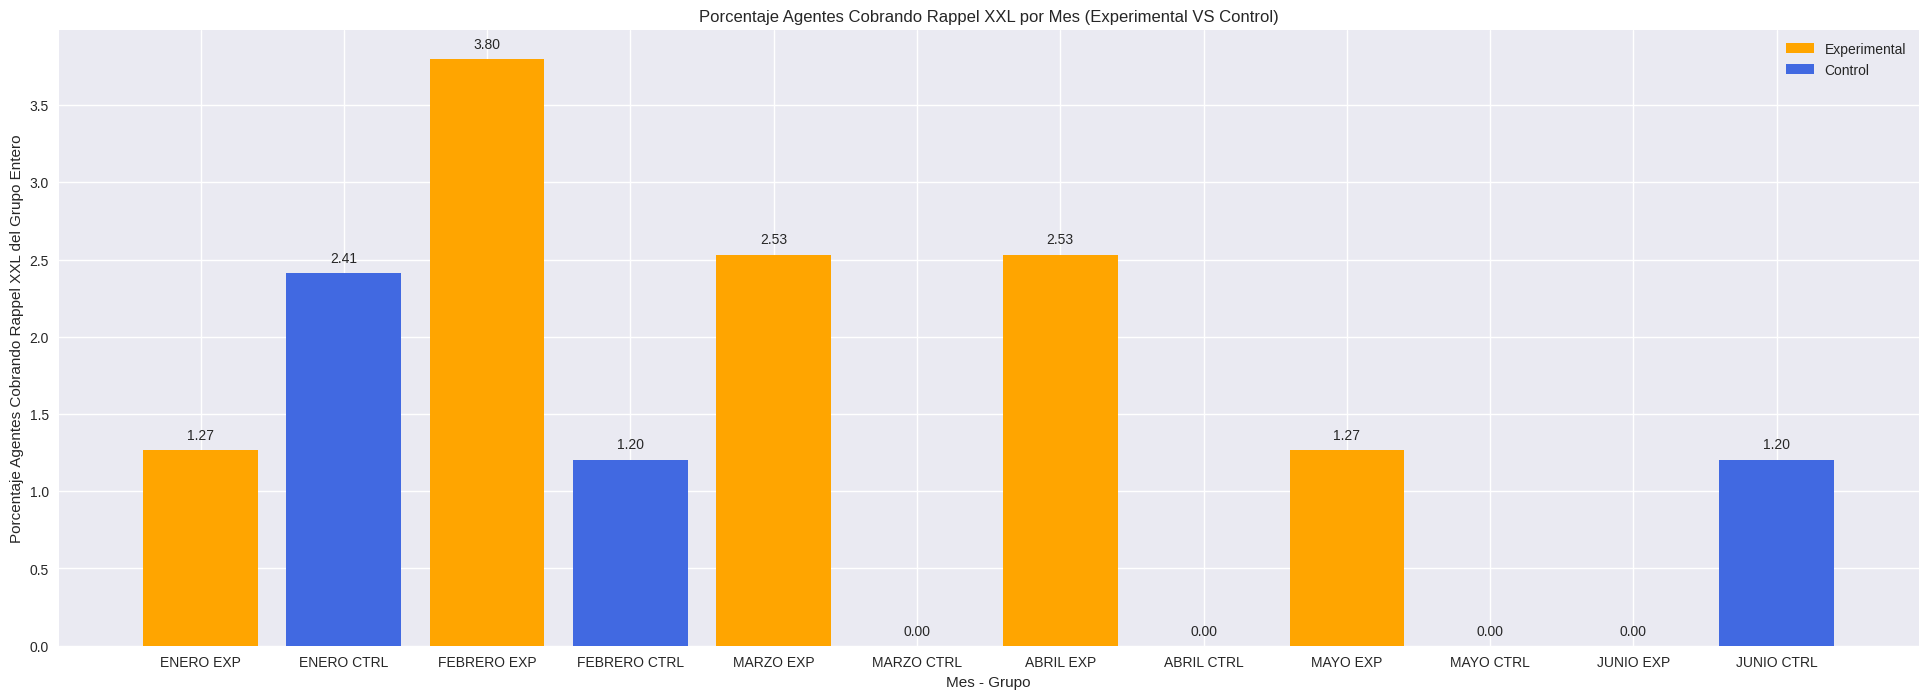

In [114]:
porcentaje_rappelxxl_cobrado_enero_exp = (enero_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/Gr1.shape[0])*100
porcentaje_rappelxxl_cobrado_febrero_exp = (febrero_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/Gr1.shape[0])*100
porcentaje_rappelxxl_cobrado_marzo_exp = (marzo_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/Gr1.shape[0])*100
porcentaje_rappelxxl_cobrado_abril_exp = (abril_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/Gr1.shape[0])*100
porcentaje_rappelxxl_cobrado_mayo_exp = (mayo_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/Gr1.shape[0])*100
porcentaje_rappelxxl_cobrado_junio_exp = (junio_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()/Gr1.shape[0])*100

porcentaje_rappelxxl_cobrado_enero_ctrl = (enero_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/Gr2.shape[0])*100
porcentaje_rappelxxl_cobrado_febrero_ctrl = (febrero_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/Gr2.shape[0])*100
porcentaje_rappelxxl_cobrado_marzo_ctrl = (marzo_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/Gr2.shape[0])*100
porcentaje_rappelxxl_cobrado_abril_ctrl = (abril_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/Gr2.shape[0])*100
porcentaje_rappelxxl_cobrado_mayo_ctrl = (mayo_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/Gr2.shape[0])*100
porcentaje_rappelxxl_cobrado_junio_ctrl = (junio_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()/Gr2.shape[0])*100


# Preparar datos para el gráfico
porcentaje_rappelxxl_cobrado = [porcentaje_rappelxxl_cobrado_enero_exp, porcentaje_rappelxxl_cobrado_enero_ctrl, porcentaje_rappelxxl_cobrado_febrero_exp, porcentaje_rappelxxl_cobrado_febrero_ctrl, porcentaje_rappelxxl_cobrado_marzo_exp, porcentaje_rappelxxl_cobrado_marzo_ctrl, porcentaje_rappelxxl_cobrado_abril_exp, porcentaje_rappelxxl_cobrado_abril_ctrl, porcentaje_rappelxxl_cobrado_mayo_exp, porcentaje_rappelxxl_cobrado_mayo_ctrl, porcentaje_rappelxxl_cobrado_junio_exp, porcentaje_rappelxxl_cobrado_junio_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, porcentaje_rappelxxl_cobrado, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, porcentaje_rappelxxl_cobrado):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Mes - Grupo')
plt.ylabel('Porcentaje Agentes Cobrando Rappel XXL del Grupo Entero')
plt.title('Porcentaje Agentes Cobrando Rappel XXL por Mes (Experimental VS Control)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

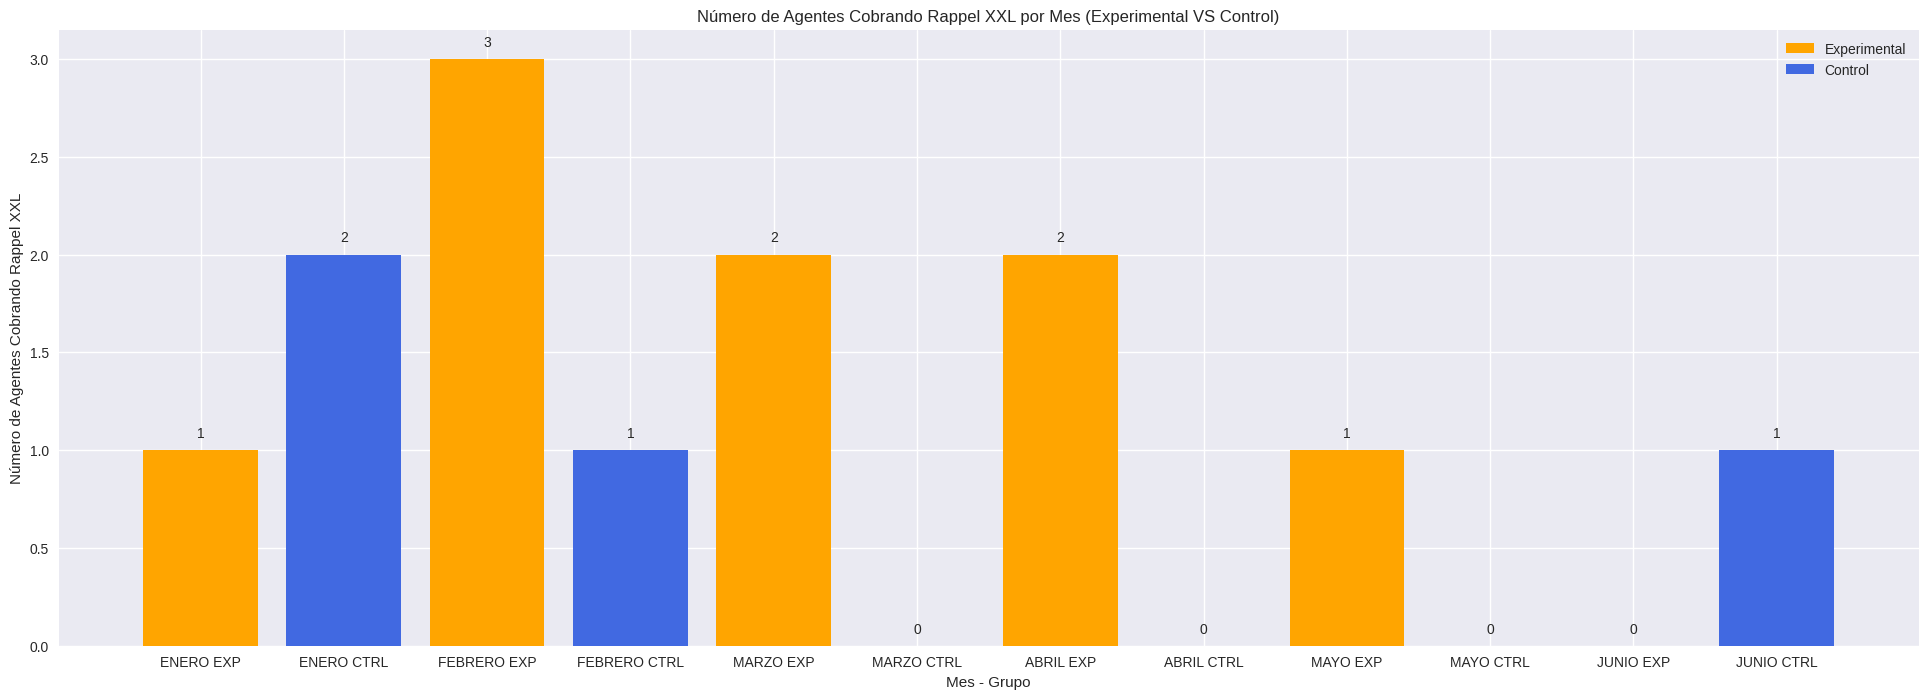

In [115]:
rappelxxl_cobrado_enero_exp = enero_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()
rappelxxl_cobrado_febrero_exp = febrero_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()
rappelxxl_cobrado_marzo_exp = marzo_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()
rappelxxl_cobrado_abril_exp = abril_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()
rappelxxl_cobrado_mayo_exp = mayo_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()
rappelxxl_cobrado_junio_exp = junio_prod_esp_exp_est['COBRA_RAPPELXXL'].sum()

rappelxxl_cobrado_enero_ctrl = enero_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()
rappelxxl_cobrado_febrero_ctrl = febrero_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()
rappelxxl_cobrado_marzo_ctrl = marzo_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()
rappelxxl_cobrado_abril_ctrl = abril_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()
rappelxxl_cobrado_mayo_ctrl = mayo_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()
rappelxxl_cobrado_junio_ctrl = junio_prod_esp_ctrl_est['COBRA_RAPPELXXL'].sum()


# Preparar datos para el gráfico
rappelxxl_cobrado = [rappelxxl_cobrado_enero_exp, rappelxxl_cobrado_enero_ctrl, rappelxxl_cobrado_febrero_exp, rappelxxl_cobrado_febrero_ctrl, rappelxxl_cobrado_marzo_exp, rappelxxl_cobrado_marzo_ctrl, rappelxxl_cobrado_abril_exp, rappelxxl_cobrado_abril_ctrl, rappelxxl_cobrado_mayo_exp, rappelxxl_cobrado_mayo_ctrl, rappelxxl_cobrado_junio_exp, rappelxxl_cobrado_junio_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, rappelxxl_cobrado, color=['orange', 'royalblue'])


for barra, valor in zip(barras, rappelxxl_cobrado):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor}', ha='center', va='bottom')

plt.xlabel('Mes - Grupo')
plt.ylabel('Número de Agentes Cobrando Rappel XXL')
plt.title('Número de Agentes Cobrando Rappel XXL por Mes (Experimental VS Control)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

###Número de Agentes Estandar cobrando Rappel

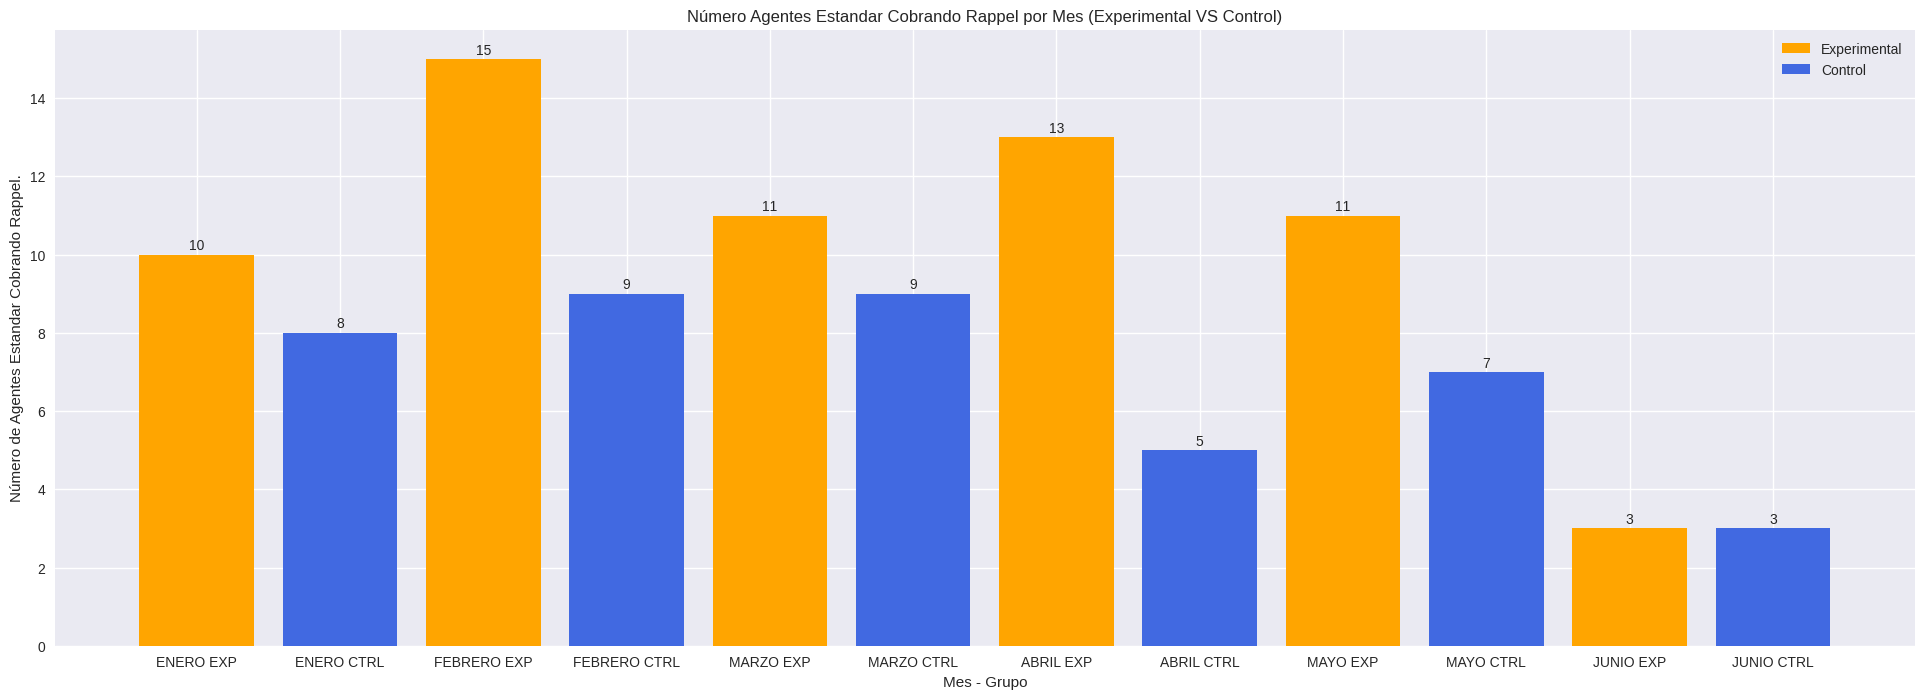

In [116]:
rappel_cobrado_enero_exp = enero_prod_esp_exp_est['COBRA_RAPPEL'].sum()
rappel_cobrado_febrero_exp = febrero_prod_esp_exp_est['COBRA_RAPPEL'].sum()
rappel_cobrado_marzo_exp = marzo_prod_esp_exp_est['COBRA_RAPPEL'].sum()
rappel_cobrado_abril_exp = abril_prod_esp_exp_est['COBRA_RAPPEL'].sum()
rappel_cobrado_mayo_exp = mayo_prod_esp_exp_est['COBRA_RAPPEL'].sum()
rappel_cobrado_junio_exp = junio_prod_esp_exp_est['COBRA_RAPPEL'].sum()

rappel_cobrado_enero_ctrl = enero_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()
rappel_cobrado_febrero_ctrl = febrero_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()
rappel_cobrado_marzo_ctrl = marzo_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()
rappel_cobrado_abril_ctrl = abril_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()
rappel_cobrado_mayo_ctrl = mayo_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()
rappel_cobrado_junio_ctrl = junio_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()

# Preparar datos para el gráfico
rappel_cobrado = [rappel_cobrado_enero_exp, rappel_cobrado_enero_ctrl, rappel_cobrado_febrero_exp, rappel_cobrado_febrero_ctrl, rappel_cobrado_marzo_exp, rappel_cobrado_marzo_ctrl, rappel_cobrado_abril_exp, rappel_cobrado_abril_ctrl, rappel_cobrado_mayo_exp, rappel_cobrado_mayo_ctrl, rappel_cobrado_junio_exp, rappel_cobrado_junio_ctrl]

# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, rappel_cobrado, color=['orange', 'royalblue'])

for barra, valor in zip(barras, rappel_cobrado):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor}', ha='center', va='bottom')

plt.xlabel('Mes - Grupo')
plt.ylabel('Número de Agentes Estandar Cobrando Rappel.')
plt.title('Número Agentes Estandar Cobrando Rappel por Mes (Experimental VS Control)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

In [117]:
enero_exp_est = enero_exp[enero_exp["TIPOLOGIA"].str.contains("EST")]
febrero_exp_est = febrero_exp[febrero_exp["TIPOLOGIA"].str.contains("EST")]
marzo_exp_est = marzo_exp[marzo_exp["TIPOLOGIA"].str.contains("EST")]
abril_exp_est = abril_exp[abril_exp["TIPOLOGIA"].str.contains("EST")]
mayo_exp_est = mayo_exp[mayo_exp["TIPOLOGIA"].str.contains("EST")]
junio_exp_est = junio_exp[junio_exp["TIPOLOGIA"].str.contains("EST")]

enero_ctrl_est = enero_ctrl[enero_ctrl["TIPOLOGIA"].str.contains("EST")]
febrero_ctrl_est = febrero_ctrl[febrero_ctrl["TIPOLOGIA"].str.contains("EST")]
marzo_ctrl_est = marzo_ctrl[marzo_ctrl["TIPOLOGIA"].str.contains("EST")]
abril_ctrl_est = abril_ctrl[abril_ctrl["TIPOLOGIA"].str.contains("EST")]
mayo_ctrl_est = mayo_ctrl[mayo_ctrl["TIPOLOGIA"].str.contains("EST")]
junio_ctrl_est = junio_ctrl[junio_ctrl["TIPOLOGIA"].str.contains("EST")]

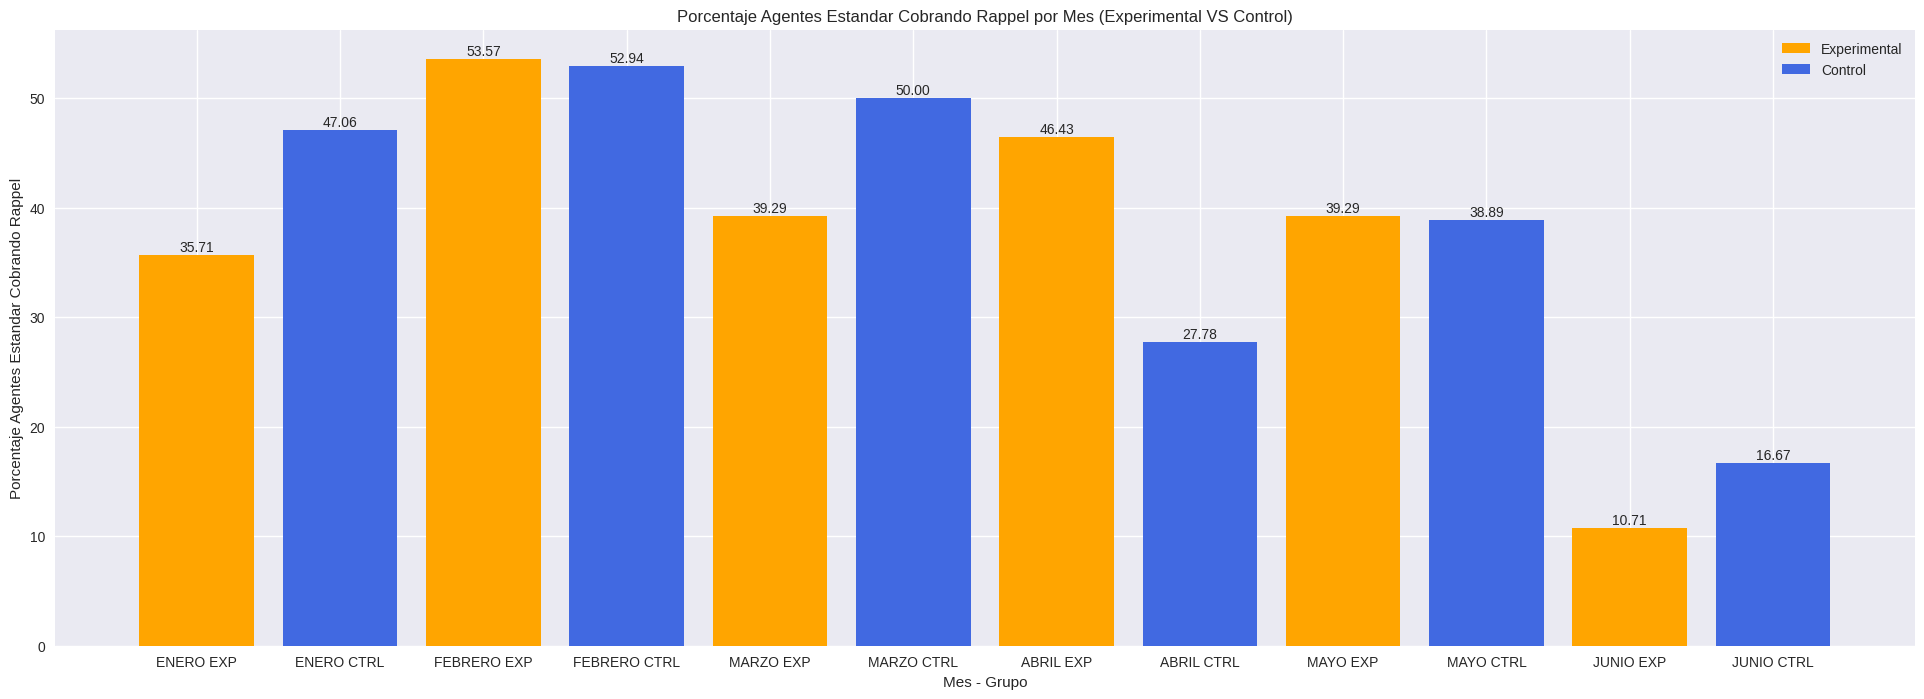

In [118]:
porcentaje_rappel_cobrado_enero_exp_est = (enero_prod_esp_exp_est['COBRA_RAPPEL'].sum()/enero_exp_est.shape[0])*100
porcentaje_rappel_cobrado_febrero_exp_est = (febrero_prod_esp_exp_est['COBRA_RAPPEL'].sum()/febrero_exp_est.shape[0])*100
porcentaje_rappel_cobrado_marzo_exp_est = (marzo_prod_esp_exp_est['COBRA_RAPPEL'].sum()/marzo_exp_est.shape[0])*100
porcentaje_rappel_cobrado_abril_exp_est = (abril_prod_esp_exp_est['COBRA_RAPPEL'].sum()/abril_exp_est.shape[0])*100
porcentaje_rappel_cobrado_mayo_exp_est = (mayo_prod_esp_exp_est['COBRA_RAPPEL'].sum()/mayo_exp_est.shape[0])*100
porcentaje_rappel_cobrado_junio_exp_est = (junio_prod_esp_exp_est['COBRA_RAPPEL'].sum()/junio_exp_est.shape[0])*100

porcentaje_rappel_cobrado_enero_ctrl_est = (enero_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()/enero_ctrl_est.shape[0])*100
porcentaje_rappel_cobrado_febrero_ctrl_est = (febrero_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()/febrero_ctrl_est.shape[0])*100
porcentaje_rappel_cobrado_marzo_ctrl_est = (marzo_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()/marzo_ctrl_est.shape[0])*100
porcentaje_rappel_cobrado_abril_ctrl_est = (abril_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()/abril_ctrl_est.shape[0])*100
porcentaje_rappel_cobrado_mayo_ctrl_est = (mayo_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()/mayo_ctrl_est.shape[0])*100
porcentaje_rappel_cobrado_junio_ctrl_est = (junio_prod_esp_ctrl_est['COBRA_RAPPEL'].sum()/junio_ctrl_est.shape[0])*100



# Preparar datos para el gráfico
porcentaje_rappel_cobrado = [porcentaje_rappel_cobrado_enero_exp_est, porcentaje_rappel_cobrado_enero_ctrl_est, porcentaje_rappel_cobrado_febrero_exp_est, porcentaje_rappel_cobrado_febrero_ctrl_est, porcentaje_rappel_cobrado_marzo_exp_est, porcentaje_rappel_cobrado_marzo_ctrl_est, porcentaje_rappel_cobrado_abril_exp_est, porcentaje_rappel_cobrado_abril_ctrl_est, porcentaje_rappel_cobrado_mayo_exp_est, porcentaje_rappel_cobrado_mayo_ctrl_est, porcentaje_rappel_cobrado_junio_exp_est, porcentaje_rappel_cobrado_junio_ctrl_est]

# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, porcentaje_rappel_cobrado, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, porcentaje_rappel_cobrado):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Mes - Grupo')
plt.ylabel('Porcentaje Agentes Estandar Cobrando Rappel')
plt.title('Porcentaje Agentes Estandar Cobrando Rappel por Mes (Experimental VS Control)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()

###Porcentaje de Agentes en Formación cobrando Rappel

In [119]:
enero_exp_for = enero_exp[enero_exp["TIPOLOGIA"].str.contains("FOR")]
febrero_exp_for = febrero_exp[febrero_exp["TIPOLOGIA"].str.contains("FOR")]
marzo_exp_for = marzo_exp[marzo_exp["TIPOLOGIA"].str.contains("FOR")]
abril_exp_for = abril_exp[abril_exp["TIPOLOGIA"].str.contains("FOR")]
mayo_exp_for = mayo_exp[mayo_exp["TIPOLOGIA"].str.contains("FOR")]
junio_exp_for = junio_exp[junio_exp["TIPOLOGIA"].str.contains("FOR")]

enero_ctrl_for = enero_ctrl[enero_ctrl["TIPOLOGIA"].str.contains("FOR")]
febrero_ctrl_for = febrero_ctrl[febrero_ctrl["TIPOLOGIA"].str.contains("FOR")]
marzo_ctrl_for = marzo_ctrl[marzo_ctrl["TIPOLOGIA"].str.contains("FOR")]
abril_ctrl_for = abril_ctrl[abril_ctrl["TIPOLOGIA"].str.contains("FOR")]
mayo_ctrl_for = mayo_ctrl[mayo_ctrl["TIPOLOGIA"].str.contains("FOR")]
junio_ctrl_for = junio_ctrl[junio_ctrl["TIPOLOGIA"].str.contains("FOR")]

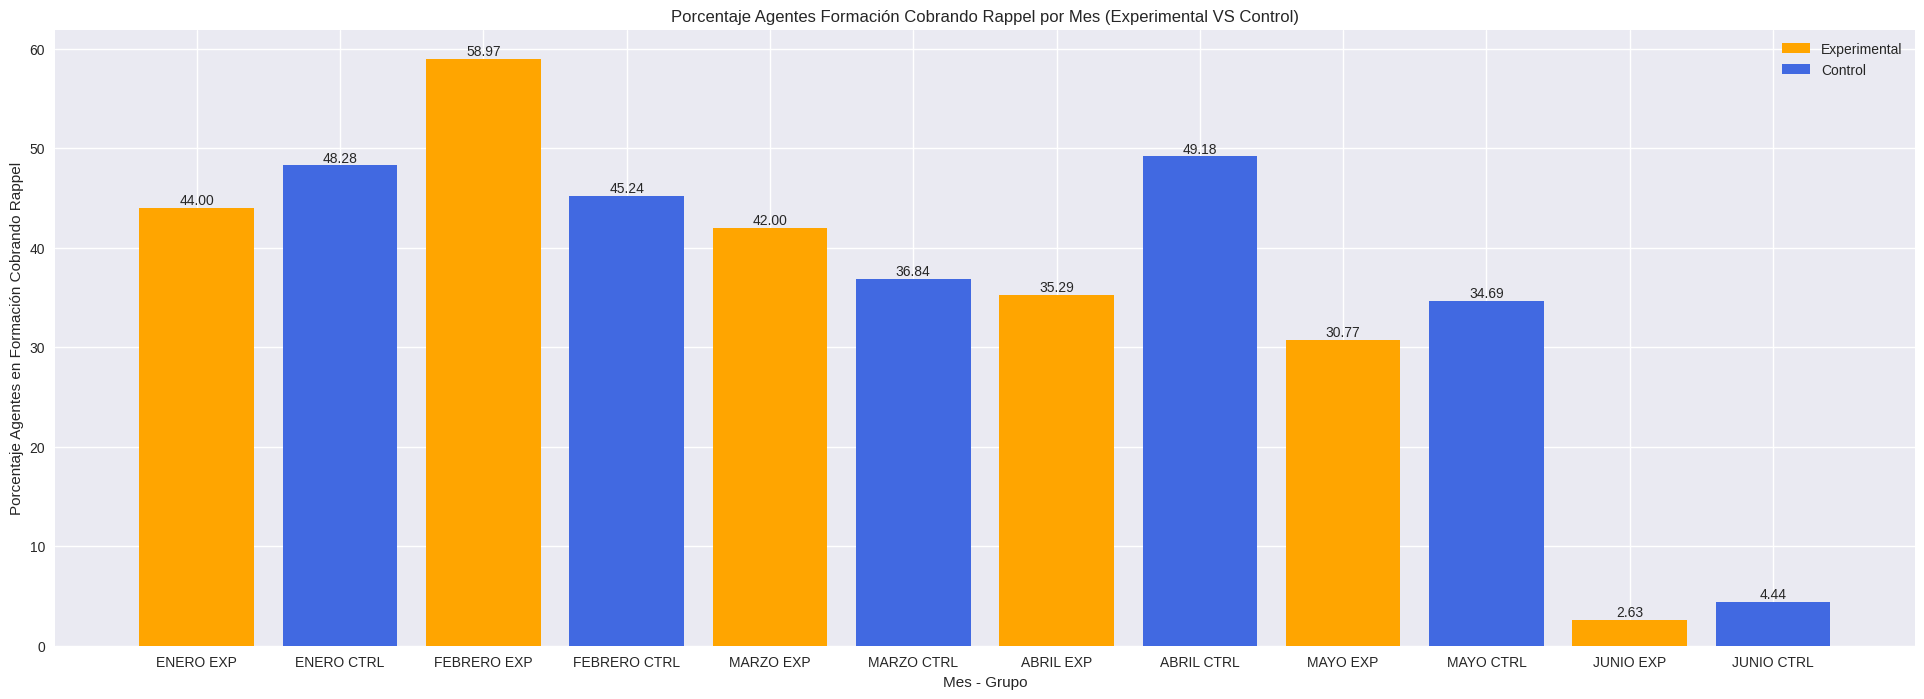

In [120]:
porcentaje_rappel_cobrado_enero_exp_for = (enero_prod_esp_exp_for['COBRA_RAPPEL'].sum()/enero_exp_for.shape[0])*100
porcentaje_rappel_cobrado_febrero_exp_for = (febrero_prod_esp_exp_for['COBRA_RAPPEL'].sum()/febrero_exp_for.shape[0])*100
porcentaje_rappel_cobrado_marzo_exp_for = (marzo_prod_esp_exp_for['COBRA_RAPPEL'].sum()/marzo_exp_for.shape[0])*100
porcentaje_rappel_cobrado_abril_exp_for = (abril_prod_esp_exp_for['COBRA_RAPPEL'].sum()/abril_exp_for.shape[0])*100
porcentaje_rappel_cobrado_mayo_exp_for = (mayo_prod_esp_exp_for['COBRA_RAPPEL'].sum()/mayo_exp_for.shape[0])*100
porcentaje_rappel_cobrado_junio_exp_for = (junio_prod_esp_exp_for['COBRA_RAPPEL'].sum()/junio_exp_for.shape[0])*100

porcentaje_rappel_cobrado_enero_ctrl_for = (enero_prod_esp_ctrl_for['COBRA_RAPPEL'].sum()/enero_ctrl_for.shape[0])*100
porcentaje_rappel_cobrado_febrero_ctrl_for = (febrero_prod_esp_ctrl_for['COBRA_RAPPEL'].sum()/febrero_ctrl_for.shape[0])*100
porcentaje_rappel_cobrado_marzo_ctrl_for = (marzo_prod_esp_ctrl_for['COBRA_RAPPEL'].sum()/marzo_ctrl_for.shape[0])*100
porcentaje_rappel_cobrado_abril_ctrl_for = (abril_prod_esp_ctrl_for['COBRA_RAPPEL'].sum()/abril_ctrl_for.shape[0])*100
porcentaje_rappel_cobrado_mayo_ctrl_for = (mayo_prod_esp_ctrl_for['COBRA_RAPPEL'].sum()/mayo_ctrl_for.shape[0])*100
porcentaje_rappel_cobrado_junio_ctrl_for = (junio_prod_esp_ctrl_for['COBRA_RAPPEL'].sum()/junio_ctrl_for.shape[0])*100



# Preparar datos para el gráfico
porcentaje_rappel_cobrado = [porcentaje_rappel_cobrado_enero_exp_for, porcentaje_rappel_cobrado_enero_ctrl_for, porcentaje_rappel_cobrado_febrero_exp_for, porcentaje_rappel_cobrado_febrero_ctrl_for, porcentaje_rappel_cobrado_marzo_exp_for, porcentaje_rappel_cobrado_marzo_ctrl_for, porcentaje_rappel_cobrado_abril_exp_for, porcentaje_rappel_cobrado_abril_ctrl_for, porcentaje_rappel_cobrado_mayo_exp_for, porcentaje_rappel_cobrado_mayo_ctrl_for, porcentaje_rappel_cobrado_junio_exp_for, porcentaje_rappel_cobrado_junio_ctrl_for]

# Crear el gráfico de barras
plt.figure(figsize=(24, 8))
barras = plt.bar(columnas_meses, porcentaje_rappel_cobrado, color=['orange', 'royalblue'])


# Add the correct numbers on top of each bar, rounded to 2 decimal places
for barra, valor in zip(barras, porcentaje_rappel_cobrado):
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval + 0.05, f'{valor:.2f}', ha='center', va='bottom')

plt.xlabel('Mes - Grupo')
plt.ylabel('Porcentaje Agentes en Formación Cobrando Rappel')
plt.title('Porcentaje Agentes Formación Cobrando Rappel por Mes (Experimental VS Control)')
plt.legend([barras[0], barras[1]], ['Experimental', 'Control'])
plt.show()